In [1]:
import sys
print(sys.version)

3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
"""
Created on January 10 2018
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)  

In [3]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [4]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [260]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

#Zernike_Module_lastOct15_beforeScatterChange
import Zernike_Module
from Zernike_Module import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#general import statments
from __future__ import absolute_import, division, print_function
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 22})
%config InlineBackend.rc = {}
%matplotlib inline

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

### unit test - z11

In [258]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([20,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.65,0.1,0.3,0.0,0.07,0.0,
                                 0.3,1.0,1,1,
                                 0.0,-0.0,0.90,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1)   

res=model(allparameters_proposal)
print(res)
#assert res=-4808.04
#print('ok')

version of the code is: 0.18
zmax: 11
-3461.344193055439


In [9]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

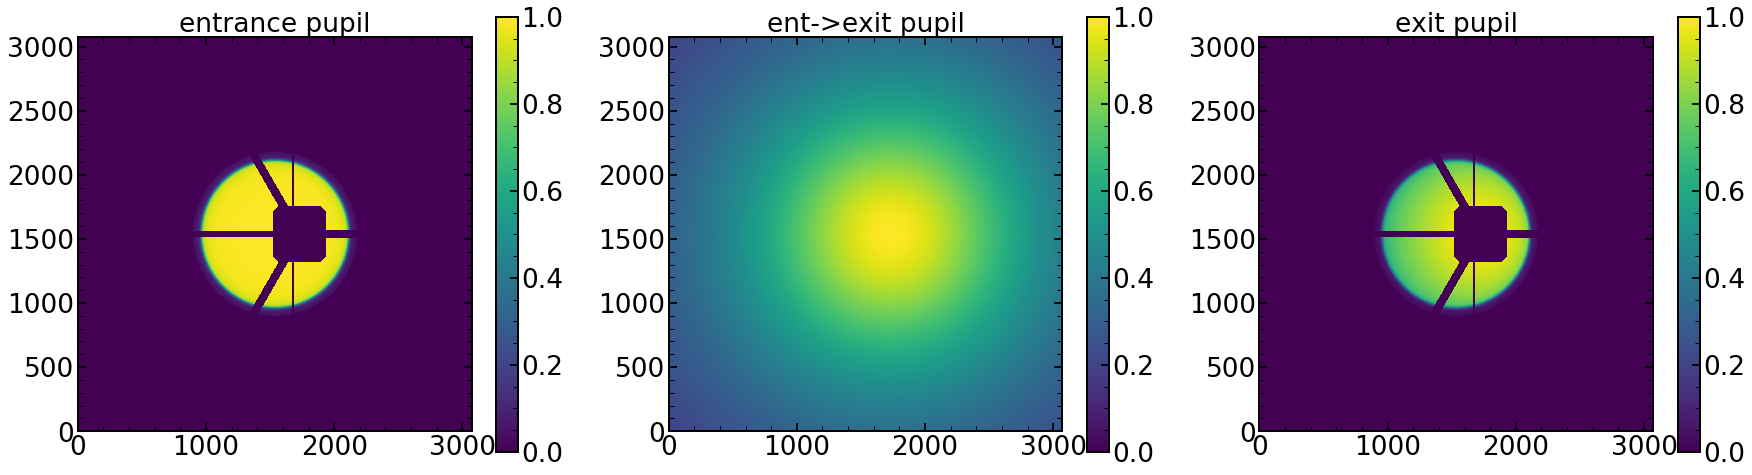

In [10]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

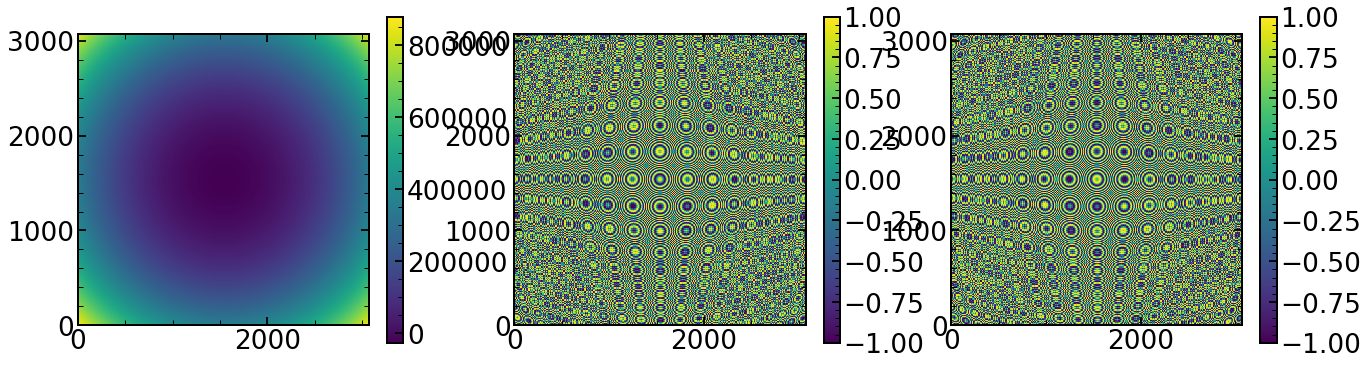

In [11]:
plt.figure(figsize=(30,6))
plt.subplot(141)
plt.imshow(wf_full)
plt.colorbar()

plt.subplot(142)
plt.imshow(np.real(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

plt.subplot(143)
plt.imshow(np.imag(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()


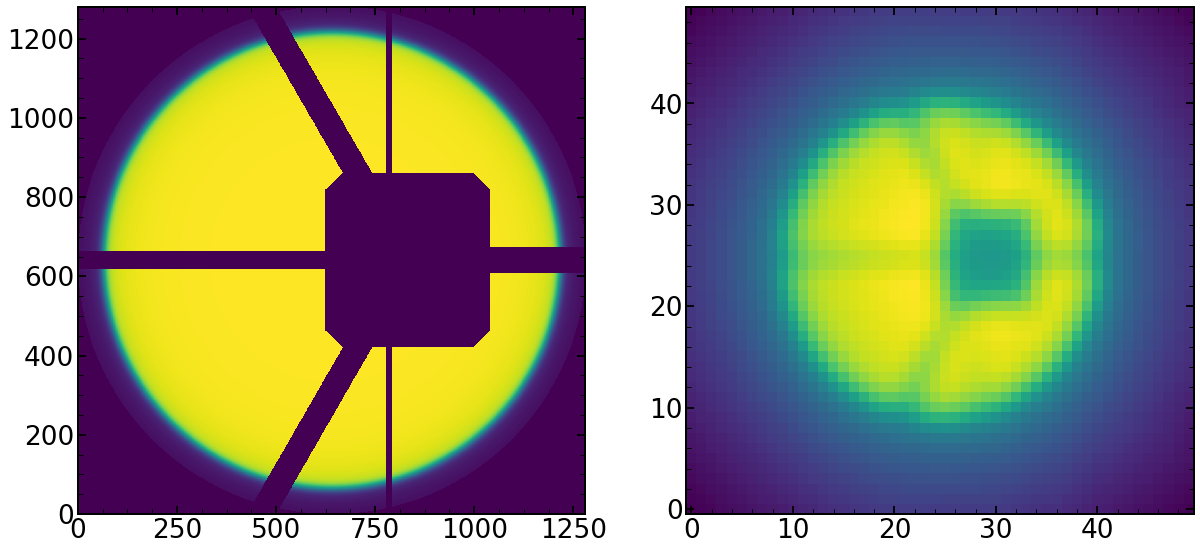

In [12]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')

### unit test - z22

In [262]:
columns22=['z4','z5','z6','z7','z8','z9','z10','z11',
           'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((50,50))
var_image_unit=np.ones((50,50))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([20,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.5,0,0,0,0,0,0,0,0,0,0.99,
                                 0.65,0.1,0.3,0.0,0.07,0.0,
                                 0.3,1.0,1,1,
                                 0.0,-0.0,0.90,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,zmax=22)  

res=model(allparameters_proposal)
print(res)

version of the code is: 0.18
zmax: 22
-4302.941304403997


In [263]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

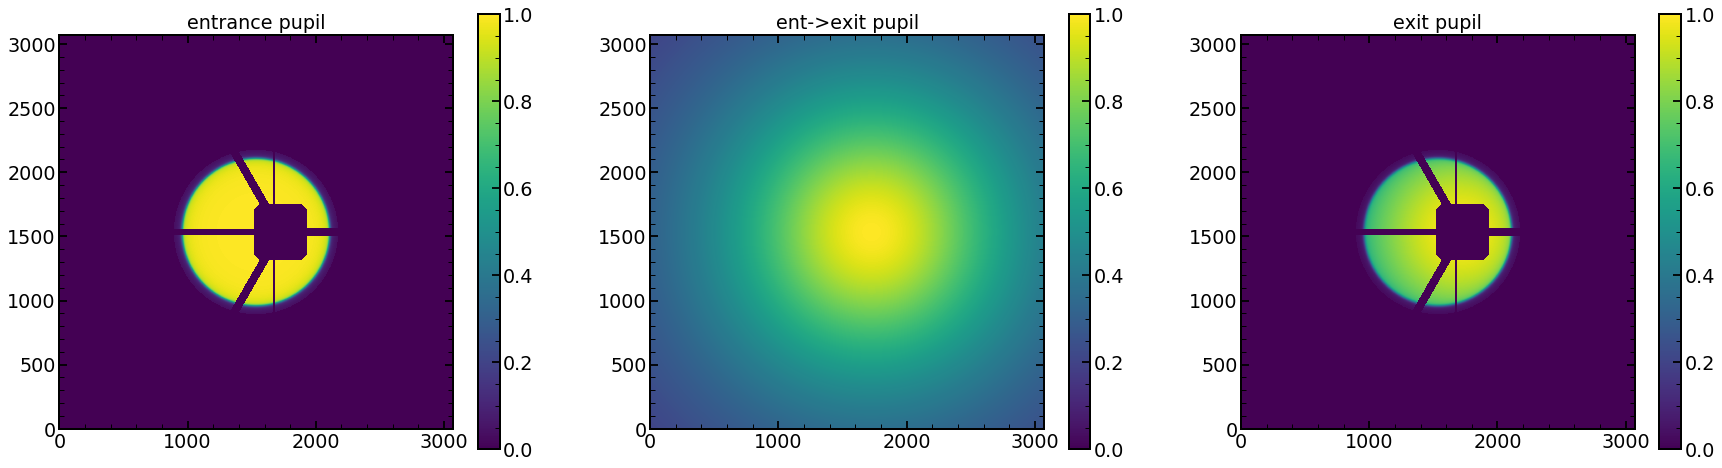

In [264]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

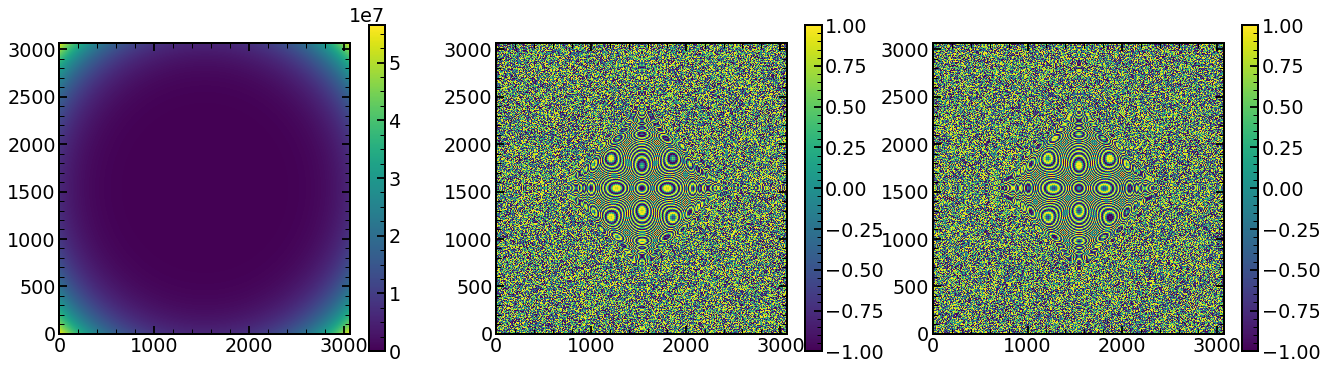

In [265]:
plt.figure(figsize=(30,6))
plt.subplot(141)
plt.imshow(wf_full)
plt.colorbar()

plt.subplot(142)
plt.imshow(np.real(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

plt.subplot(143)
plt.imshow(np.imag(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()


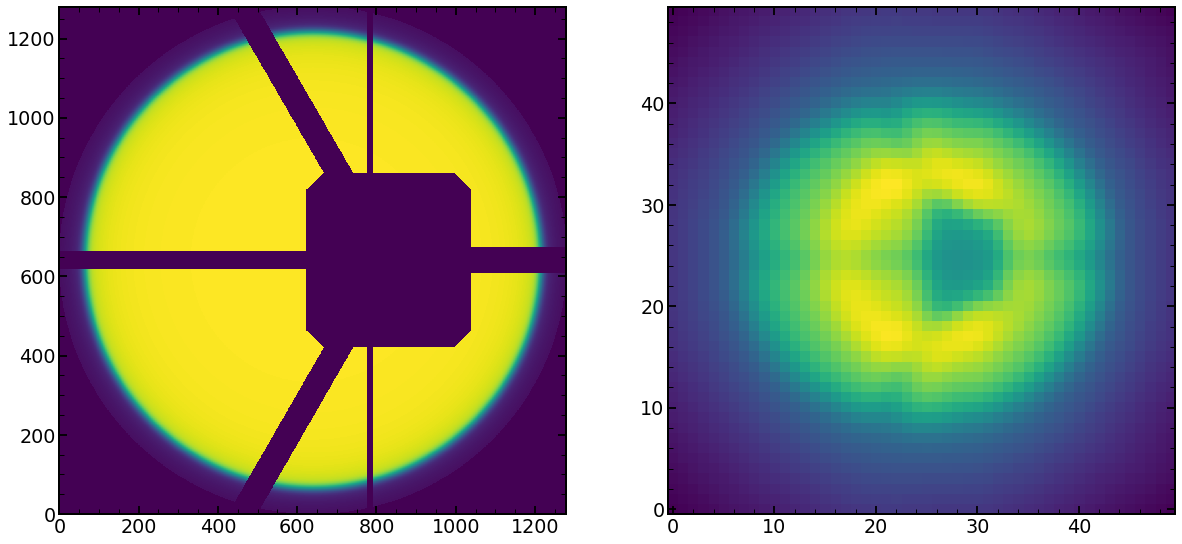

In [266]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')

# Dec 44

## Scripts

In [22]:
import pickle

with open('/Users/nevencaplar/Documents/PFS/Data_Nov_14/Dataframes/finalNe_expanded.pkl', 'rb') as f:
    finalNe=pickle.load(f)
with open('/Users/nevencaplar/Documents/PFS/Data_Nov_14/Dataframes/finalHgAr_expanded.pkl', 'rb') as f:
    finalHgAr=pickle.load(f)

list_of_HgAr_to_analyze=finalHgAr.index[(finalHgAr['fiber'].values.astype(int)<=7)&(finalHgAr['fiber'].values.astype(int)>=2)
                                        &(finalHgAr['close'].values.astype(int)==1)&(finalHgAr['wavelength'].values.astype(float)<900)&(finalHgAr['wavelength'].values.astype(float)>700)]
print(len(list_of_HgAr_to_analyze))
list_of_Ne_to_analyze=finalNe.index[(finalNe['fiber'].values.astype(float)<=7)&(finalNe['fiber'].values.astype(float)>=2)&(finalNe['close'].values.astype(float)==1)]
print(len(list_of_Ne_to_analyze))

30
24


In [26]:
#MPI
for single_spot in list_of_HgAr_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(44)+'S'+str(single_spot)+'Dec.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 13:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8555,8624,8603,8606,8573,8612,8567,8552,8627,8621,8558]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Dec_MPI44.py "+str(obs)+" "+str(single_spot)+" 40 5 HgAr\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/DecScriptToSubmitScriptsTiger44'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T'+str(44)+'S'+str(single_spot)+'Dec.sh \n')

file.close()

## Codes

In [64]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

columns_analysis=columns+['chi2','chi2max']

columns22=['z4','z5','z6','z7','z8','z9','z10','z11',
           'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

columns22_analysis=columns22+['chi2','chi2max']

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c


In [56]:
def create_minchain_err(chain0,likechain0,sci_image,var_image,old=0):
    minchain_err_test=[]
    columns=columns22
    for var_number in range(len(columns)):
        #print(var_number)
        #ravel likelihood
        likechain0_Emcee3_ravel=np.ravel(likechain0)

        # connect chain and lnchain
        chain0_Emcee3_ravel=np.ravel(chain0[:,:,var_number])
        chain0_Emcee3_ravel_argsort=np.argsort(chain0_Emcee3_ravel)  
        chain0_Emcee3_ravel_sort=chain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]
        likechain0_Emcee3_ravel_sort=likechain0_Emcee3_ravel[chain0_Emcee3_ravel_argsort]

        # move to chi2 space
        chi2_Emcee3_ravel_sort=-(np.array(likechain0_Emcee3_ravel_sort)*(2)-np.log(2*np.pi*np.sum(var_image)))/(sci_image.shape[0])**2
        min_chi2_Emcee3_ravel_sort=np.min(chi2_Emcee3_ravel_sort)

        # simplest standard deviation
        std_chain=np.std(chain0_Emcee3_ravel_sort)

        #best solution
        mean_chain=chain0_Emcee3_ravel_sort[chi2_Emcee3_ravel_sort==np.min(chi2_Emcee3_ravel_sort)][0]

        # step size
        step=std_chain/10

        # create result 3*std in each direction
        try:
            res=[]
            if step==0:
                step=10e-17
            for i in np.arange(mean_chain-30*step,mean_chain+30*step,step):
                selected_chi2_Emcee3_ravel_sort=chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))]
                if len(selected_chi2_Emcee3_ravel_sort>10):   
                    res.append([i+step/2,np.min(chi2_Emcee3_ravel_sort[(np.array(chain0_Emcee3_ravel_sort<i+step)&np.array(chain0_Emcee3_ravel_sort>i))])])

            res=np.array(res)

            #print(columns[var_number]+' min : '+str(mean_chain))
            #print(columns[var_number]+' std : '+str(std_chain))

            # find low limit and high limit
            res_within2_chi=res[res[:,1]<min_chi2_Emcee3_ravel_sort*2]
            minchain_err_element=[-np.abs(mean_chain-res_within2_chi[0,0]),np.abs(res_within2_chi[-1,0]-mean_chain)]
        except IndexError:
            if var_number!=25:
                print(columns[var_number]+': failed!')
                minchain_err_element=[-mean_chain,mean_chain]

        minchain_err_test.append(minchain_err_element)
        #print(columns[var_number]+' min_err : '+str(minchain_err_element[0]))
        #print(columns[var_number]+' max_err : '+str(minchain_err_element[1]))
    if old==1:
        minchain_err_test=np.mean(np.abs(np.array(minchain_err_test)),axis=1)
        #print(minchain_err_test)
        return minchain_err_test
    else:       
        return np.array(minchain_err_test)
    
    
import scipy.optimize as optimize
def curve_fit_custom_lin(V,index_arr,z4_arr,z4_arr_err_low,z4_arr_err_up):
    a,b=V
    yfit=lin_fit_1D(index_arr,a,b)
    weight=np.ones_like(yfit)
    weight[yfit>z4_arr]=z4_arr_err_up[yfit>z4_arr] # if the fit point is above the measure, use upper weight
    weight[yfit<=z4_arr]=z4_arr_err_low[yfit<=z4_arr] # else use lower weight
    return (yfit-z4_arr)**2/weight**2

def curve_fit_custom_con(V,index_arr,z4_arr,z4_arr_err_low,z4_arr_err_up):
    a=V
    yfit=lin_fit_1DConstant(index_arr,a)
    weight=np.ones_like(yfit)
    weight[yfit>z4_arr]=z4_arr_err_up[yfit>z4_arr] # if the fit point is above the measure, use upper weight
    weight[yfit<=z4_arr]=z4_arr_err_low[yfit<=z4_arr] # else use lower weight
    return (yfit-z4_arr)**2/weight**2 

In [59]:
def create_results_of_fit_single(date,single_number,arc=None,zMax=None):
    """create solution from a single image, create error and lower and upper erros

    @param[in] date             date when the analysis was conducted
    @param[in] single_number    number of the image
    @param[in] arc              which arc was analyzed
    @returns       results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper to be fed to solution_at_0_and_plots
    """
    print(zMax)
    if arc is None:
        arc='HgAr'
        
    if arc=='HgAr':
        obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
    elif arc=='Ne':
        obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])+90
        
    if zMax==22:
        columns_analysis=columns22_analysis
    
    results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single_lower=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)
    err_results_of_fit_single_upper=pd.DataFrame(np.zeros((18,len(columns_analysis))).reshape(-1,len(columns_analysis)),index=['-4.0','-3.5','-3.0','-2.5','-2','-1.5','-1','-0.5','0','0','0.5','1','1.5','2','2.5','3.0','3.5','4'],columns=columns_analysis)

    # arrange all results in one pandas 
    #date='Sep19'
    #date='Sep27'
    RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/'+str(date)+'/'

    single_defocus_list=obs_possibilites

    #single_number=55
    image_index=single_number
    method='P'
    eps=5

    res_likelihood=[]

    for single_defocus in range(0,len(single_defocus_list)):
        try:
            obs=single_defocus_list[single_defocus]
            try:
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee3.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee3.npy')
                print(str(single_number)+' obs (Emcee3): '+str(obs)+' is found!')
            except:    
                chain=np.load(RESULT_FOLDER+'chain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee2.npy')
                likechain=np.load(RESULT_FOLDER+'likechain'+str(date)+'_Single_'+str(method)+'_'+str(obs)+str(single_number)+str(eps)+str(arc)+'Emcee2.npy')
                print(str(single_number)+'obs (Emcee2): '+str(obs)+' is found!')

            if obs==8600:
                sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked_Dithered.npy')
                var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked_Dithered.npy')
            else:       
                sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
                var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
                #sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
                #var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

 
            likechain0=likechain

            chain0=chain
            minchain=chain0[np.abs(likechain0)==np.min(np.abs(likechain0))][0]
            chi2reduced=2*np.min(np.abs(likechain0))/(sci_image.shape[0])**2
            #print(" test0")

            """
            minchain_err=[]
            for i in range(len(columns)):
                #minchain_err=np.append(minchain_err,np.std(chain0[:,:,i].flatten()))
                minchain_err=np.append(minchain_err,np.sqrt(chi2reduced)*np.std(chain0[:,:,i].flatten()))

            minchain_err=np.array(minchain_err)
            """
            minchain_err_old=create_minchain_err(chain0,likechain0,sci_image,var_image,old=1)
            #print(minchain_err_old)
            #print(" test1")
            minchain_err=create_minchain_err(chain0,likechain0,sci_image,var_image)
            #print(" test2")
            results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain,np.array([chi2reduced,np.mean(sci_image**2/var_image)])),axis=0)
            #print(" test3")
            #print(results_of_fit_single.iloc[single_defocus])
            err_results_of_fit_single.iloc[single_defocus]=np.concatenate((minchain_err_old,np.array([1,1])),axis=0)
            #print(" test4")
            err_results_of_fit_single_lower.iloc[single_defocus]=np.concatenate((minchain_err[:,0],np.array([1,1])),axis=0)
            #print(" test5")
            err_results_of_fit_single_upper.iloc[single_defocus]=np.concatenate((minchain_err[:,1],np.array([1,1])),axis=0)
            #print(" test6")
        
        except:
            ValueError
            print(str(single_number)+' '+str(obs)+' '+str(arc)+' is NOT found or failed!')
    #results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    #err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    #err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    #err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]              
    
    return results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper

In [57]:
def solution_at_0_and_plots(date,single_number,arc,results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper,plot=True,zMax=None):
    """create solution at the focus and plot dependence with defocu

    @param[in] date             date when the analysis was conducted
    @param[in] single_number    number of the image
    @param[in] arc              which arc was analyzed
  
    """    
    
    if zMax==22:
        columns_analysis=columns22_analysis
        columns=columns22
    
    results_of_fit_single=results_of_fit_single[np.abs(results_of_fit_single['z4'])>0]
    err_results_of_fit_single=err_results_of_fit_single[np.abs(err_results_of_fit_single['z4'])>0]
    err_results_of_fit_single_lower=err_results_of_fit_single_lower[np.abs(err_results_of_fit_single_lower['z4'])>0]
    err_results_of_fit_single_upper=err_results_of_fit_single_upper[np.abs(err_results_of_fit_single_upper['z4'])>0]    
    
    if len(results_of_fit_single)<=5:
        if zMax==22:
            solution_at_0=np.full(31+11,0)
        else:
            solution_at_0=np.full(31,0)       
        return solution_at_0
    else:
        IMAGES_FOLDER='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/'

        solution_at_0=[]

        for q in columns_analysis:

            z4_arr=np.array(results_of_fit_single[q])
            z4_arr_err=np.array(err_results_of_fit_single[q])
            z4_arr_err_up=np.array(err_results_of_fit_single_upper[q])
            z4_arr_err_low=np.array(err_results_of_fit_single_lower[q])
            index_arr=results_of_fit_single[q].index.values.astype(float)
            #print(q)
            #print(index_arr)
            #print(z4_arr)
            #print(z4_arr_err)
            #print(z4_arr_err_up)
            #print(z4_arr_err_low)
            
            z4_arr_no0=z4_arr[np.abs(index_arr)>0.5]
            z4_arr_no0_err=z4_arr_err[np.abs(index_arr)>0.5]
            z4_arr_no0_err_up=z4_arr_err_up[np.abs(index_arr)>0.5]
            z4_arr_no0_err_low=z4_arr_err_low[np.abs(index_arr)>0.5]
            index_arr_no0=index_arr[np.abs(index_arr)>0.5]
            #print(q)
            #print(index_arr_no0)
            #print(z4_arr_no0)
            #print(z4_arr_no0_err)
            #print(z4_arr_no0_err_up)
            #print(z4_arr_no0_err_low)
            
            
            z4_arr_only0=z4_arr[np.abs(index_arr)<=0.5]
            z4_arr_only0_err=z4_arr_err[np.abs(index_arr)<=0.5]
            z4_arr_only0_err_up=z4_arr_err_up[np.abs(index_arr)<=0.5] 
            z4_arr_only0_err_low=z4_arr_err_low[np.abs(index_arr)<=0.5]
            index_arr_only0=index_arr[np.abs(index_arr)<=0.5]

            fit_res=[]
            interim_zero_solutions=[]
            if q in columns[:8+11]:
                # these variables are fit via linear fit, without values at focus
                # it is z4-z11
                # for loop below removes 2 points from the fit that create largest deviations from median result in focus
                for l in range(len(index_arr_no0)):
                    #print('good_index'+str(np.delete(index_arr_no0,l)))
                    #print('index_arr_no0'+str(np.delete(z4_arr_no0,l)))
                    #print('z4_arr_no0_err_low'+str(np.delete(z4_arr_no0_err_low,l)))
                    #print('z4_arr_no0_err_up'+str(np.delete(z4_arr_no0_err_up,l)))
                    popt=optimize.leastsq(curve_fit_custom_lin,x0=[1,1],args=(np.delete(index_arr_no0,l),np.delete(z4_arr_no0,l), np.delete(z4_arr_no0_err_low,l),np.delete(z4_arr_no0_err_up,l)))[0]
                    interim_zero_solutions.append([l,lin_fit_1D(0,popt[0],popt[1])])
                interim_zero_solutions_arr=np.array(interim_zero_solutions)
                interim_zero_solutions_arr_dif=np.abs(interim_zero_solutions_arr[:,1]-np.median(interim_zero_solutions_arr[:,1]))
                second_max_dif=np.sort(interim_zero_solutions_arr_dif)[-2]
                interim_zero_solutions_arr=interim_zero_solutions_arr[interim_zero_solutions_arr_dif<second_max_dif]
                #print(interim_zero_solutions_arr[:,0])
                good_index=interim_zero_solutions_arr[:,0].astype(int)
                #print('good_index'+str(good_index))
                #print('index_arr_no0'+str(index_arr_no0))
                #print('z4_arr_no0_err_low'+str(z4_arr_no0_err_low))
                #print('z4_arr_no0_err_up'+str(z4_arr_no0_err_up))
                popt=optimize.leastsq(curve_fit_custom_lin,x0=[1,1],args=(np.array(index_arr_no0)[good_index],np.array(z4_arr_no0)[good_index],np.array(z4_arr_no0_err_low)[good_index],np.array(z4_arr_no0_err_up)[good_index]))[0]
                #print(popt)
                for i in np.linspace(-4.5,4.5,19):
                    fit_res.append(lin_fit_1D(i,popt[0],popt[1]))
                solution_at_0.append(fit_res[9])

            interim_zero_solutions=[]
            if q in columns[8+11:25+11]:
                # these variables are set at mean value (constant fit), without values at focus
                # these are variables that describe the pupil
                for l in range(len(index_arr_no0)):
                    popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(np.delete(index_arr_no0,l),np.delete(z4_arr_no0,l), np.delete(z4_arr_no0_err_low,l),np.delete(z4_arr_no0_err_up,l)))[0]
                    interim_zero_solutions.append([l,popt[0]])
                interim_zero_solutions_arr=np.array(interim_zero_solutions)
                interim_zero_solutions_arr_dif=np.abs(interim_zero_solutions_arr[:,1]-np.median(interim_zero_solutions_arr[:,1]))
                third_max_dif=np.sort(interim_zero_solutions_arr_dif)[-3]
                interim_zero_solutions_arr=interim_zero_solutions_arr[interim_zero_solutions_arr_dif<=(third_max_dif*1.1)]
                #print(interim_zero_solutions_arr[:,0])
                good_index=interim_zero_solutions_arr[:,0].astype(int)
                popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(np.array(index_arr_no0)[good_index],np.array(z4_arr_no0)[good_index],np.array(z4_arr_no0_err_low)[good_index],np.array(z4_arr_no0_err_up)[good_index]))[0]
                fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                solution_at_0.append(fit_res[9])

            if q in np.concatenate((np.array(columns[25+11:]),np.array(['chi2','chi2max'])),axis=0):
                # these variables are set at value as measured at 0 - (perhaps is should be close to 0)
                if z4_arr_only0.size==1:
                    for i in np.linspace(-4.5,4.5,19):
                        fit_res.append(z4_arr_only0) 
                    solution_at_0.append(fit_res[9])
                else:
                    # these variables are set at mean value (constant fit), without values at focus
                    popt=optimize.leastsq(curve_fit_custom_con,x0=[1],args=(index_arr_only0, z4_arr_only0, z4_arr_only0_err_low,z4_arr_only0_err_up))[0]
                    fit_res=lin_fit_1DConstant(np.linspace(-4.5,4.5,19),popt[0])
                    solution_at_0.append(fit_res[9])


            #making plots here
            ######
            #print(q)
            #print(fit_res)
            plt.figure(figsize=(20,10))
            plt.errorbar(index_arr,z4_arr,yerr=[np.abs(z4_arr_err_low),z4_arr_err_up],color='blue',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='single fit results')
            plt.plot(np.linspace(-4.5,4.5,19),fit_res,color='orange',label='fit')
            if q in columns[:8]:
                plt.plot(np.linspace(-4.5,4.5,19),np.zeros((19,1)),':',color='black')
            plt.plot([0], [fit_res[9]], marker='o', markersize=10, color="red",label='prediction for focus')
            #print('prediction for focus: '+str(q)+' '+str(fit_res[9]))
            plt.title(q,size=40)
            plt.legend(fontsize=25)
            plt.xlabel('defocus lab [mm]',size=30)
            plt.ylabel('defocus model',size=30)
            #print(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(single_number)+'/'+str(arc)+str(q))

            if not os.path.exists(IMAGES_FOLDER+'Defocus/'+str(q)+'/'):
                os.makedirs(IMAGES_FOLDER+'Defocus/'+str(q)+'/')
            plt.savefig(IMAGES_FOLDER+'Defocus/'+str(q)+'/'+str(arc)+str(single_number))

            plt.close()   
            ######

        solution_at_0=np.array(solution_at_0)[:len(solution_at_0)-2]
        return solution_at_0

## Look at the results at one point  - defocused analysis

In [267]:
date='Dec44'
obs=str(8624)
single_number='66'
image_index=int(single_number)
eps=5
arc='HgAr'


STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/Data_Nov_14/Stamps_cleaned/"

if arc=="HgAr":
    single_number_focus=8603
elif arc=="Ne":
    single_number_focus=8693    
else:
    print("Not recognized arc-line")

if arc=='HgAr':
    obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
elif arc=='Ne':
    obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])+90
    
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]

if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

if arc=="HgAr":
    finalArc=finalHgAr
elif arc=="Ne":
    finalArc=finalNe    
else:
    print("Not recognized arc-line")    
        
finalArc.loc[int(single_number)]

fiber                     5
xc                     2088
yc                     1950
wavelength         795.0522
close                     1
lamp                   HgAr
xc_effective           2157
old_index                55
old_index_aprox          55
Name: 66, dtype: object

In [268]:
list_of_masks=create_mask(sci_image_focus_large)
diagonal_cross=list_of_masks[3]
res_diagonal_cross_large=create_res_data(sci_image_focus_large,diagonal_cross,custom_cent=True,size_pixel=15)
distances_large=range(len(res_diagonal_cross_large))
last_distance=np.array(distances_large[101:])[np.log10(res_diagonal_cross_large[101:])>0.5][-1]
# if the average is below 0 terminate at that position

where_are_NaNs=np.isnan(np.log10(np.array(res_diagonal_cross_large[101:])))
if np.sum(where_are_NaNs)>0:
    first_NaN_position=np.array(distances_large[101:])[where_are_NaNs][0]
else:
    first_NaN_position=last_distance
last_distance=np.min([first_NaN_position,last_distance]) -1

z=np.polyfit(np.log10(np.array(distances_large[101:last_distance])),np.log10(np.array(res_diagonal_cross_large)[101:last_distance]),1)
deduced_scattering_slope=z[0]-0.05
print("deduced_scattering_slope: "+str(deduced_scattering_slope))

deduced_scattering_slope: -2.0909030783842426


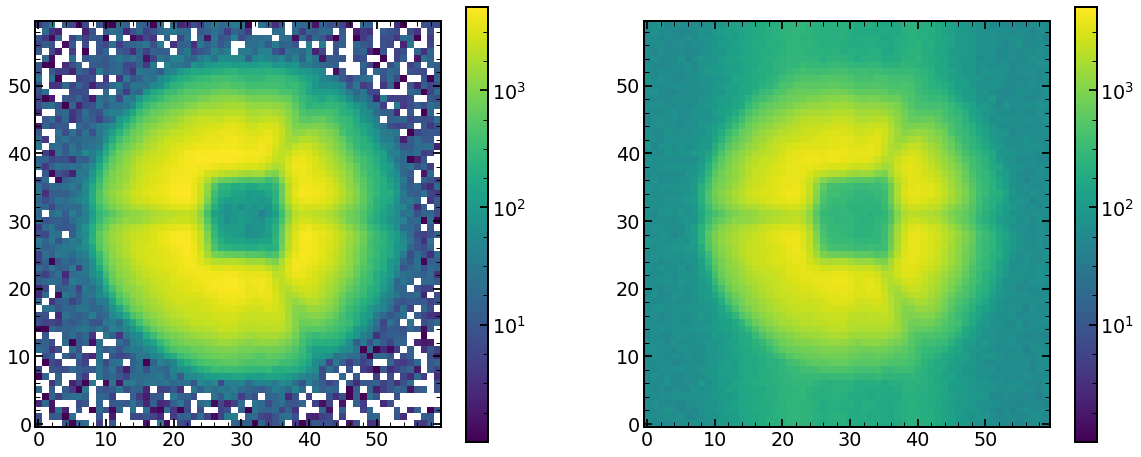

In [269]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(122)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])


In [270]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()

minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 5423.629487053347
minimal chi2 reduced is: 3.0084949227239526


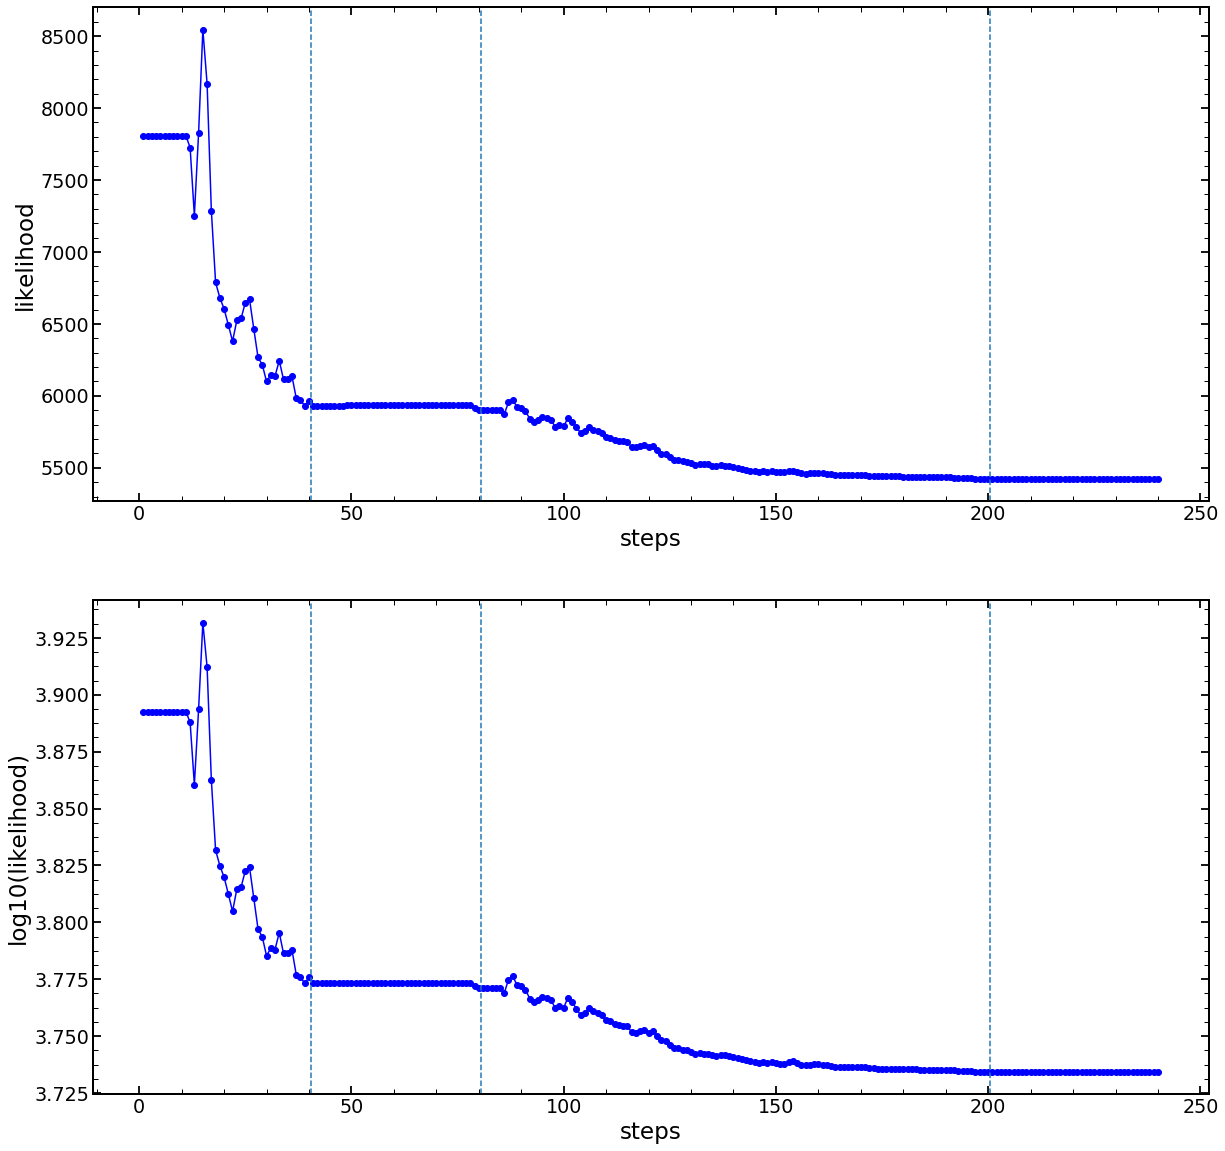

In [271]:
size=40

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(size*2+0.5,ls='--')
plt.axvline(size*5+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-',marker='o')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(2*size+0.5,ls='--')
plt.axvline(5*size+0.5,ls='--')

In [281]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22)   
       
model(minchain)

zmax: 22


-5535.787801579565

In [273]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

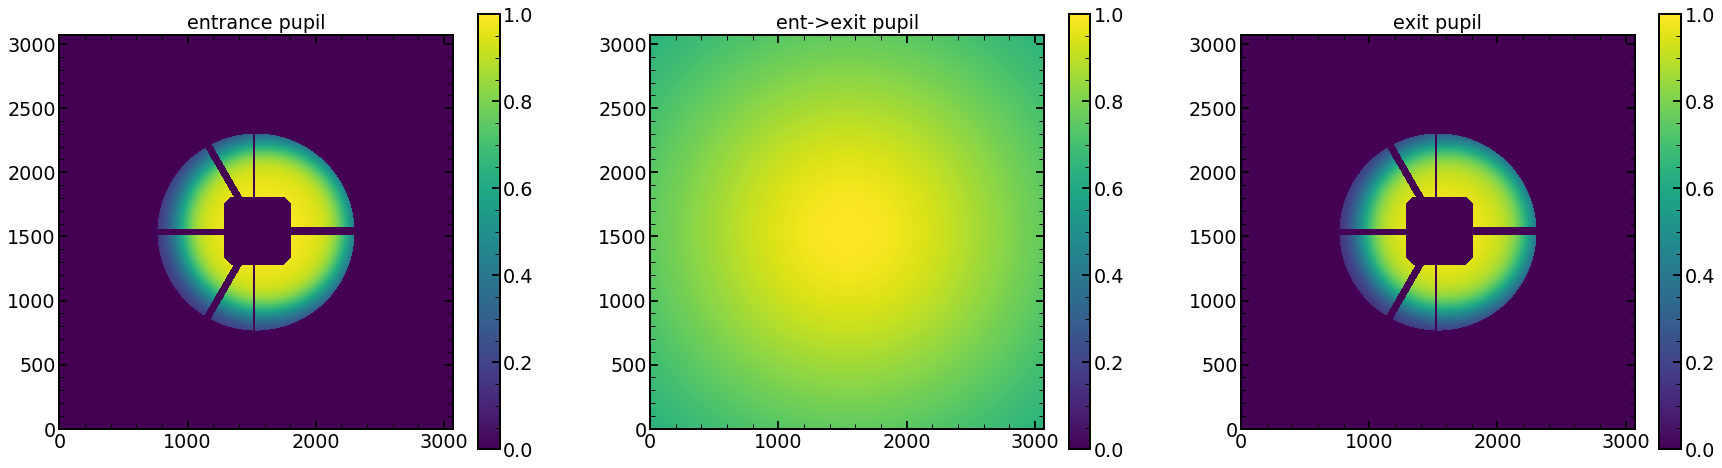

In [274]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

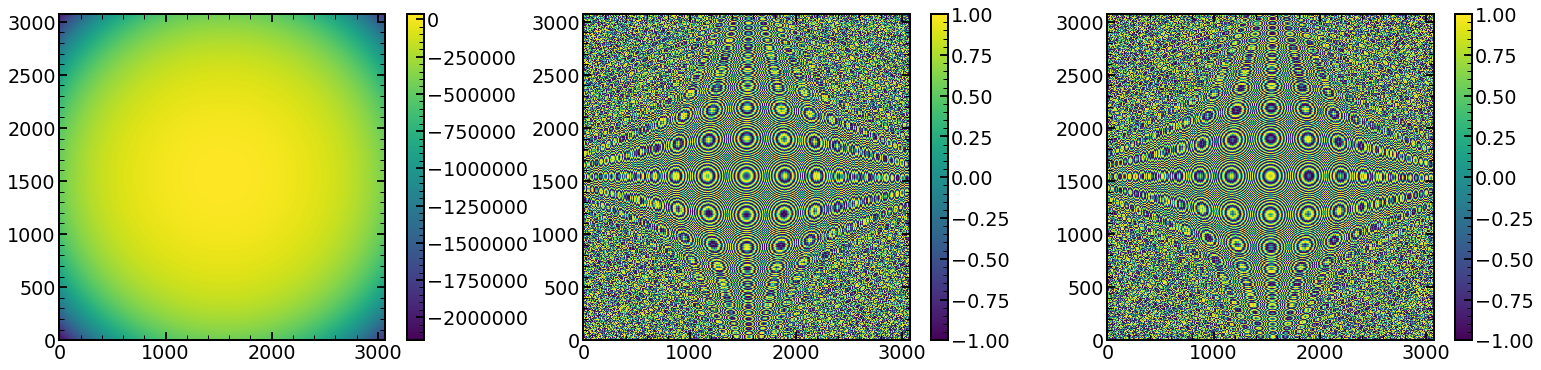

In [275]:
plt.figure(figsize=(36,6))
plt.subplot(141)
plt.imshow(wf_full)
plt.colorbar()

plt.subplot(142)
plt.imshow(np.real(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

plt.subplot(143)
plt.imshow(np.imag(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()


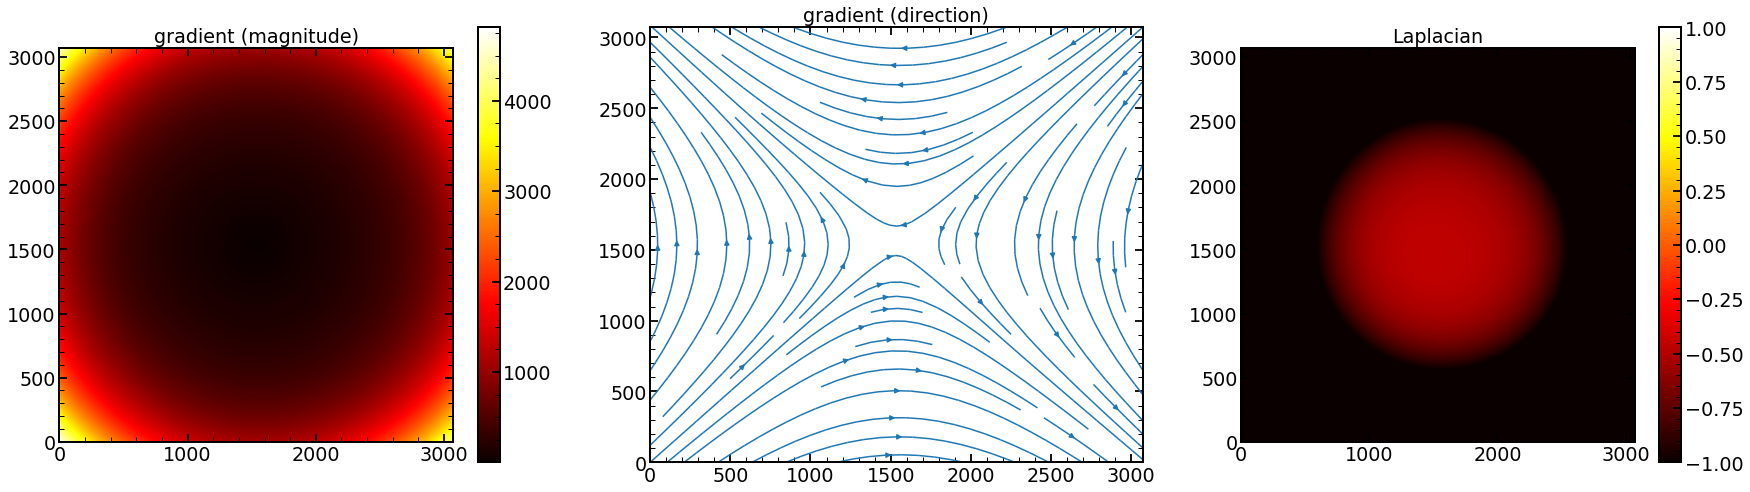

In [276]:
plt.figure(figsize=(30,8))
plt.subplot(131)
vgrad = np.gradient(wf_full)
fulgrad = np.sqrt(vgrad[0]**2 + vgrad[1]**2)
plt.title('gradient (magnitude)')
plt.imshow(fulgrad,cmap=plt.get_cmap('hot'), vmin = np.amin(fulgrad),vmax = np.amax(fulgrad))  
plt.colorbar()
plt.subplot(132)
x, y = range(0, len(wf_full)), range(0,len(wf_full))
xi, yi = np.meshgrid(x, y)
plt.title('gradient (direction)')
plt.streamplot(xi, yi, vgrad[0], vgrad[1])
plt.subplot(133)
laplace_of_wf = scipy.ndimage.filters.laplace(wf_full)
plt.title('Laplacian')
plt.imshow(laplace_of_wf,cmap=plt.get_cmap('hot'), vmin = -1,vmax = 1) 
plt.colorbar()


chi**2 reduced is: 3.0708050930577993
Abs of residual divided by total flux is: 0.046639378398127214
Abs of residual divided by largest value of a flux in the image is: 0.10486265333372734


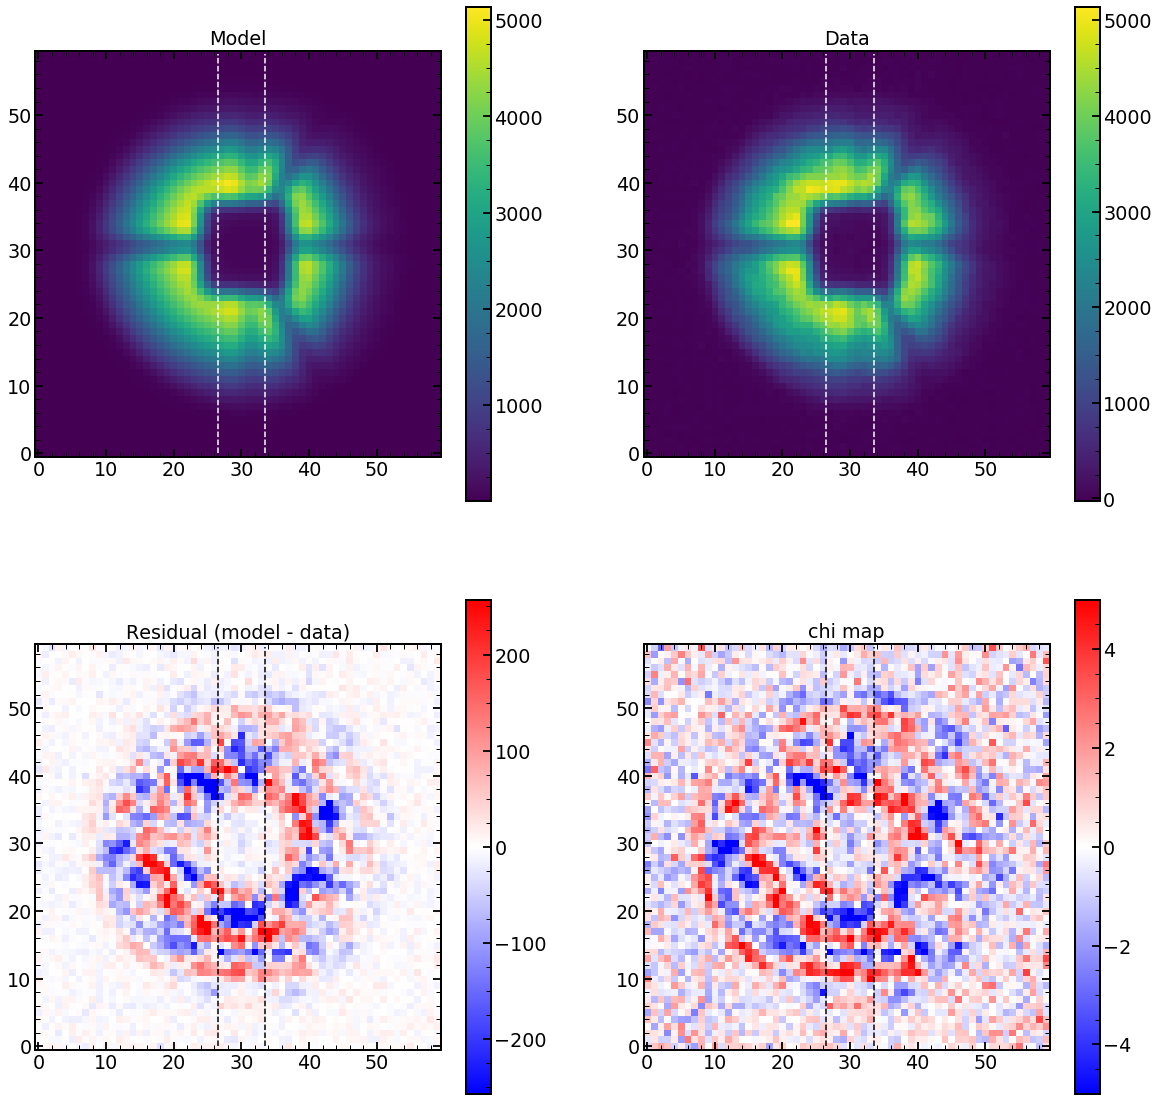

In [277]:
single_analysis.create_basic_comparison_plot()

3.0708050930577993
chi**2 reduced is: 3.0708050930577993
Abs of residual divided by total flux is: 0.046639378398127214
Abs of residual divided by largest value of a flux in the image is: 0.10486265333372734


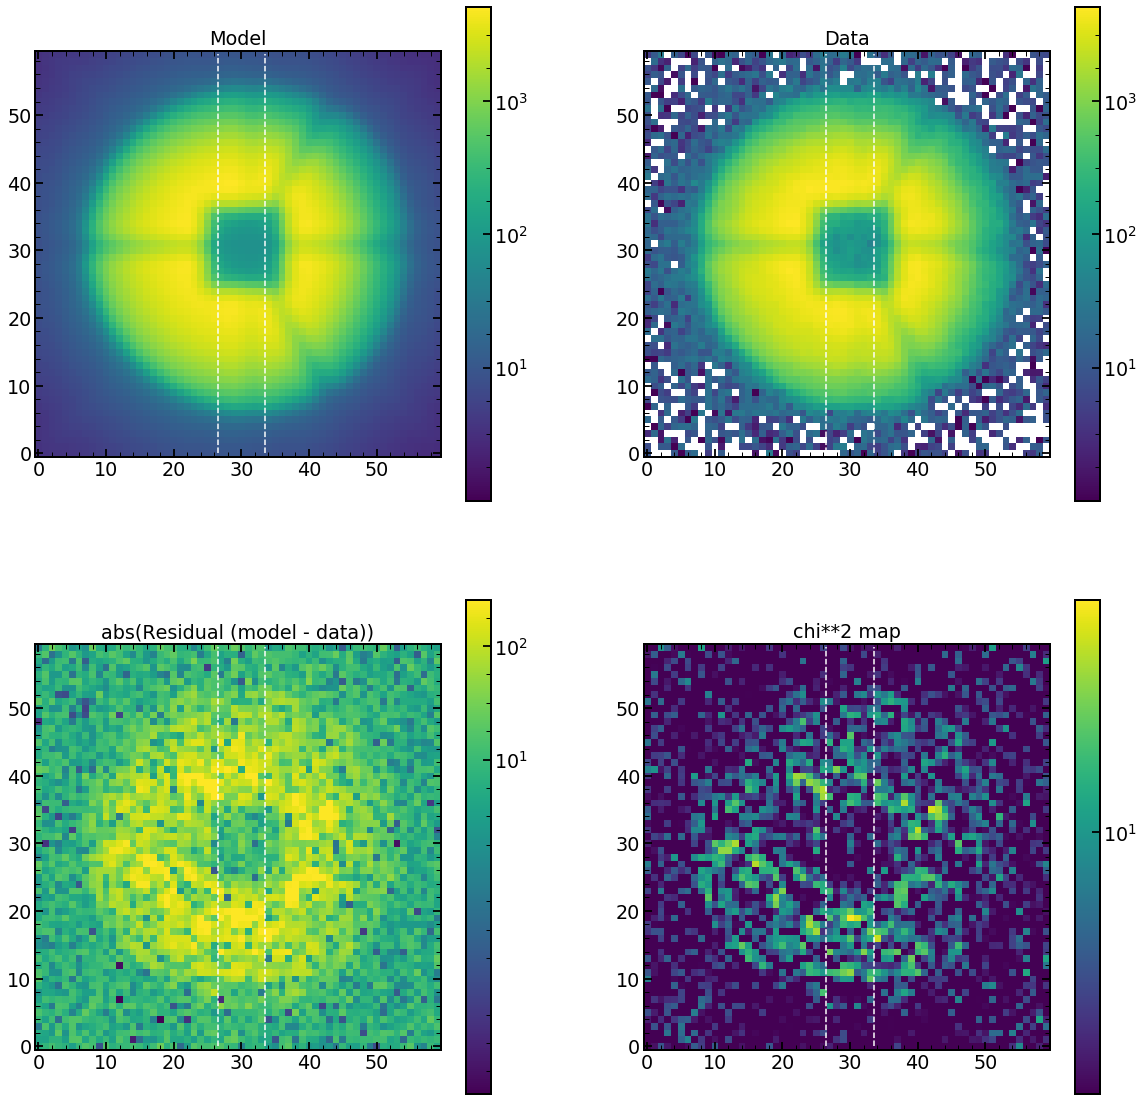

In [278]:
single_analysis.create_basic_comparison_plot_log()

3.0708050930577993


0.046639378398127214

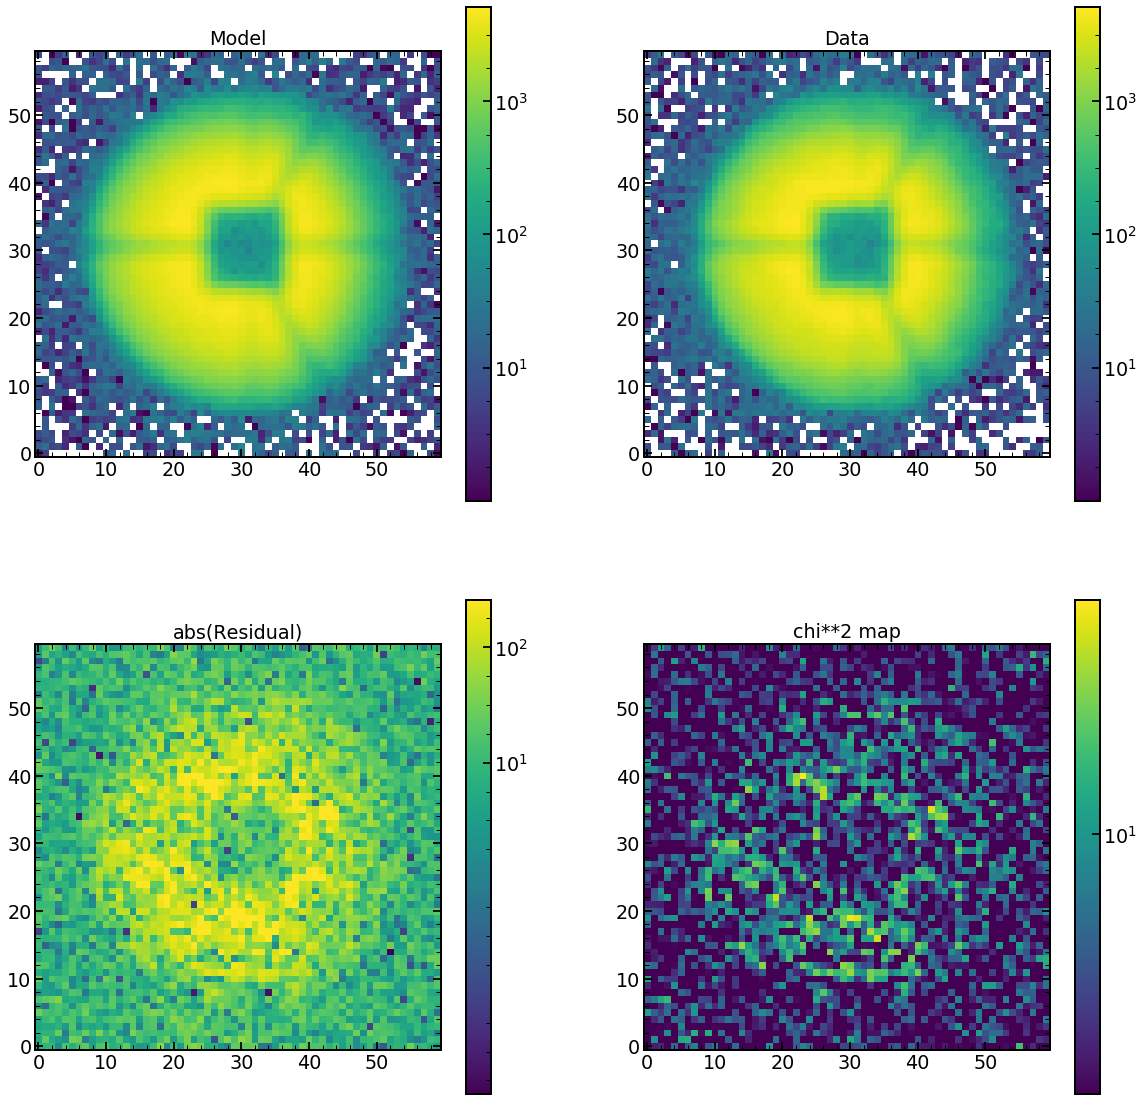

In [279]:
artifical_noise=single_analysis.create_artificial_noise()
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(res_iapetus+artifical_noise,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.title('Model')
plt.grid(False)
plt.subplot(222)
plt.imshow(sci_image,origin='lower',vmin=1,vmax=np.max(np.abs(sci_image)),norm=LogNorm())
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.title('Data')
plt.grid(False)
plt.subplot(223)
plt.imshow(np.abs(res_iapetus+artifical_noise-sci_image),origin='lower',vmax=np.max(np.abs(sci_image))/20,norm=LogNorm())
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.title('abs(Residual)')
plt.grid(False)
plt.subplot(224)
plt.imshow((res_iapetus+artifical_noise-sci_image)**2/((1)*var_image),origin='lower',vmin=1,norm=LogNorm())
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])
plt.title('chi**2 map')
print(np.sum((res_iapetus-sci_image)**2/((var_image.shape[0]*var_image.shape[1])*var_image)))
np.sum(np.abs((res_iapetus-sci_image)))/np.sum((res_iapetus))

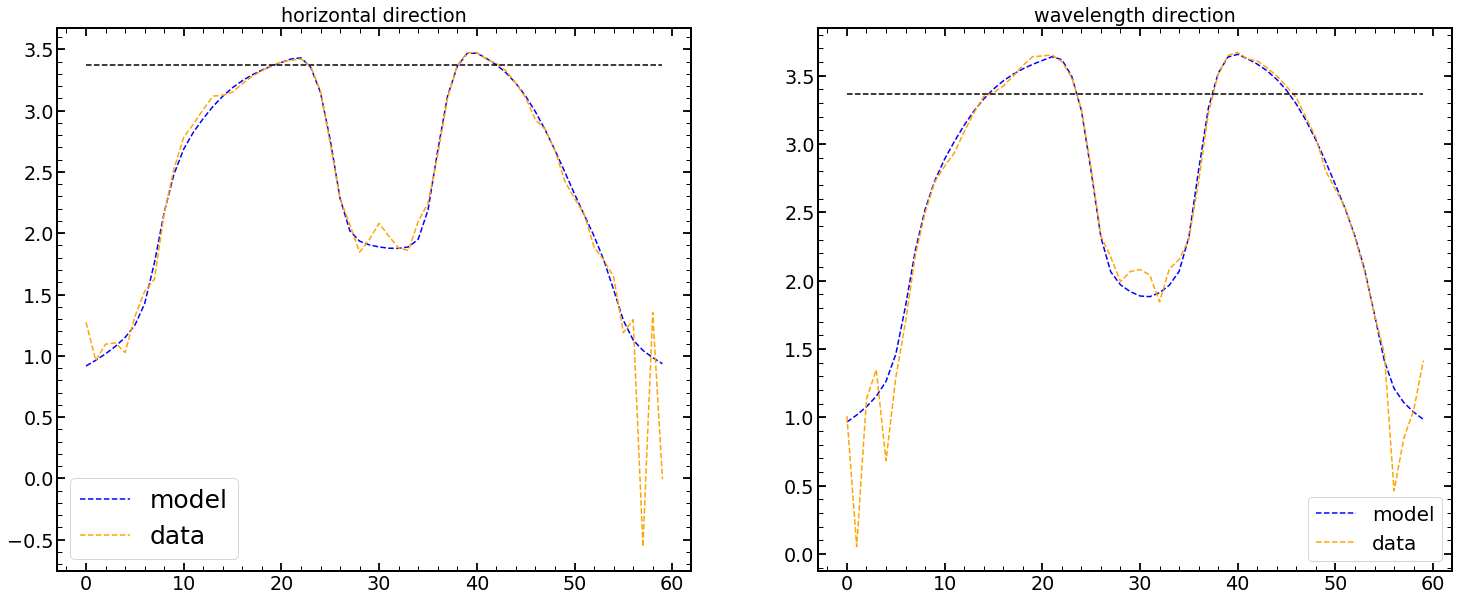

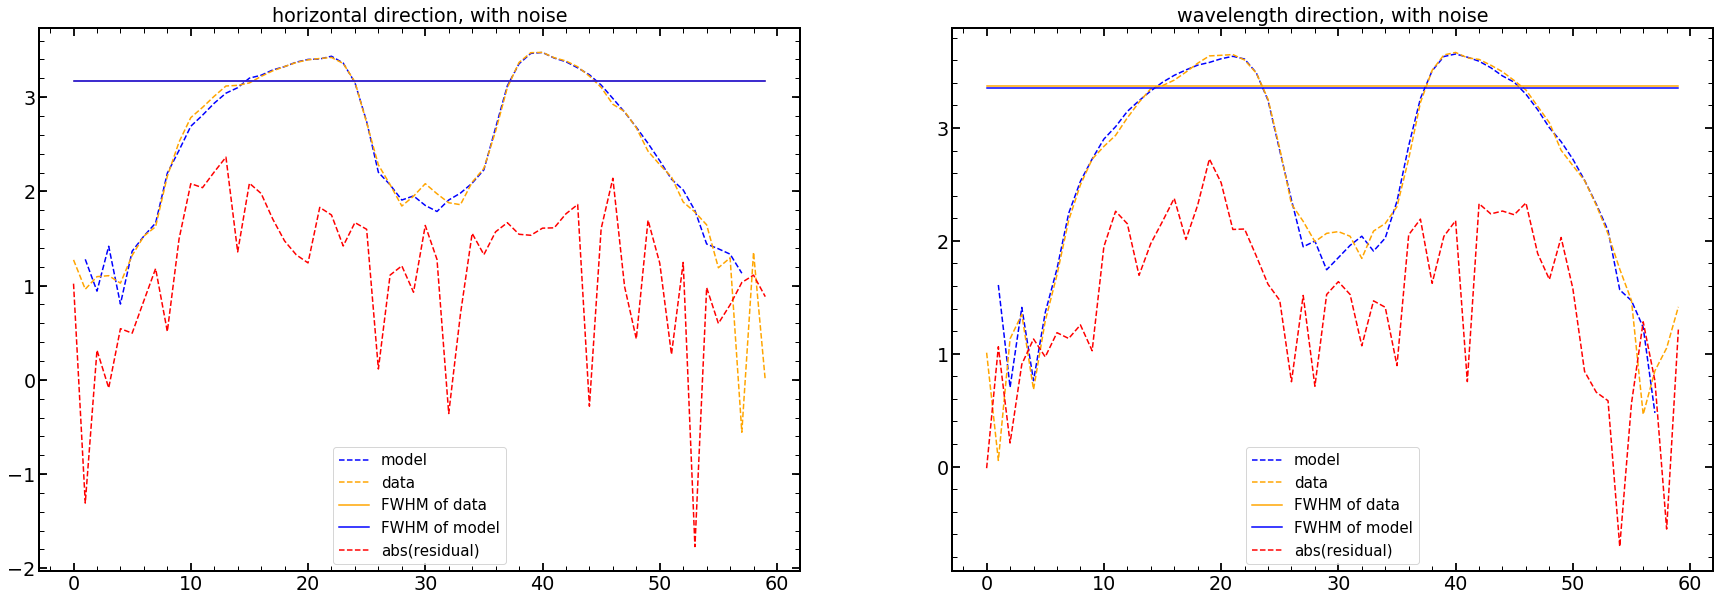

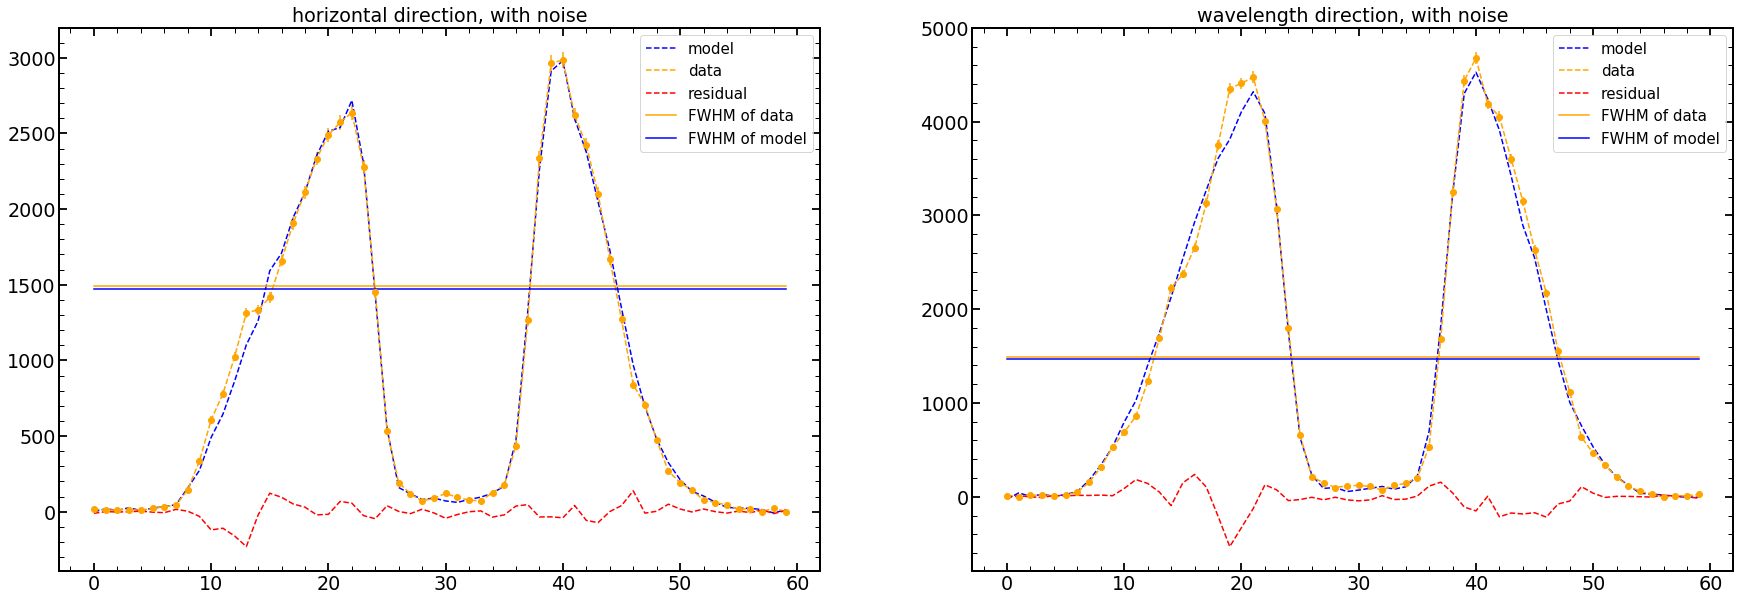

In [280]:
single_analysis.create_cut_plots()

##  Core Analysis (pandas dataframe creation)


### Defocus plots 

In [62]:
for i in tqdm(range(len(finalHgAr))):
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=create_results_of_fit_single('Dec44',i,'HgAr',22)
    solution_at_0=solution_at_0_and_plots('Dec44',i,'HgAr',results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper,'True',22)

 12%|█▎        | 15/120 [00:00<00:00, 149.59it/s]

22
0 8552 HgAr is NOT found or failed!
0 8555 HgAr is NOT found or failed!
0 8558 HgAr is NOT found or failed!
0 8561 HgAr is NOT found or failed!
0 8564 HgAr is NOT found or failed!
0 8567 HgAr is NOT found or failed!
0 8570 HgAr is NOT found or failed!
0 8573 HgAr is NOT found or failed!
0 8603 HgAr is NOT found or failed!
0 8600 HgAr is NOT found or failed!
0 8606 HgAr is NOT found or failed!
0 8609 HgAr is NOT found or failed!
0 8612 HgAr is NOT found or failed!
0 8615 HgAr is NOT found or failed!
0 8618 HgAr is NOT found or failed!
0 8621 HgAr is NOT found or failed!
0 8624 HgAr is NOT found or failed!
0 8627 HgAr is NOT found or failed!
22
1 8552 HgAr is NOT found or failed!
1 8555 HgAr is NOT found or failed!
1 8558 HgAr is NOT found or failed!
1 8561 HgAr is NOT found or failed!
1 8564 HgAr is NOT found or failed!
1 8567 HgAr is NOT found or failed!
1 8570 HgAr is NOT found or failed!
1 8573 HgAr is NOT found or failed!
1 8603 HgAr is NOT found or failed!
1 8600 HgAr is NOT fou

27 obs (Emcee3): 8555 is found!
27obs (Emcee2): 8558 is found!
27 8561 HgAr is NOT found or failed!
27 8564 HgAr is NOT found or failed!
27 obs (Emcee3): 8567 is found!
27 8570 HgAr is NOT found or failed!
27 obs (Emcee3): 8573 is found!
27 obs (Emcee3): 8603 is found!
27 8600 HgAr is NOT found or failed!
27 obs (Emcee3): 8606 is found!
27 8609 HgAr is NOT found or failed!
27 obs (Emcee3): 8612 is found!
27 8615 HgAr is NOT found or failed!
27 8618 HgAr is NOT found or failed!
27 obs (Emcee3): 8621 is found!
27 obs (Emcee3): 8624 is found!
27 obs (Emcee3): 8627 is found!


 23%|██▎       | 28/120 [00:23<01:15,  1.21it/s] 

22
28 8552 HgAr is NOT found or failed!
28 8555 HgAr is NOT found or failed!
28 8558 HgAr is NOT found or failed!
28 8561 HgAr is NOT found or failed!
28 8564 HgAr is NOT found or failed!
28 8567 HgAr is NOT found or failed!
28 8570 HgAr is NOT found or failed!
28 8573 HgAr is NOT found or failed!
28 8603 HgAr is NOT found or failed!
28 8600 HgAr is NOT found or failed!
28 8606 HgAr is NOT found or failed!
28 8609 HgAr is NOT found or failed!
28 8612 HgAr is NOT found or failed!
28 8615 HgAr is NOT found or failed!
28 8618 HgAr is NOT found or failed!
28 8621 HgAr is NOT found or failed!
28 8624 HgAr is NOT found or failed!
28 8627 HgAr is NOT found or failed!
22
29 obs (Emcee3): 8552 is found!
29 obs (Emcee3): 8555 is found!
29 obs (Emcee3): 8558 is found!
29 8561 HgAr is NOT found or failed!
29 8564 HgAr is NOT found or failed!
29 obs (Emcee3): 8567 is found!
29 8570 HgAr is NOT found or failed!
29 obs (Emcee3): 8573 is found!
29 obs (Emcee3): 8603 is found!
29 8600 HgAr is NOT found

 25%|██▌       | 30/120 [00:45<02:15,  1.50s/it]

22
30 obs (Emcee3): 8552 is found!
30 obs (Emcee3): 8555 is found!
30 obs (Emcee3): 8558 is found!
30 8561 HgAr is NOT found or failed!
30 8564 HgAr is NOT found or failed!
30 obs (Emcee3): 8567 is found!
30 8570 HgAr is NOT found or failed!
30 obs (Emcee3): 8573 is found!
30 obs (Emcee3): 8603 is found!
30 8600 HgAr is NOT found or failed!
30 obs (Emcee3): 8606 is found!
30 8609 HgAr is NOT found or failed!
30 obs (Emcee3): 8612 is found!
30 8615 HgAr is NOT found or failed!
30 8618 HgAr is NOT found or failed!
30 obs (Emcee3): 8621 is found!
30 obs (Emcee3): 8624 is found!
30 obs (Emcee3): 8627 is found!


 26%|██▌       | 31/120 [01:07<03:14,  2.19s/it]

22
31 obs (Emcee3): 8552 is found!
31 obs (Emcee3): 8555 is found!
31 obs (Emcee3): 8558 is found!
31 8561 HgAr is NOT found or failed!
31 8564 HgAr is NOT found or failed!
31 obs (Emcee3): 8567 is found!
31 8570 HgAr is NOT found or failed!
31 obs (Emcee3): 8573 is found!
31 obs (Emcee3): 8603 is found!
31 8600 HgAr is NOT found or failed!
31 obs (Emcee3): 8606 is found!
31 8609 HgAr is NOT found or failed!
31 obs (Emcee3): 8612 is found!
31 8615 HgAr is NOT found or failed!
31 8618 HgAr is NOT found or failed!
31 obs (Emcee3): 8621 is found!
31 obs (Emcee3): 8624 is found!
31 obs (Emcee3): 8627 is found!


 27%|██▋       | 32/120 [01:32<04:13,  2.89s/it]

22
32 obs (Emcee3): 8552 is found!
32 obs (Emcee3): 8555 is found!
32 obs (Emcee3): 8558 is found!
32 8561 HgAr is NOT found or failed!
32 8564 HgAr is NOT found or failed!
32 obs (Emcee3): 8567 is found!
32 8570 HgAr is NOT found or failed!
32 obs (Emcee3): 8573 is found!
32 obs (Emcee3): 8603 is found!
32 8600 HgAr is NOT found or failed!
32 obs (Emcee3): 8606 is found!
32 8609 HgAr is NOT found or failed!
32 obs (Emcee3): 8612 is found!
32 8615 HgAr is NOT found or failed!
32 8618 HgAr is NOT found or failed!
32 obs (Emcee3): 8621 is found!
32 obs (Emcee3): 8624 is found!
32 obs (Emcee3): 8627 is found!


 28%|██▊       | 33/120 [01:55<05:03,  3.49s/it]

22
33 8552 HgAr is NOT found or failed!
33 8555 HgAr is NOT found or failed!
33 8558 HgAr is NOT found or failed!
33 8561 HgAr is NOT found or failed!
33 8564 HgAr is NOT found or failed!
33 8567 HgAr is NOT found or failed!
33 8570 HgAr is NOT found or failed!
33 8573 HgAr is NOT found or failed!
33 8603 HgAr is NOT found or failed!
33 8600 HgAr is NOT found or failed!
33 8606 HgAr is NOT found or failed!
33 8609 HgAr is NOT found or failed!
33 8612 HgAr is NOT found or failed!
33 8615 HgAr is NOT found or failed!
33 8618 HgAr is NOT found or failed!
33 8621 HgAr is NOT found or failed!
33 8624 HgAr is NOT found or failed!
33 8627 HgAr is NOT found or failed!
22
34 8552 HgAr is NOT found or failed!
34 8555 HgAr is NOT found or failed!
34 8558 HgAr is NOT found or failed!
34 8561 HgAr is NOT found or failed!
34 8564 HgAr is NOT found or failed!
34 8567 HgAr is NOT found or failed!
34 8570 HgAr is NOT found or failed!
34 8573 HgAr is NOT found or failed!
34 8603 HgAr is NOT found or fai

 33%|███▎      | 40/120 [02:18<04:37,  3.46s/it]

22
40 8552 HgAr is NOT found or failed!
40 8555 HgAr is NOT found or failed!
40 8558 HgAr is NOT found or failed!
40 8561 HgAr is NOT found or failed!
40 8564 HgAr is NOT found or failed!
40 8567 HgAr is NOT found or failed!
40 8570 HgAr is NOT found or failed!
40 8573 HgAr is NOT found or failed!
40 8603 HgAr is NOT found or failed!
40 8600 HgAr is NOT found or failed!
40 8606 HgAr is NOT found or failed!
40 8609 HgAr is NOT found or failed!
40 8612 HgAr is NOT found or failed!
40 8615 HgAr is NOT found or failed!
40 8618 HgAr is NOT found or failed!
40 8621 HgAr is NOT found or failed!
40 8624 HgAr is NOT found or failed!
40 8627 HgAr is NOT found or failed!
22
41 obs (Emcee3): 8552 is found!
41 obs (Emcee3): 8555 is found!
41 obs (Emcee3): 8558 is found!
41 8561 HgAr is NOT found or failed!
41 8564 HgAr is NOT found or failed!
41 obs (Emcee3): 8567 is found!
41 8570 HgAr is NOT found or failed!
41 obs (Emcee3): 8573 is found!
41 obs (Emcee3): 8603 is found!
41 8600 HgAr is NOT found

 35%|███▌      | 42/120 [02:41<04:59,  3.83s/it]

22
42 obs (Emcee3): 8552 is found!
42 obs (Emcee3): 8555 is found!
42 obs (Emcee3): 8558 is found!
42 8561 HgAr is NOT found or failed!
42 8564 HgAr is NOT found or failed!
42 obs (Emcee3): 8567 is found!
42 8570 HgAr is NOT found or failed!
42 obs (Emcee3): 8573 is found!
42 obs (Emcee3): 8603 is found!
42 8600 HgAr is NOT found or failed!
42 obs (Emcee3): 8606 is found!
42 8609 HgAr is NOT found or failed!
42 obs (Emcee3): 8612 is found!
42 8615 HgAr is NOT found or failed!
42 8618 HgAr is NOT found or failed!
42 obs (Emcee3): 8621 is found!
42 obs (Emcee3): 8624 is found!
42 obs (Emcee3): 8627 is found!


 36%|███▌      | 43/120 [03:04<05:30,  4.29s/it]

22
43 obs (Emcee3): 8552 is found!
43 obs (Emcee3): 8555 is found!
43 obs (Emcee3): 8558 is found!
43 8561 HgAr is NOT found or failed!
43 8564 HgAr is NOT found or failed!
43 obs (Emcee3): 8567 is found!
43 8570 HgAr is NOT found or failed!
43 obs (Emcee3): 8573 is found!
43 obs (Emcee3): 8603 is found!
43 8600 HgAr is NOT found or failed!
43 obs (Emcee3): 8606 is found!
43 8609 HgAr is NOT found or failed!
43 obs (Emcee3): 8612 is found!
43 8615 HgAr is NOT found or failed!
43 8618 HgAr is NOT found or failed!
43 obs (Emcee3): 8621 is found!
43 obs (Emcee3): 8624 is found!
43 obs (Emcee3): 8627 is found!


 37%|███▋      | 44/120 [03:25<05:55,  4.68s/it]

22
44 obs (Emcee3): 8552 is found!
44 obs (Emcee3): 8555 is found!
44 obs (Emcee3): 8558 is found!
44 8561 HgAr is NOT found or failed!
44 8564 HgAr is NOT found or failed!
44 obs (Emcee3): 8567 is found!
44 8570 HgAr is NOT found or failed!
44 obs (Emcee3): 8573 is found!
44 obs (Emcee3): 8603 is found!
44 8600 HgAr is NOT found or failed!
44 obs (Emcee3): 8606 is found!
44 8609 HgAr is NOT found or failed!
44 obs (Emcee3): 8612 is found!
44 8615 HgAr is NOT found or failed!
44 8618 HgAr is NOT found or failed!
44 obs (Emcee3): 8621 is found!
44 obs (Emcee3): 8624 is found!
44 obs (Emcee3): 8627 is found!


 38%|███▊      | 45/120 [03:49<06:22,  5.10s/it]

22
45 8552 HgAr is NOT found or failed!
45 8555 HgAr is NOT found or failed!
45 8558 HgAr is NOT found or failed!
45 8561 HgAr is NOT found or failed!
45 8564 HgAr is NOT found or failed!
45 8567 HgAr is NOT found or failed!
45 8570 HgAr is NOT found or failed!
45 8573 HgAr is NOT found or failed!
45 8603 HgAr is NOT found or failed!
45 8600 HgAr is NOT found or failed!
45 8606 HgAr is NOT found or failed!
45 8609 HgAr is NOT found or failed!
45 8612 HgAr is NOT found or failed!
45 8615 HgAr is NOT found or failed!
45 8618 HgAr is NOT found or failed!
45 8621 HgAr is NOT found or failed!
45 8624 HgAr is NOT found or failed!
45 8627 HgAr is NOT found or failed!
22
46 8552 HgAr is NOT found or failed!
46 8555 HgAr is NOT found or failed!
46 8558 HgAr is NOT found or failed!
46 8561 HgAr is NOT found or failed!
46 8564 HgAr is NOT found or failed!
46 8567 HgAr is NOT found or failed!
46 8570 HgAr is NOT found or failed!
46 8573 HgAr is NOT found or failed!
46 8603 HgAr is NOT found or fai

 43%|████▎     | 52/120 [04:11<05:28,  4.83s/it]

22
52 8552 HgAr is NOT found or failed!
52 8555 HgAr is NOT found or failed!
52 8558 HgAr is NOT found or failed!
52 8561 HgAr is NOT found or failed!
52 8564 HgAr is NOT found or failed!
52 8567 HgAr is NOT found or failed!
52 8570 HgAr is NOT found or failed!
52 8573 HgAr is NOT found or failed!
52 8603 HgAr is NOT found or failed!
52 8600 HgAr is NOT found or failed!
52 8606 HgAr is NOT found or failed!
52 8609 HgAr is NOT found or failed!
52 8612 HgAr is NOT found or failed!
52 8615 HgAr is NOT found or failed!
52 8618 HgAr is NOT found or failed!
52 8621 HgAr is NOT found or failed!
52 8624 HgAr is NOT found or failed!
52 8627 HgAr is NOT found or failed!
22
53 obs (Emcee3): 8552 is found!
53 obs (Emcee3): 8555 is found!
53 8558 HgAr is NOT found or failed!
53 8561 HgAr is NOT found or failed!
53 8564 HgAr is NOT found or failed!
53 obs (Emcee3): 8567 is found!
53 8570 HgAr is NOT found or failed!
53 obs (Emcee3): 8573 is found!
53 obs (Emcee3): 8603 is found!
53 8600 HgAr is NOT 

 45%|████▌     | 54/120 [04:35<05:36,  5.09s/it]

22
54 obs (Emcee3): 8552 is found!
54 obs (Emcee3): 8555 is found!
54 obs (Emcee3): 8558 is found!
54 8561 HgAr is NOT found or failed!
54 8564 HgAr is NOT found or failed!
54 obs (Emcee3): 8567 is found!
54 8570 HgAr is NOT found or failed!
54 obs (Emcee3): 8573 is found!
54 obs (Emcee3): 8603 is found!
54 8600 HgAr is NOT found or failed!
54 obs (Emcee3): 8606 is found!
54 8609 HgAr is NOT found or failed!
54 obs (Emcee3): 8612 is found!
54 8615 HgAr is NOT found or failed!
54 8618 HgAr is NOT found or failed!
54 obs (Emcee3): 8621 is found!
54 obs (Emcee3): 8624 is found!
54 obs (Emcee3): 8627 is found!


 46%|████▌     | 55/120 [04:59<05:54,  5.45s/it]

22
55 obs (Emcee3): 8552 is found!
55 obs (Emcee3): 8555 is found!
55 obs (Emcee3): 8558 is found!
55 8561 HgAr is NOT found or failed!
55 8564 HgAr is NOT found or failed!
55 obs (Emcee3): 8567 is found!
55 8570 HgAr is NOT found or failed!
55 obs (Emcee3): 8573 is found!
55 obs (Emcee3): 8603 is found!
55 8600 HgAr is NOT found or failed!
55 obs (Emcee3): 8606 is found!
55 8609 HgAr is NOT found or failed!
55 obs (Emcee3): 8612 is found!
55 8615 HgAr is NOT found or failed!
55 8618 HgAr is NOT found or failed!
55 obs (Emcee3): 8621 is found!
55 obs (Emcee3): 8624 is found!
55 obs (Emcee3): 8627 is found!


 47%|████▋     | 56/120 [05:22<06:08,  5.76s/it]

22
56 obs (Emcee3): 8552 is found!
56 obs (Emcee3): 8555 is found!
56 obs (Emcee3): 8558 is found!
56 8561 HgAr is NOT found or failed!
56 8564 HgAr is NOT found or failed!
56 obs (Emcee3): 8567 is found!
56 8570 HgAr is NOT found or failed!
56 obs (Emcee3): 8573 is found!
56 obs (Emcee3): 8603 is found!
56 8600 HgAr is NOT found or failed!
56 obs (Emcee3): 8606 is found!
56 8609 HgAr is NOT found or failed!
56 obs (Emcee3): 8612 is found!
56 8615 HgAr is NOT found or failed!
56 8618 HgAr is NOT found or failed!
56 obs (Emcee3): 8621 is found!
56 obs (Emcee3): 8624 is found!
56 obs (Emcee3): 8627 is found!


 48%|████▊     | 57/120 [05:45<06:22,  6.06s/it]

22
57 8552 HgAr is NOT found or failed!
57 8555 HgAr is NOT found or failed!
57 8558 HgAr is NOT found or failed!
57 8561 HgAr is NOT found or failed!
57 8564 HgAr is NOT found or failed!
57 8567 HgAr is NOT found or failed!
57 8570 HgAr is NOT found or failed!
57 8573 HgAr is NOT found or failed!
57 8603 HgAr is NOT found or failed!
57 8600 HgAr is NOT found or failed!
57 8606 HgAr is NOT found or failed!
57 8609 HgAr is NOT found or failed!
57 8612 HgAr is NOT found or failed!
57 8615 HgAr is NOT found or failed!
57 8618 HgAr is NOT found or failed!
57 8621 HgAr is NOT found or failed!
57 8624 HgAr is NOT found or failed!
57 8627 HgAr is NOT found or failed!
22
58 8552 HgAr is NOT found or failed!
58 8555 HgAr is NOT found or failed!
58 8558 HgAr is NOT found or failed!
58 8561 HgAr is NOT found or failed!
58 8564 HgAr is NOT found or failed!
58 8567 HgAr is NOT found or failed!
58 8570 HgAr is NOT found or failed!
58 8573 HgAr is NOT found or failed!
58 8603 HgAr is NOT found or fai

 53%|█████▎    | 64/120 [06:11<05:25,  5.81s/it]

22
64 8552 HgAr is NOT found or failed!
64 8555 HgAr is NOT found or failed!
64 8558 HgAr is NOT found or failed!
64 8561 HgAr is NOT found or failed!
64 8564 HgAr is NOT found or failed!
64 8567 HgAr is NOT found or failed!
64 8570 HgAr is NOT found or failed!
64 8573 HgAr is NOT found or failed!
64 8603 HgAr is NOT found or failed!
64 8600 HgAr is NOT found or failed!
64 8606 HgAr is NOT found or failed!
64 8609 HgAr is NOT found or failed!
64 8612 HgAr is NOT found or failed!
64 8615 HgAr is NOT found or failed!
64 8618 HgAr is NOT found or failed!
64 8621 HgAr is NOT found or failed!
64 8624 HgAr is NOT found or failed!
64 8627 HgAr is NOT found or failed!
22
65 obs (Emcee3): 8552 is found!
65 obs (Emcee3): 8555 is found!
65 obs (Emcee3): 8558 is found!
65 8561 HgAr is NOT found or failed!
65 8564 HgAr is NOT found or failed!
65 obs (Emcee3): 8567 is found!
65 8570 HgAr is NOT found or failed!
65 obs (Emcee3): 8573 is found!
65 obs (Emcee3): 8603 is found!
65 8600 HgAr is NOT found

 55%|█████▌    | 66/120 [06:34<05:23,  5.98s/it]

22
66 obs (Emcee3): 8552 is found!
66 obs (Emcee3): 8555 is found!
66 obs (Emcee3): 8558 is found!
66 8561 HgAr is NOT found or failed!
66 8564 HgAr is NOT found or failed!
66 obs (Emcee3): 8567 is found!
66 8570 HgAr is NOT found or failed!
66 obs (Emcee3): 8573 is found!
66 obs (Emcee3): 8603 is found!
66 8600 HgAr is NOT found or failed!
66 obs (Emcee3): 8606 is found!
66 8609 HgAr is NOT found or failed!
66 obs (Emcee3): 8612 is found!
66 8615 HgAr is NOT found or failed!
66 8618 HgAr is NOT found or failed!
66 obs (Emcee3): 8621 is found!
66 obs (Emcee3): 8624 is found!
66 obs (Emcee3): 8627 is found!


 56%|█████▌    | 67/120 [06:58<05:30,  6.24s/it]

22
67 obs (Emcee3): 8552 is found!
67 obs (Emcee3): 8555 is found!
67 obs (Emcee3): 8558 is found!
67 8561 HgAr is NOT found or failed!
67 8564 HgAr is NOT found or failed!
67 obs (Emcee3): 8567 is found!
67 8570 HgAr is NOT found or failed!
67 obs (Emcee3): 8573 is found!
67 obs (Emcee3): 8603 is found!
67 8600 HgAr is NOT found or failed!
67 obs (Emcee3): 8606 is found!
67 8609 HgAr is NOT found or failed!
67 obs (Emcee3): 8612 is found!
67 8615 HgAr is NOT found or failed!
67 8618 HgAr is NOT found or failed!
67 obs (Emcee3): 8621 is found!
67 obs (Emcee3): 8624 is found!
67 obs (Emcee3): 8627 is found!


 57%|█████▋    | 68/120 [07:22<05:38,  6.50s/it]

22
68 obs (Emcee3): 8552 is found!
68 obs (Emcee3): 8555 is found!
68 obs (Emcee3): 8558 is found!
68 8561 HgAr is NOT found or failed!
68 8564 HgAr is NOT found or failed!
68 obs (Emcee3): 8567 is found!
68 8570 HgAr is NOT found or failed!
68 obs (Emcee3): 8573 is found!
68 obs (Emcee3): 8603 is found!
68 8600 HgAr is NOT found or failed!
68 obs (Emcee3): 8606 is found!
68 8609 HgAr is NOT found or failed!
68 obs (Emcee3): 8612 is found!
68 8615 HgAr is NOT found or failed!
68 8618 HgAr is NOT found or failed!
68 obs (Emcee3): 8621 is found!
68 obs (Emcee3): 8624 is found!
68 obs (Emcee3): 8627 is found!


 57%|█████▊    | 69/120 [07:45<05:43,  6.74s/it]

22
69 8552 HgAr is NOT found or failed!
69 8555 HgAr is NOT found or failed!
69 8558 HgAr is NOT found or failed!
69 8561 HgAr is NOT found or failed!
69 8564 HgAr is NOT found or failed!
69 8567 HgAr is NOT found or failed!
69 8570 HgAr is NOT found or failed!
69 8573 HgAr is NOT found or failed!
69 8603 HgAr is NOT found or failed!
69 8600 HgAr is NOT found or failed!
69 8606 HgAr is NOT found or failed!
69 8609 HgAr is NOT found or failed!
69 8612 HgAr is NOT found or failed!
69 8615 HgAr is NOT found or failed!
69 8618 HgAr is NOT found or failed!
69 8621 HgAr is NOT found or failed!
69 8624 HgAr is NOT found or failed!
69 8627 HgAr is NOT found or failed!
22
70 8552 HgAr is NOT found or failed!
70 8555 HgAr is NOT found or failed!
70 8558 HgAr is NOT found or failed!
70 8561 HgAr is NOT found or failed!
70 8564 HgAr is NOT found or failed!
70 8567 HgAr is NOT found or failed!
70 8570 HgAr is NOT found or failed!
70 8573 HgAr is NOT found or failed!
70 8603 HgAr is NOT found or fai

 63%|██████▎   | 76/120 [08:12<04:45,  6.48s/it]

22
76 8552 HgAr is NOT found or failed!
76 8555 HgAr is NOT found or failed!
76 8558 HgAr is NOT found or failed!
76 8561 HgAr is NOT found or failed!
76 8564 HgAr is NOT found or failed!
76 8567 HgAr is NOT found or failed!
76 8570 HgAr is NOT found or failed!
76 8573 HgAr is NOT found or failed!
76 8603 HgAr is NOT found or failed!
76 8600 HgAr is NOT found or failed!
76 8606 HgAr is NOT found or failed!
76 8609 HgAr is NOT found or failed!
76 8612 HgAr is NOT found or failed!
76 8615 HgAr is NOT found or failed!
76 8618 HgAr is NOT found or failed!
76 8621 HgAr is NOT found or failed!
76 8624 HgAr is NOT found or failed!
76 8627 HgAr is NOT found or failed!
22
77 obs (Emcee3): 8552 is found!
77 obs (Emcee3): 8555 is found!
77 obs (Emcee3): 8558 is found!
77 8561 HgAr is NOT found or failed!
77 8564 HgAr is NOT found or failed!
77 obs (Emcee3): 8567 is found!
77 8570 HgAr is NOT found or failed!
77 obs (Emcee3): 8573 is found!
77 obs (Emcee3): 8603 is found!
77 8600 HgAr is NOT found

 65%|██████▌   | 78/120 [08:39<04:39,  6.66s/it]

22
78 obs (Emcee3): 8552 is found!
78 obs (Emcee3): 8555 is found!
78 obs (Emcee3): 8558 is found!
78 8561 HgAr is NOT found or failed!
78 8564 HgAr is NOT found or failed!
78 obs (Emcee3): 8567 is found!
78 8570 HgAr is NOT found or failed!
78 obs (Emcee3): 8573 is found!
78 obs (Emcee3): 8603 is found!
78 8600 HgAr is NOT found or failed!
78 obs (Emcee3): 8606 is found!
78 8609 HgAr is NOT found or failed!
78 obs (Emcee3): 8612 is found!
78 8615 HgAr is NOT found or failed!
78 8618 HgAr is NOT found or failed!
78 obs (Emcee3): 8621 is found!
78 obs (Emcee3): 8624 is found!
78 obs (Emcee3): 8627 is found!


 66%|██████▌   | 79/120 [09:03<04:41,  6.88s/it]

22
79 obs (Emcee3): 8552 is found!
79 obs (Emcee3): 8555 is found!
79 obs (Emcee3): 8558 is found!
79 8561 HgAr is NOT found or failed!
79 8564 HgAr is NOT found or failed!
79 obs (Emcee3): 8567 is found!
79 8570 HgAr is NOT found or failed!
79 obs (Emcee3): 8573 is found!
79 obs (Emcee3): 8603 is found!
79 8600 HgAr is NOT found or failed!
79 obs (Emcee3): 8606 is found!
79 8609 HgAr is NOT found or failed!
79 obs (Emcee3): 8612 is found!
79 8615 HgAr is NOT found or failed!
79 8618 HgAr is NOT found or failed!
79 obs (Emcee3): 8621 is found!
79 obs (Emcee3): 8624 is found!
79 obs (Emcee3): 8627 is found!


 67%|██████▋   | 80/120 [09:27<04:43,  7.09s/it]

22
80 obs (Emcee3): 8552 is found!
80 obs (Emcee3): 8555 is found!
80 8558 HgAr is NOT found or failed!
80 8561 HgAr is NOT found or failed!
80 8564 HgAr is NOT found or failed!
80 obs (Emcee3): 8567 is found!
80 8570 HgAr is NOT found or failed!
80 obs (Emcee3): 8573 is found!
80 obs (Emcee3): 8603 is found!
80 8600 HgAr is NOT found or failed!
80 obs (Emcee3): 8606 is found!
80 8609 HgAr is NOT found or failed!
80 obs (Emcee3): 8612 is found!
80 8615 HgAr is NOT found or failed!
80 8618 HgAr is NOT found or failed!
80 8621 HgAr is NOT found or failed!
80 obs (Emcee3): 8624 is found!
80 obs (Emcee3): 8627 is found!


 68%|██████▊   | 81/120 [09:50<04:44,  7.29s/it]

22
81 8552 HgAr is NOT found or failed!
81 8555 HgAr is NOT found or failed!
81 8558 HgAr is NOT found or failed!
81 8561 HgAr is NOT found or failed!
81 8564 HgAr is NOT found or failed!
81 8567 HgAr is NOT found or failed!
81 8570 HgAr is NOT found or failed!
81 8573 HgAr is NOT found or failed!
81 8603 HgAr is NOT found or failed!
81 8600 HgAr is NOT found or failed!
81 8606 HgAr is NOT found or failed!
81 8609 HgAr is NOT found or failed!
81 8612 HgAr is NOT found or failed!
81 8615 HgAr is NOT found or failed!
81 8618 HgAr is NOT found or failed!
81 8621 HgAr is NOT found or failed!
81 8624 HgAr is NOT found or failed!
81 8627 HgAr is NOT found or failed!
22
82 8552 HgAr is NOT found or failed!
82 8555 HgAr is NOT found or failed!
82 8558 HgAr is NOT found or failed!
82 8561 HgAr is NOT found or failed!
82 8564 HgAr is NOT found or failed!
82 8567 HgAr is NOT found or failed!
82 8570 HgAr is NOT found or failed!
82 8573 HgAr is NOT found or failed!
82 8603 HgAr is NOT found or fai

 73%|███████▎  | 88/120 [10:21<03:45,  7.06s/it]

22
88 8552 HgAr is NOT found or failed!
88 8555 HgAr is NOT found or failed!
88 8558 HgAr is NOT found or failed!
88 8561 HgAr is NOT found or failed!
88 8564 HgAr is NOT found or failed!
88 8567 HgAr is NOT found or failed!
88 8570 HgAr is NOT found or failed!
88 8573 HgAr is NOT found or failed!
88 8603 HgAr is NOT found or failed!
88 8600 HgAr is NOT found or failed!
88 8606 HgAr is NOT found or failed!
88 8609 HgAr is NOT found or failed!
88 8612 HgAr is NOT found or failed!
88 8615 HgAr is NOT found or failed!
88 8618 HgAr is NOT found or failed!
88 8621 HgAr is NOT found or failed!
88 8624 HgAr is NOT found or failed!
88 8627 HgAr is NOT found or failed!
22
89 obs (Emcee3): 8552 is found!
89 obs (Emcee3): 8555 is found!
89 obs (Emcee3): 8558 is found!
89 8561 HgAr is NOT found or failed!
89 8564 HgAr is NOT found or failed!
89 obs (Emcee3): 8567 is found!
89 8570 HgAr is NOT found or failed!
89 obs (Emcee3): 8573 is found!
89 obs (Emcee3): 8603 is found!
89 8600 HgAr is NOT found

 75%|███████▌  | 90/120 [10:45<03:35,  7.18s/it]

22
90 obs (Emcee3): 8552 is found!
90 obs (Emcee3): 8555 is found!
90 obs (Emcee3): 8558 is found!
90 8561 HgAr is NOT found or failed!
90 8564 HgAr is NOT found or failed!
90 obs (Emcee3): 8567 is found!
90 8570 HgAr is NOT found or failed!
90 obs (Emcee3): 8573 is found!
90 obs (Emcee3): 8603 is found!
90 8600 HgAr is NOT found or failed!
90 obs (Emcee3): 8606 is found!
90 8609 HgAr is NOT found or failed!
90 obs (Emcee3): 8612 is found!
90 8615 HgAr is NOT found or failed!
90 8618 HgAr is NOT found or failed!
90 obs (Emcee3): 8621 is found!
90 obs (Emcee3): 8624 is found!
90 obs (Emcee3): 8627 is found!


 76%|███████▌  | 91/120 [11:11<03:34,  7.38s/it]

22
91 obs (Emcee3): 8552 is found!
91 obs (Emcee3): 8555 is found!
z19: failed!
z22: failed!
x_fiber: failed!
fiber_r: failed!
z19: failed!
z22: failed!
x_fiber: failed!
fiber_r: failed!
91 obs (Emcee3): 8558 is found!
91 8561 HgAr is NOT found or failed!
91 8564 HgAr is NOT found or failed!
91 obs (Emcee3): 8567 is found!
91 8570 HgAr is NOT found or failed!
91 obs (Emcee3): 8573 is found!
91 obs (Emcee3): 8603 is found!
91 8600 HgAr is NOT found or failed!
91 obs (Emcee3): 8606 is found!
91 8609 HgAr is NOT found or failed!
91 obs (Emcee3): 8612 is found!
91 8615 HgAr is NOT found or failed!
91 8618 HgAr is NOT found or failed!
91 obs (Emcee3): 8621 is found!
91 obs (Emcee3): 8624 is found!
91 obs (Emcee3): 8627 is found!


 77%|███████▋  | 92/120 [11:36<03:31,  7.57s/it]

22
92 obs (Emcee3): 8552 is found!
92 obs (Emcee3): 8555 is found!
92 obs (Emcee3): 8558 is found!
92 8561 HgAr is NOT found or failed!
92 8564 HgAr is NOT found or failed!
92 obs (Emcee3): 8567 is found!
92 8570 HgAr is NOT found or failed!
92 obs (Emcee3): 8573 is found!
92 obs (Emcee3): 8603 is found!
92 8600 HgAr is NOT found or failed!
92 obs (Emcee3): 8606 is found!
92 8609 HgAr is NOT found or failed!
92 obs (Emcee3): 8612 is found!
92 8615 HgAr is NOT found or failed!
92 8618 HgAr is NOT found or failed!
92 obs (Emcee3): 8621 is found!
92 obs (Emcee3): 8624 is found!
92 obs (Emcee3): 8627 is found!


 88%|████████▊ | 106/120 [12:00<01:35,  6.80s/it]

22
93 8552 HgAr is NOT found or failed!
93 8555 HgAr is NOT found or failed!
93 8558 HgAr is NOT found or failed!
93 8561 HgAr is NOT found or failed!
93 8564 HgAr is NOT found or failed!
93 8567 HgAr is NOT found or failed!
93 8570 HgAr is NOT found or failed!
93 8573 HgAr is NOT found or failed!
93 8603 HgAr is NOT found or failed!
93 8600 HgAr is NOT found or failed!
93 8606 HgAr is NOT found or failed!
93 8609 HgAr is NOT found or failed!
93 8612 HgAr is NOT found or failed!
93 8615 HgAr is NOT found or failed!
93 8618 HgAr is NOT found or failed!
93 8621 HgAr is NOT found or failed!
93 8624 HgAr is NOT found or failed!
93 8627 HgAr is NOT found or failed!
22
94 8552 HgAr is NOT found or failed!
94 8555 HgAr is NOT found or failed!
94 8558 HgAr is NOT found or failed!
94 8561 HgAr is NOT found or failed!
94 8564 HgAr is NOT found or failed!
94 8567 HgAr is NOT found or failed!
94 8570 HgAr is NOT found or failed!
94 8573 HgAr is NOT found or failed!
94 8603 HgAr is NOT found or fai

100%|██████████| 120/120 [12:00<00:00,  6.01s/it]

118 8624 HgAr is NOT found or failed!
118 8627 HgAr is NOT found or failed!
22
119 8552 HgAr is NOT found or failed!
119 8555 HgAr is NOT found or failed!
119 8558 HgAr is NOT found or failed!
119 8561 HgAr is NOT found or failed!
119 8564 HgAr is NOT found or failed!
119 8567 HgAr is NOT found or failed!
119 8570 HgAr is NOT found or failed!
119 8573 HgAr is NOT found or failed!
119 8603 HgAr is NOT found or failed!
119 8600 HgAr is NOT found or failed!
119 8606 HgAr is NOT found or failed!
119 8609 HgAr is NOT found or failed!
119 8612 HgAr is NOT found or failed!
119 8615 HgAr is NOT found or failed!
119 8618 HgAr is NOT found or failed!
119 8621 HgAr is NOT found or failed!
119 8624 HgAr is NOT found or failed!
119 8627 HgAr is NOT found or failed!


### creation of results_of_fit_many

In [65]:
#single_number_for_single_pos_full=np.load("/Users/nevencaplar/Documents/PFS/2017-12-15/single_number_for_single_pos_full.npy") 

results_of_fit_many_single_defocus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalHgAr.index,columns=columns22_analysis)
err_results_of_fit_many_single_defocus_HgAr=pd.DataFrame(np.zeros((len(finalHgAr),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalHgAr.index,columns=columns22_analysis)

results_of_fit_many_single_defocus_HgAr_pd=pd.DataFrame(results_of_fit_many_single_defocus_HgAr)
err_results_of_fit_many_single_defocus_HgAr_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_HgAr)

results_of_fit_many_HgAr = {'m4': results_of_fit_many_single_defocus_HgAr_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_HgAr_pd.copy()}


results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalNe.index,columns=columns22_analysis)
err_results_of_fit_many_single_defocus_Ne=pd.DataFrame(np.zeros((len(finalNe),len(columns22_analysis))).reshape(-1,len(columns22_analysis)),index=finalNe.index,columns=columns22_analysis)

results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(results_of_fit_many_single_defocus_Ne)
err_results_of_fit_many_single_defocus_Ne_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_Ne)

results_of_fit_many_Ne = {'m4': results_of_fit_many_single_defocus_Ne_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Ne_pd.copy()}

label=['m4','m35','m3','m25','m2','m15','m1','m05','0','0d','p05','p1','p15','p2','p25','p3','p35','p4','0p']

for single_number in range(len(finalHgAr)):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=create_results_of_fit_single('Dec44',single_number,'HgAr',22)
    solution_at_0=solution_at_0_and_plots('Dec44',single_number,'HgAr',results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper,False,22)
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many_HgAr[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many_HgAr[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many_HgAr[label[i]]=results_of_fit_many_HgAr[label[i]][np.abs(results_of_fit_many_HgAr[label[i]]['z4'])>0]
    
    
for single_number in range(len(finalNe)):
        
    results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper=create_results_of_fit_single('Dec44',single_number,'Ne',22)
    solution_at_0=solution_at_0_and_plots('Dec44',single_number,'Ne',results_of_fit_single,err_results_of_fit_single,err_results_of_fit_single_lower,err_results_of_fit_single_upper,False,22)
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:
        #print(single_number,i)
        if len(results_of_fit_single)<=4:
            pass
        else:
            if i<18:
                results_of_fit_many_Ne[label[i]].at[single_number]=results_of_fit_single.iloc[i]    
            else:
                results_of_fit_many_Ne[label[18]].at[single_number]=np.concatenate((solution_at_0,np.array([1,1]))) 
            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]:        
    results_of_fit_many_Ne[label[i]]=results_of_fit_many_Ne[label[i]][np.abs(results_of_fit_many_Ne[label[i]]['z4'])>0]


22
0 8552 HgAr is NOT found or failed!
0 8555 HgAr is NOT found or failed!
0 8558 HgAr is NOT found or failed!
0 8561 HgAr is NOT found or failed!
0 8564 HgAr is NOT found or failed!
0 8567 HgAr is NOT found or failed!
0 8570 HgAr is NOT found or failed!
0 8573 HgAr is NOT found or failed!
0 8603 HgAr is NOT found or failed!
0 8600 HgAr is NOT found or failed!
0 8606 HgAr is NOT found or failed!
0 8609 HgAr is NOT found or failed!
0 8612 HgAr is NOT found or failed!
0 8615 HgAr is NOT found or failed!
0 8618 HgAr is NOT found or failed!
0 8621 HgAr is NOT found or failed!
0 8624 HgAr is NOT found or failed!
0 8627 HgAr is NOT found or failed!
22
1 8552 HgAr is NOT found or failed!
1 8555 HgAr is NOT found or failed!
1 8558 HgAr is NOT found or failed!
1 8561 HgAr is NOT found or failed!
1 8564 HgAr is NOT found or failed!
1 8567 HgAr is NOT found or failed!
1 8570 HgAr is NOT found or failed!
1 8573 HgAr is NOT found or failed!
1 8603 HgAr is NOT found or failed!
1 8600 HgAr is NOT fou

22
25 8552 HgAr is NOT found or failed!
25 8555 HgAr is NOT found or failed!
25 8558 HgAr is NOT found or failed!
25 8561 HgAr is NOT found or failed!
25 8564 HgAr is NOT found or failed!
25 8567 HgAr is NOT found or failed!
25 8570 HgAr is NOT found or failed!
25 8573 HgAr is NOT found or failed!
25 8603 HgAr is NOT found or failed!
25 8600 HgAr is NOT found or failed!
25 8606 HgAr is NOT found or failed!
25 8609 HgAr is NOT found or failed!
25 8612 HgAr is NOT found or failed!
25 8615 HgAr is NOT found or failed!
25 8618 HgAr is NOT found or failed!
25 8621 HgAr is NOT found or failed!
25 8624 HgAr is NOT found or failed!
25 8627 HgAr is NOT found or failed!
22
26 8552 HgAr is NOT found or failed!
26 8555 HgAr is NOT found or failed!
26 8558 HgAr is NOT found or failed!
26 8561 HgAr is NOT found or failed!
26 8564 HgAr is NOT found or failed!
26 8567 HgAr is NOT found or failed!
26 8570 HgAr is NOT found or failed!
26 8573 HgAr is NOT found or failed!
26 8603 HgAr is NOT found or fai

39 obs (Emcee3): 8555 is found!
39 obs (Emcee3): 8558 is found!
39 8561 HgAr is NOT found or failed!
39 8564 HgAr is NOT found or failed!
39 obs (Emcee3): 8567 is found!
39 8570 HgAr is NOT found or failed!
39 obs (Emcee3): 8573 is found!
39 obs (Emcee3): 8603 is found!
39 8600 HgAr is NOT found or failed!
39 obs (Emcee3): 8606 is found!
39 8609 HgAr is NOT found or failed!
39 obs (Emcee3): 8612 is found!
39 8615 HgAr is NOT found or failed!
39 8618 HgAr is NOT found or failed!
39 obs (Emcee3): 8621 is found!
39 obs (Emcee3): 8624 is found!
39 obs (Emcee3): 8627 is found!
22
40 8552 HgAr is NOT found or failed!
40 8555 HgAr is NOT found or failed!
40 8558 HgAr is NOT found or failed!
40 8561 HgAr is NOT found or failed!
40 8564 HgAr is NOT found or failed!
40 8567 HgAr is NOT found or failed!
40 8570 HgAr is NOT found or failed!
40 8573 HgAr is NOT found or failed!
40 8603 HgAr is NOT found or failed!
40 8600 HgAr is NOT found or failed!
40 8606 HgAr is NOT found or failed!
40 8609 HgA

51 obs (Emcee3): 8624 is found!
51 obs (Emcee3): 8627 is found!
22
52 8552 HgAr is NOT found or failed!
52 8555 HgAr is NOT found or failed!
52 8558 HgAr is NOT found or failed!
52 8561 HgAr is NOT found or failed!
52 8564 HgAr is NOT found or failed!
52 8567 HgAr is NOT found or failed!
52 8570 HgAr is NOT found or failed!
52 8573 HgAr is NOT found or failed!
52 8603 HgAr is NOT found or failed!
52 8600 HgAr is NOT found or failed!
52 8606 HgAr is NOT found or failed!
52 8609 HgAr is NOT found or failed!
52 8612 HgAr is NOT found or failed!
52 8615 HgAr is NOT found or failed!
52 8618 HgAr is NOT found or failed!
52 8621 HgAr is NOT found or failed!
52 8624 HgAr is NOT found or failed!
52 8627 HgAr is NOT found or failed!
22
53 obs (Emcee3): 8552 is found!
53 obs (Emcee3): 8555 is found!
53 8558 HgAr is NOT found or failed!
53 8561 HgAr is NOT found or failed!
53 8564 HgAr is NOT found or failed!
53 obs (Emcee3): 8567 is found!
53 8570 HgAr is NOT found or failed!
53 obs (Emcee3): 857

65 obs (Emcee3): 8555 is found!
65 obs (Emcee3): 8558 is found!
65 8561 HgAr is NOT found or failed!
65 8564 HgAr is NOT found or failed!
65 obs (Emcee3): 8567 is found!
65 8570 HgAr is NOT found or failed!
65 obs (Emcee3): 8573 is found!
65 obs (Emcee3): 8603 is found!
65 8600 HgAr is NOT found or failed!
65 obs (Emcee3): 8606 is found!
65 8609 HgAr is NOT found or failed!
65 obs (Emcee3): 8612 is found!
65 8615 HgAr is NOT found or failed!
65 8618 HgAr is NOT found or failed!
65 obs (Emcee3): 8621 is found!
65 obs (Emcee3): 8624 is found!
65 obs (Emcee3): 8627 is found!
22
66 obs (Emcee3): 8552 is found!
66 obs (Emcee3): 8555 is found!
66 obs (Emcee3): 8558 is found!
66 8561 HgAr is NOT found or failed!
66 8564 HgAr is NOT found or failed!
66 obs (Emcee3): 8567 is found!
66 8570 HgAr is NOT found or failed!
66 obs (Emcee3): 8573 is found!
66 obs (Emcee3): 8603 is found!
66 8600 HgAr is NOT found or failed!
66 obs (Emcee3): 8606 is found!
66 8609 HgAr is NOT found or failed!
66 obs (E

77 obs (Emcee3): 8624 is found!
77 obs (Emcee3): 8627 is found!
22
78 obs (Emcee3): 8552 is found!
78 obs (Emcee3): 8555 is found!
78 obs (Emcee3): 8558 is found!
78 8561 HgAr is NOT found or failed!
78 8564 HgAr is NOT found or failed!
78 obs (Emcee3): 8567 is found!
78 8570 HgAr is NOT found or failed!
78 obs (Emcee3): 8573 is found!
78 obs (Emcee3): 8603 is found!
78 8600 HgAr is NOT found or failed!
78 obs (Emcee3): 8606 is found!
78 8609 HgAr is NOT found or failed!
78 obs (Emcee3): 8612 is found!
78 8615 HgAr is NOT found or failed!
78 8618 HgAr is NOT found or failed!
78 obs (Emcee3): 8621 is found!
78 obs (Emcee3): 8624 is found!
78 obs (Emcee3): 8627 is found!
22
79 obs (Emcee3): 8552 is found!
79 obs (Emcee3): 8555 is found!
79 obs (Emcee3): 8558 is found!
79 8561 HgAr is NOT found or failed!
79 8564 HgAr is NOT found or failed!
79 obs (Emcee3): 8567 is found!
79 8570 HgAr is NOT found or failed!
79 obs (Emcee3): 8573 is found!
79 obs (Emcee3): 8603 is found!
79 8600 HgAr is 

90 8609 HgAr is NOT found or failed!
90 obs (Emcee3): 8612 is found!
90 8615 HgAr is NOT found or failed!
90 8618 HgAr is NOT found or failed!
90 obs (Emcee3): 8621 is found!
90 obs (Emcee3): 8624 is found!
90 obs (Emcee3): 8627 is found!
22
91 obs (Emcee3): 8552 is found!
91 obs (Emcee3): 8555 is found!
z19: failed!
z22: failed!
x_fiber: failed!
fiber_r: failed!
z19: failed!
z22: failed!
x_fiber: failed!
fiber_r: failed!
91 obs (Emcee3): 8558 is found!
91 8561 HgAr is NOT found or failed!
91 8564 HgAr is NOT found or failed!
91 obs (Emcee3): 8567 is found!
91 8570 HgAr is NOT found or failed!
91 obs (Emcee3): 8573 is found!
91 obs (Emcee3): 8603 is found!
91 8600 HgAr is NOT found or failed!
91 obs (Emcee3): 8606 is found!
91 8609 HgAr is NOT found or failed!
91 obs (Emcee3): 8612 is found!
91 8615 HgAr is NOT found or failed!
91 8618 HgAr is NOT found or failed!
91 obs (Emcee3): 8621 is found!
91 obs (Emcee3): 8624 is found!
91 obs (Emcee3): 8627 is found!
22
92 obs (Emcee3): 8552 is

109 8555 HgAr is NOT found or failed!
109 8558 HgAr is NOT found or failed!
109 8561 HgAr is NOT found or failed!
109 8564 HgAr is NOT found or failed!
109 8567 HgAr is NOT found or failed!
109 8570 HgAr is NOT found or failed!
109 8573 HgAr is NOT found or failed!
109 8603 HgAr is NOT found or failed!
109 8600 HgAr is NOT found or failed!
109 8606 HgAr is NOT found or failed!
109 8609 HgAr is NOT found or failed!
109 8612 HgAr is NOT found or failed!
109 8615 HgAr is NOT found or failed!
109 8618 HgAr is NOT found or failed!
109 8621 HgAr is NOT found or failed!
109 8624 HgAr is NOT found or failed!
109 8627 HgAr is NOT found or failed!
22
110 8552 HgAr is NOT found or failed!
110 8555 HgAr is NOT found or failed!
110 8558 HgAr is NOT found or failed!
110 8561 HgAr is NOT found or failed!
110 8564 HgAr is NOT found or failed!
110 8567 HgAr is NOT found or failed!
110 8570 HgAr is NOT found or failed!
110 8573 HgAr is NOT found or failed!
110 8603 HgAr is NOT found or failed!
110 8600 

22
2 8642 Ne is NOT found or failed!
2 8645 Ne is NOT found or failed!
2 8648 Ne is NOT found or failed!
2 8651 Ne is NOT found or failed!
2 8654 Ne is NOT found or failed!
2 8657 Ne is NOT found or failed!
2 8660 Ne is NOT found or failed!
2 8663 Ne is NOT found or failed!
2 8693 Ne is NOT found or failed!
2 8690 Ne is NOT found or failed!
2 8696 Ne is NOT found or failed!
2 8699 Ne is NOT found or failed!
2 8702 Ne is NOT found or failed!
2 8705 Ne is NOT found or failed!
2 8708 Ne is NOT found or failed!
2 8711 Ne is NOT found or failed!
2 8714 Ne is NOT found or failed!
2 8717 Ne is NOT found or failed!
22
3 8642 Ne is NOT found or failed!
3 8645 Ne is NOT found or failed!
3 8648 Ne is NOT found or failed!
3 8651 Ne is NOT found or failed!
3 8654 Ne is NOT found or failed!
3 8657 Ne is NOT found or failed!
3 8660 Ne is NOT found or failed!
3 8663 Ne is NOT found or failed!
3 8693 Ne is NOT found or failed!
3 8690 Ne is NOT found or failed!
3 8696 Ne is NOT found or failed!
3 8699 N

22
17 8642 Ne is NOT found or failed!
17 8645 Ne is NOT found or failed!
17 8648 Ne is NOT found or failed!
17 8651 Ne is NOT found or failed!
17 8654 Ne is NOT found or failed!
17 8657 Ne is NOT found or failed!
17 8660 Ne is NOT found or failed!
17 8663 Ne is NOT found or failed!
17 8693 Ne is NOT found or failed!
17 8690 Ne is NOT found or failed!
17 8696 Ne is NOT found or failed!
17 8699 Ne is NOT found or failed!
17 8702 Ne is NOT found or failed!
17 8705 Ne is NOT found or failed!
17 8708 Ne is NOT found or failed!
17 8711 Ne is NOT found or failed!
17 8714 Ne is NOT found or failed!
17 8717 Ne is NOT found or failed!
22
18 8642 Ne is NOT found or failed!
18 8645 Ne is NOT found or failed!
18 8648 Ne is NOT found or failed!
18 8651 Ne is NOT found or failed!
18 8654 Ne is NOT found or failed!
18 8657 Ne is NOT found or failed!
18 8660 Ne is NOT found or failed!
18 8663 Ne is NOT found or failed!
18 8693 Ne is NOT found or failed!
18 8690 Ne is NOT found or failed!
18 8696 Ne is 

22
33 8642 Ne is NOT found or failed!
33 8645 Ne is NOT found or failed!
33 8648 Ne is NOT found or failed!
33 8651 Ne is NOT found or failed!
33 8654 Ne is NOT found or failed!
33 8657 Ne is NOT found or failed!
33 8660 Ne is NOT found or failed!
33 8663 Ne is NOT found or failed!
33 8693 Ne is NOT found or failed!
33 8690 Ne is NOT found or failed!
33 8696 Ne is NOT found or failed!
33 8699 Ne is NOT found or failed!
33 8702 Ne is NOT found or failed!
33 8705 Ne is NOT found or failed!
33 8708 Ne is NOT found or failed!
33 8711 Ne is NOT found or failed!
33 8714 Ne is NOT found or failed!
33 8717 Ne is NOT found or failed!
22
34 8642 Ne is NOT found or failed!
34 8645 Ne is NOT found or failed!
34 8648 Ne is NOT found or failed!
34 8651 Ne is NOT found or failed!
34 8654 Ne is NOT found or failed!
34 8657 Ne is NOT found or failed!
34 8660 Ne is NOT found or failed!
34 8663 Ne is NOT found or failed!
34 8693 Ne is NOT found or failed!
34 8690 Ne is NOT found or failed!
34 8696 Ne is 

22
49 8642 Ne is NOT found or failed!
49 8645 Ne is NOT found or failed!
49 8648 Ne is NOT found or failed!
49 8651 Ne is NOT found or failed!
49 8654 Ne is NOT found or failed!
49 8657 Ne is NOT found or failed!
49 8660 Ne is NOT found or failed!
49 8663 Ne is NOT found or failed!
49 8693 Ne is NOT found or failed!
49 8690 Ne is NOT found or failed!
49 8696 Ne is NOT found or failed!
49 8699 Ne is NOT found or failed!
49 8702 Ne is NOT found or failed!
49 8705 Ne is NOT found or failed!
49 8708 Ne is NOT found or failed!
49 8711 Ne is NOT found or failed!
49 8714 Ne is NOT found or failed!
49 8717 Ne is NOT found or failed!
22
50 8642 Ne is NOT found or failed!
50 8645 Ne is NOT found or failed!
50 8648 Ne is NOT found or failed!
50 8651 Ne is NOT found or failed!
50 8654 Ne is NOT found or failed!
50 8657 Ne is NOT found or failed!
50 8660 Ne is NOT found or failed!
50 8663 Ne is NOT found or failed!
50 8693 Ne is NOT found or failed!
50 8690 Ne is NOT found or failed!
50 8696 Ne is 

64 8690 Ne is NOT found or failed!
64 8696 Ne is NOT found or failed!
64 8699 Ne is NOT found or failed!
64 8702 Ne is NOT found or failed!
64 8705 Ne is NOT found or failed!
64 8708 Ne is NOT found or failed!
64 8711 Ne is NOT found or failed!
64 8714 Ne is NOT found or failed!
64 8717 Ne is NOT found or failed!
22
65 8642 Ne is NOT found or failed!
65 8645 Ne is NOT found or failed!
65 8648 Ne is NOT found or failed!
65 8651 Ne is NOT found or failed!
65 8654 Ne is NOT found or failed!
65 8657 Ne is NOT found or failed!
65 8660 Ne is NOT found or failed!
65 8663 Ne is NOT found or failed!
65 8693 Ne is NOT found or failed!
65 8690 Ne is NOT found or failed!
65 8696 Ne is NOT found or failed!
65 8699 Ne is NOT found or failed!
65 8702 Ne is NOT found or failed!
65 8705 Ne is NOT found or failed!
65 8708 Ne is NOT found or failed!
65 8711 Ne is NOT found or failed!
65 8714 Ne is NOT found or failed!
65 8717 Ne is NOT found or failed!
22
66 8642 Ne is NOT found or failed!
66 8645 Ne is 

79 8642 Ne is NOT found or failed!
79 8645 Ne is NOT found or failed!
79 8648 Ne is NOT found or failed!
79 8651 Ne is NOT found or failed!
79 8654 Ne is NOT found or failed!
79 8657 Ne is NOT found or failed!
79 8660 Ne is NOT found or failed!
79 8663 Ne is NOT found or failed!
79 8693 Ne is NOT found or failed!
79 8690 Ne is NOT found or failed!
79 8696 Ne is NOT found or failed!
79 8699 Ne is NOT found or failed!
79 8702 Ne is NOT found or failed!
79 8705 Ne is NOT found or failed!
79 8708 Ne is NOT found or failed!
79 8711 Ne is NOT found or failed!
79 8714 Ne is NOT found or failed!
79 8717 Ne is NOT found or failed!
22
80 8642 Ne is NOT found or failed!
80 8645 Ne is NOT found or failed!
80 8648 Ne is NOT found or failed!
80 8651 Ne is NOT found or failed!
80 8654 Ne is NOT found or failed!
80 8657 Ne is NOT found or failed!
80 8660 Ne is NOT found or failed!
80 8663 Ne is NOT found or failed!
80 8693 Ne is NOT found or failed!
80 8690 Ne is NOT found or failed!
80 8696 Ne is NOT

In [66]:
pd.set_option("display.max_rows",10)
results_of_fit_many_HgAr['p4']
pd.reset_option("display.max_rows")

In [67]:
import pickle
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Dec124418/' + 'results_of_fit_many_HgAr.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_HgAr,f, protocol=pickle.HIGHEST_PROTOCOL)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Dec124418/' + 'results_of_fit_many_Ne.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_Ne,f, protocol=pickle.HIGHEST_PROTOCOL)

In [68]:
# plot the results of the first fit

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Dec44'
descriptions=results_of_fit_many_HgAr[label[0]].columns
# j runs throught the amount of defocu that we have analyzed
for j in tqdm([0,1,2,7,8,10,16,17]):
    # i runs through all the parameters
    for i in range(0,len(descriptions)):

        # take values for HgAr
        x_HgAr=finalHgAr.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_HgAr=finalHgAr.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_HgAr=np.array(results_of_fit_many_HgAr[label[j]][descriptions[i]])
        
        # take values for Neon        
        x_Ne=finalNe.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_Ne=finalNe.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_Ne=np.array(results_of_fit_many_Ne[label[j]][descriptions[i]])
        
        # join these values
        x=np.concatenate((x_HgAr,x_Ne))
        y=np.concatenate((y_HgAr,y_Ne))    
        colors= np.concatenate((values_HgAr,values_Ne))
        
        # size of point
        area = np.concatenate((np.full((1,len(values_HgAr)),np.pi * (15 * 1)**2),np.full((1,len(values_Ne)),np.pi * (10 * 1)**2)),axis=1).ravel()  # 0 to 15 point radii
        """
        # limits of color for z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        # limits for all other parameters    
        if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
                   
        #'chi2, chi2max'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=10
            min_colors=1
        """
        
        # limits of color for z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        # limits for all other parameters    
        if np.in1d([i],[0,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
                   
        #'chi2, chi2max'
        if np.in1d([i],[41,42])[0] == True:   
            max_colors=10
            min_colors=1        
        
        
        
        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4176)
        plt.xlim(0,4096)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title(str(label[j])+" "+str(descriptions[i]))

        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/Plane/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

  0%|          | 0/8 [00:00<?, ?it/s]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/m4/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/z4/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/z5/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/z6/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/z7/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/z8/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/z9/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/z10/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/z11/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/z12/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/z13/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/z14/
Images are in folder: /Users/nevencaplar/Documents/PFS/Imag

 12%|█▎        | 1/8 [00:30<03:36, 30.92s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/m35/


 25%|██▌       | 2/8 [01:02<03:06, 31.09s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/m3/


 38%|███▊      | 3/8 [01:34<02:37, 31.52s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/m05/


 50%|█████     | 4/8 [02:18<02:18, 34.64s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/0/


 62%|██████▎   | 5/8 [02:41<01:37, 32.38s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/p05/


 75%|███████▌  | 6/8 [03:04<01:01, 30.80s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/p35/


 88%|████████▊ | 7/8 [03:27<00:29, 29.65s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/Plane/p4/


100%|██████████| 8/8 [03:51<00:00, 28.95s/it]


<Figure size 864x720 with 0 Axes>

## Creation of prediction for next fit and verification

### creation

In [81]:
from scipy.optimize import curve_fit

def lin_fit_2D(x_y, a, b,c):
    x=x_y[:,0]
    y=x_y[:,1]
    return a * x + b*y+c

def lin_fit_3D(dz_dx_dy, a, b,c,d):
    z=dz_dx_dy[:,0]
    x=dz_dx_dy[:,1]
    y=dz_dx_dy[:,2]
    return a * z + b*x+c*y+d


def func(x,a1,a2,b1,b2,c1,d,a1b1,a1c1,b1c1):
    ''' 
    a1, a2 - connected with x
    b1, b2 - connected with y
    c1 - connected with z (defocus)
    d - overal factor
    a1b1-xy
    a1c1 -xz
    b1c1 -yz
    
    '''
    return a1*x[0]+a2*x[0]**2+b1*x[1]+b2*x[1]**2+c1*x[2]+d+a1b1*x[0]*x[1]+a1c1*x[0]*x[2]+b1c1*x[1]*x[2]


def funcz4(x,a1,a2,b1,b2,c1,d,a1b1,a1c1,b1c1,c2):
    ''' 
    a1, a2 - connected with x
    b1, b2 - connected with y
    c1 - connected with z (defocus)
    d - overal factor
    a1b1-xy
    a1c1 -xz
    b1c1 -yz
    
    '''
    return a1*x[0]+a2*x[0]**2+b1*x[1]+b2*x[1]**2+c1*x[2]+c2*x[2]**2+d+a1b1*x[0]*x[1]+a1c1*x[0]*x[2]+b1c1*x[1]*x[2]

#def func(x, a1,a2,a3,a4,a5,b1,b2,b3,b4,b5,c):
#    return np.polynomial.chebyshev.chebval(x[0],[a1,a2,a3,a4,a5])+np.polynomial.chebyshev.chebval(x[1],[b1,b2,b3,b4,b5])+c

#popt1, pcov = curve_fit(func, np.transpose(res_convolving_array1[:,[0,1]]), 10/4*res_convolving_array1[:,2])



label_short=['m4','m35','m3','m15','m05','0d','0','p05','p15','p3','p35','p4']
label_defocus=['m4','m35','m3','m15','p15','p3','p35','p4']
label_focus=['m05','0d','0','p05']
label_focus_focus=['0']
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
mm=np.array([-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5, -0. , -0. ,  0.5,
        1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4.,0 ])

In [82]:
results_of_fit_many_interpolation_HgAr = {'m4': results_of_fit_many_single_defocus_HgAr_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_HgAr_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_HgAr_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_HgAr_pd.copy()}

results_of_fit_many_interpolation_Ne = {'m4': results_of_fit_many_single_defocus_Ne_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Ne_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Ne_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Ne_pd.copy()}

# find coordinates of all spots on the detector
all_x_HgAr=finalHgAr['xc_effective']
all_y_HgAr=finalHgAr['yc']
all_x_Ne=finalNe['xc_effective']
all_y_Ne=finalNe['yc']

# detector is 4096 pixels in x direction and 4176 in y direction
all_x_HgAr_in_respect_to_center=all_x_HgAr-int((4096+69)/2)
all_y_HgAr_in_respect_to_center=all_y_HgAr-int(4176/2)

all_x_Ne_in_respect_to_center=all_x_Ne-int((4096+69)/2)
all_y_Ne_in_respect_to_center=all_y_Ne-int(4176/2)

In [104]:
single_parameter=[]
for j in ['z5','z6','z7','z8','z9','z10','z11','z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22','hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy','det_vert','slitHolder_frac_dx','radiometricEffect','radiometricExponent','x_ilum','y_ilum']:
    for i in label_defocus:
        single_selection_HgAr=results_of_fit_many_HgAr[i][j]
        single_selection_Ne=results_of_fit_many_Ne[i][j]
        
        single_selection_x_HgAr=all_x_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_y_HgAr=all_y_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_z_HgAr=np.full(len(single_selection_HgAr),mm[label.index(i)])
        single_selection_values_HgAr=single_selection_HgAr.values
        
        single_selection_x_Ne=all_x_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]
        single_selection_y_Ne=all_y_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]    
        single_selection_z_Ne=np.full(len(single_selection_Ne),mm[label.index(i)])
        single_selection_values_Ne=single_selection_Ne.values
        
        single_selection_array_HgAr=np.transpose(np.array([single_selection_HgAr.index,single_selection_x_HgAr,single_selection_y_HgAr,single_selection_z_HgAr,single_selection_values_HgAr]))    
        single_selection_array_Ne=np.transpose(np.array([single_selection_Ne.index,single_selection_x_Ne,single_selection_y_Ne,single_selection_z_Ne,single_selection_values_Ne]))         
        
        single_selection_array=np.concatenate((single_selection_array_HgAr,single_selection_array_Ne))
        if i==label_short[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))

    if j in ['hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy','det_vert','radiometricEffect','radiometricExponent','x_ilum','y_ilum']:
        # I force to have no z-dependance
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))
        
        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata
        
        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]
        #res_selected=res[np.logical_or((res<np.median(res)+2*np.std(res)),(res<np.median(res)-2*np.std(res))).astype(int)]
        
        popt, pcov = curve_fit(func, xdata_selected, ydata_selected,p0=[0,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))        
        
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))      
    elif j in ['slitHolder_frac_dx']:
        # I force to have no z-dependance and positive x dependence
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[-0.0003,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-10e-12,-10e-12,-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[-0.000001,0,10e-12,10e-12,10e-12,np.inf,10e-12,10e-12,10e-12]))
        
        ##############
        # I am manually overiding the fit!!!!
        ##############
        #popt=[-3*10e-5,0,0,0,0,0,0,0,0]
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))        
        print('Value in center for '+str(j)+': '+str(func([2082,2088,1],*popt)))             
    else:     
        # 'z5','z6','z7','z8','z9','z10','z11'
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0,0,0,0,0,0,0,0,0])
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(func([2082,2088,mm[label.index(i)]],*popt)))

        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata
        
        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]        

        popt, pcov = curve_fit(func, xdata_selected, ydata_selected,p0=[0,0,0,0,0,0,0,0,0])        
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=func([all_x_HgAr_in_respect_to_center,all_y_HgAr_in_respect_to_center,np.full(len(all_x_HgAr_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_Ne[i].at[:,j]=func([all_x_Ne_in_respect_to_center,all_y_Ne_in_respect_to_center,np.full(len(all_x_Ne_in_respect_to_center),mm[label.index(i)])],*popt)
        

z5: [ 0.00002868 -0.00000004 -0.00002795  0.00000003 -0.00896333  0.15823985
  0.00000056 -0.00015453 -0.00000622]
Value in center for z5: 1.1727292206577464
First fit for z5: [ 0.00002868 -0.00000004 -0.00002795  0.00000003 -0.00896333  0.15823985
  0.00000056 -0.00015453 -0.00000622]
z6: [-0.0000018   0.0000002   0.00002278 -0.00000027  0.17907026 -0.35141734
  0.00000002  0.0000262   0.00007165]
Value in center for z6: 0.9688304336218462
First fit for z6: [-0.0000018   0.0000002   0.00002278 -0.00000027  0.17907026 -0.35141734
  0.00000002  0.0000262   0.00007165]
z7: [-0.00014437 -0.0000001  -0.00015508 -0.         -0.00647068 -0.18404251
  0.00000004  0.00000474 -0.00001203]
Value in center for z7: -1.1679072733920033
First fit for z7: [-0.00014437 -0.0000001  -0.00015508 -0.         -0.00647068 -0.18404251
  0.00000004  0.00000474 -0.00001203]
z8: [-0.00012681  0.00000003 -0.00001258  0.00000001 -0.00178251 -0.00429811
 -0.         -0.00001517  0.00000146]
Value in center for z8:

First fit for x_ilum: [ 0.0000921  -0.00000004 -0.00001615  0.00000002 -0.          0.93986296
 -0.00000004  0.          0.        ]
x_ilum: [ 0.00009886 -0.00000003 -0.00000514  0.00000001  0.          0.94962417
 -0.00000001  0.          0.        ]
Value in center for x_ilum: 1.0036610537308241
First fit for y_ilum: [ 0.00010186  0.00000006 -0.00008428 -0.0000001  -0.          0.94714064
 -0.00000001  0.          0.        ]
y_ilum: [ 0.00009528  0.00000006 -0.00006276 -0.00000007 -0.          0.94392482
 -0.00000003  0.         -0.        ]
Value in center for y_ilum: 0.8201096317387743


In [106]:
single_parameter=[]
for j in ['z4']:
    for i in label_defocus:
        single_selection_HgAr=results_of_fit_many_HgAr[i][j]
        single_selection_Ne=results_of_fit_many_Ne[i][j]
        
        single_selection_x_HgAr=all_x_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_y_HgAr=all_y_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_z_HgAr=np.full(len(single_selection_HgAr),mm[label.index(i)])
        single_selection_values_HgAr=single_selection_HgAr.values
        
        single_selection_x_Ne=all_x_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]
        single_selection_y_Ne=all_y_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]    
        single_selection_z_Ne=np.full(len(single_selection_Ne),mm[label.index(i)])
        single_selection_values_Ne=single_selection_Ne.values
        
        single_selection_array_HgAr=np.transpose(np.array([single_selection_HgAr.index,single_selection_x_HgAr,single_selection_y_HgAr,single_selection_z_HgAr,single_selection_values_HgAr]))    
        single_selection_array_Ne=np.transpose(np.array([single_selection_Ne.index,single_selection_x_Ne,single_selection_y_Ne,single_selection_z_Ne,single_selection_values_Ne]))         
        
        single_selection_array=np.concatenate((single_selection_array_HgAr,single_selection_array_Ne))
        if i==label_short[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))

    if j in ['z4']:
        # I force to have no z-dependance
        popt, pcov = curve_fit(func, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[0,0,0,0,0,0,0,0,0],
                                   bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))
        
        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata
        
        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]
        #res_selected=res[np.logical_or((res<np.median(res)+2*np.std(res)),(res<np.median(res)-2*np.std(res))).astype(int)]
        
        popt, pcov = curve_fit(funcz4, xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float), ydata=single_parameter[:,4].astype(float),p0=[-0.0003,0,0,0,0,0,0,0,0,0])
        
        
        print(str(j)+': '+str(popt))
        print('Value in center for '+str(j)+': '+str(funcz4([2082,2088,mm[label.index(i)]],*popt)))        
        print('Value in center for '+str(j)+': '+str(funcz4([2082,2088,0],*popt)))            
   
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=funcz4([all_x_HgAr_in_respect_to_center,all_y_HgAr_in_respect_to_center,np.full(len(all_x_HgAr_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        z=mm[label.index(i)]
        results_of_fit_many_interpolation_Ne[i].at[:,j]=funcz4([all_x_Ne_in_respect_to_center,all_y_Ne_in_respect_to_center,np.full(len(all_x_Ne_in_respect_to_center),mm[label.index(i)])],*popt)
        

First fit for z4: [ 0.00009747  0.00000057  0.00043469  0.00000048 -0.         -0.73970233
  0.00000002  0.          0.        ]
z4: [ 0.00008353  0.00000024  0.00018497  0.00000015 -7.4244404  -0.59953271
  0.00000005  0.00007495 -0.00004768  0.01097603]
Value in center for z4: -27.450773624542204
Value in center for z4: 1.8454369624833296


In [107]:
# parameters that vary as a function of fiber, sensitive in defocus - describing illumination of the pupil)
# we just select median value across all defocused measurments?

inerpolation_mean_par_dx=[]
for j in ['x_fiber','y_fiber','effective_radius_illumination','frd_sigma','frd_lorentz_factor']:
    dspot_HgAr=[]
    values_HgAr=[]
    dspot_Ne=[]
    values_Ne=[]
    # dspot = number of fiber
    # fill the values
    for i in label_defocus:
        if len(dspot_HgAr)==0:
            dspot_HgAr=finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]
            values_HgAr=results_of_fit_many_HgAr[i][j]
        else:
            dspot_HgAr=np.hstack((dspot_HgAr,finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]))
            values_HgAr=np.hstack((values_HgAr,results_of_fit_many_HgAr[i][j]))    
        if len(dspot_Ne)==0:
            dspot_Ne=finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]
            values_Ne=results_of_fit_many_Ne[i][j]
        else:
            dspot_Ne=np.hstack((dspot_Ne,finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]))
            values_Ne=np.hstack((values_Ne,results_of_fit_many_Ne[i][j]))   
            
    values=np.concatenate((values_HgAr,values_Ne))      
    dspot=np.concatenate((dspot_HgAr,dspot_Ne)).astype(float).astype(int)    
    
    
    # taking median
    parameter_res=[]
    # atm range 10
    for i in range(10):
        if len(values[dspot==i])>1:
            parameter_res.append(np.median(values[dspot==i]))
        else:
            parameter_res.append(1.8)

    # filling the values back to interpolation pandas array
    dx=[]
    for i in label:
        dspot_HgAr=finalHgAr['fiber']
        dspot_Ne=finalNe['fiber']
        values_HgAr=[]
        values_Ne=[]
        for l in range(len(dspot_HgAr)):
            values_HgAr.append(parameter_res[int(dspot_HgAr[l])])
        for l in range(len(dspot_Ne)):
            values_Ne.append(parameter_res[int(float(dspot_Ne[l]))])

            
    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=values_HgAr
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=values_Ne

In [108]:
# parameters that vary as a function of fiber, sensitive in defocus - describing illumination of the pupil)
# we just select median value across all defocused measurments?

inerpolation_mean_par_dx=[]
for j in ['x_fiber','y_fiber','effective_radius_illumination','frd_sigma','frd_lorentz_factor']:
    dspot_HgAr=[]
    values_HgAr=[]
    dspot_Ne=[]
    values_Ne=[]
    # dspot = number of fiber
    # fill the values
    for i in label_defocus:
        if len(dspot_HgAr)==0:
            dspot_HgAr=finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]
            values_HgAr=results_of_fit_many_HgAr[i][j]
        else:
            dspot_HgAr=np.hstack((dspot_HgAr,finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]))
            values_HgAr=np.hstack((values_HgAr,results_of_fit_many_HgAr[i][j]))    
        if len(dspot_Ne)==0:
            dspot_Ne=finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]
            values_Ne=results_of_fit_many_Ne[i][j]
        else:
            dspot_Ne=np.hstack((dspot_Ne,finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]))
            values_Ne=np.hstack((values_Ne,results_of_fit_many_Ne[i][j]))   
            
    values=np.concatenate((values_HgAr,values_Ne))      
    dspot=np.concatenate((dspot_HgAr,dspot_Ne)).astype(float).astype(int)    
    
    
    # taking median
    parameter_res=[]
    # atm range 10
    for i in range(10):
        if len(values[dspot==i])>1:
            parameter_res.append(np.median(values[dspot==i]))
        else:
            parameter_res.append(1.8)

    # filling the values back to interpolation pandas array
    dx=[]
    for i in label:
        dspot_HgAr=finalHgAr['fiber']
        dspot_Ne=finalNe['fiber']
        values_HgAr=[]
        values_Ne=[]
        for l in range(len(dspot_HgAr)):
            values_HgAr.append(parameter_res[int(dspot_HgAr[l])])
        for l in range(len(dspot_Ne)):
            values_Ne.append(parameter_res[int(float(dspot_Ne[l]))])

            
    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=values_HgAr
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=values_Ne

In [109]:
# parameters that vary slowly across the pupil, sensitive in focus

single_parameter=[]
for j in ['scattering_slope','scattering_amplitude','pixel_effect','flux']:
    for i in label_focus:
        single_selection_HgAr=results_of_fit_many_HgAr[i][j]
        single_selection_Ne=results_of_fit_many_Ne[i][j]
        
        single_selection_x_HgAr=all_x_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_y_HgAr=all_y_HgAr_in_respect_to_center[single_selection_HgAr.index.astype(int)]
        single_selection_z_HgAr=np.full(len(single_selection_HgAr),mm[label.index(i)])
        single_selection_values_HgAr=single_selection_HgAr.values
        
        single_selection_x_Ne=all_x_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]
        single_selection_y_Ne=all_y_Ne_in_respect_to_center[single_selection_Ne.index.astype(int)]    
        single_selection_z_Ne=np.full(len(single_selection_Ne),mm[label.index(i)])
        single_selection_values_Ne=single_selection_Ne.values
        
        single_selection_array_HgAr=np.transpose(np.array([single_selection_HgAr.index,single_selection_x_HgAr,single_selection_y_HgAr,single_selection_z_HgAr,single_selection_values_HgAr]))    
        single_selection_array_Ne=np.transpose(np.array([single_selection_Ne.index,single_selection_x_Ne,single_selection_y_Ne,single_selection_z_Ne,single_selection_values_Ne]))         
        
        single_selection_array=np.concatenate((single_selection_array_HgAr,single_selection_array_Ne))
        
        if i==label_focus[0]:
            single_parameter=single_selection_array
        else:
            single_parameter=np.vstack((single_parameter,single_selection_array))
    if j in ['pixel_effect']:
        # no z dependence, no dependence has to become stronger towards lower wavelengths
        popt, pcov = curve_fit(func, np.transpose(single_parameter[:,[1,2,3]]).astype(float), single_parameter[:,4].astype(float),
                               bounds=([-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[10e-12,10e-12,10e-12,10e-12,10e-12,np.inf,10e-12,10e-12,10e-12]))

        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata

        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]      

        popt, pcov = curve_fit(func,  xdata_selected, ydata_selected,
                               bounds=([-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-np.inf,-10e-12,-10e-12,-10e-12],[10e-12,10e-12,10e-12,10e-12,10e-12,np.inf,10e-12,10e-12,10e-12]))

        print(str(j)+' '+str(popt))
        print('Value in center for '+str(j)+' :'+str(func([2082,2088,mm[label.index(i)]],*popt)))
        
    else:
        # no z dependence
        popt, pcov = curve_fit(func, np.transpose(single_parameter[:,[1,2,3]]).astype(float), single_parameter[:,4].astype(float),
                               bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-12,-np.inf,-np.inf,-10e-12,-10e-12],[np.inf,np.inf,np.inf,np.inf,10e-12,np.inf,np.inf,10e-12,10e-12]))

        xdata=np.transpose(single_parameter[:,[1,2,3]]).astype(float)
        ydata=single_parameter[:,4].astype(float)
        res=func(xdata,*popt)-ydata

        print('First fit for '+str(j)+': '+str(popt))
        selection_array=np.logical_and((res<np.median(res)+3*np.std(res)),(res>np.median(res)-3*np.std(res))).astype(int)
        xdata_selected=xdata[:,np.where(selection_array)[0]]
        ydata_selected=ydata[np.where(selection_array)[0]]      

        popt, pcov = curve_fit(func,  xdata_selected, ydata_selected,
                               bounds=([-np.inf,-np.inf,-np.inf,-np.inf,-10e-10,-np.inf,-np.inf,-10e-10,-10e-10],[np.inf,np.inf,np.inf,np.inf,10e-10,np.inf,np.inf,10e-10,10e-10]))

        print(str(j)+' '+str(popt))
        print('Value in center for '+str(j)+' :'+str(func([2082,2088,mm[label.index(i)]],*popt)))

    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=func([all_x_HgAr_in_respect_to_center,all_y_HgAr_in_respect_to_center,np.full(len(all_x_HgAr_in_respect_to_center),mm[label.index(i)])],*popt)
        
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=func([all_x_Ne_in_respect_to_center,all_y_Ne_in_respect_to_center,np.full(len(all_x_Ne_in_respect_to_center),mm[label.index(i)])],*popt)

First fit for scattering_slope: [ 0.00008256 -0.00000007  0.00014644  0.00000002  0.          2.26226758
  0.00000002  0.         -0.        ]
scattering_slope [ 0.00009184 -0.00000005  0.00014143  0.00000006  0.          2.24937615
 -0.00000003  0.         -0.        ]
Value in center for scattering_slope :2.649408210781229
First fit for scattering_amplitude: [ 0.00000024 -0.          0.00000024  0.          0.          0.00196158
  0.          0.         -0.        ]
scattering_amplitude [ 0.00000027 -0.          0.00000023  0.          0.          0.00193044
 -0.          0.         -0.        ]
Value in center for scattering_amplitude :0.0028401752526338226
First fit for pixel_effect: [ 0.          0.          0.         -0.         -0.          0.42378867
 -0.         -0.          0.        ]
pixel_effect [ 0.          0.          0.         -0.         -0.          0.42378867
 -0.         -0.          0.        ]
Value in center for pixel_effect :0.4237449837690306
First fit for 

In [110]:
# factors depending on dy as a non-smooth function
# fits grating lines as a median value of grating value for a given wavelength for focus
inerpolation_mean_par_dy=[]
for j in ['grating_lines']:
    dspot_HgAr=[]
    values_HgAr=[]
    dspot_Ne=[]
    values_Ne=[]
    # dspot = number of fiber
    # fill the values
    for i in label_focus_focus:
        if len(dspot_HgAr)==0:
            dspot_HgAr=finalHgAr['wavelength'].loc[results_of_fit_many_HgAr[i][j].index]
            values_HgAr=results_of_fit_many_HgAr[i][j]
        else:
            dspot_HgAr=np.hstack((dspot_HgAr,finalHgAr['wavelength'].loc[results_of_fit_many_HgAr[i][j].index]))
            values_HgAr=np.hstack((values_HgAr,results_of_fit_many_HgAr[i][j]))    
        if len(dspot_Ne)==0:
            dspot_Ne=finalNe['wavelength'].loc[results_of_fit_many_Ne[i][j].index]
            values_Ne=results_of_fit_many_Ne[i][j]
        else:
            dspot_Ne=np.hstack((dspot_Ne,finalNe['wavelength'].loc[results_of_fit_many_Ne[i][j].index]))
            values_Ne=np.hstack((values_Ne,results_of_fit_many_Ne[i][j]))   
            

    values=np.concatenate((values_HgAr,values_Ne))       
    dspot=np.concatenate((dspot_HgAr,dspot_Ne))             
    parameter_res=[]
    for i in range(len(np.unique(dspot))):
        if len(values[dspot==np.unique(dspot)[i]])>1:
            print(np.unique(dspot)[i])
            print(values[dspot==np.unique(dspot)[i]])
            print(np.median(values[dspot==np.unique(dspot)[i]]))
            parameter_res.append(np.median(values[dspot==np.unique(dspot)[i]]))
        else:
            parameter_res.append(100000)
    parameter_res=np.array(parameter_res)                                   
    # filling the values back to interpolation pandas array
    dx=[]
    for i in label:
        dspot_HgAr=finalHgAr['wavelength']
        dspot_Ne=finalNe['wavelength']
        values_HgAr=[]
        values_Ne=[]
        for l in range(len(dspot_HgAr)):
            if np.sum((np.unique(dspot)==dspot_HgAr[l]).astype(int))==0:
            #if it is not in array, i.e., has not been analyzed
                values_HgAr.append(100000)
            else:
                values_HgAr.append(parameter_res[(np.unique(dspot)==dspot_HgAr[l])][0])
        for l in range(len(dspot_Ne)):
            if np.sum((np.unique(dspot)==dspot_Ne[l]).astype(int))==0:
            #if it is not in array, i.e., has not been analyzed
                values_Ne.append(100000)
            else:
                values_Ne.append(parameter_res[(np.unique(dspot)==dspot_Ne[l])][0])

            
    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=values_HgAr
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=values_Ne

727.47876
[119521.25929304  95576.97246985 119856.52680298  92178.88816172
  85716.59593682  83813.42485689]
93877.93031578665
763.74286
[116525.98918777 115851.58563298 112693.49663867 106445.42836862
  84548.43791333 118624.39104277]
114272.5411358242
795.0522
[111893.27390922 119475.76972276 119648.32965322 116258.78564009
 116788.1510318  117228.88630577]
117008.5186687823
826.6699
[17035.94122286 16195.872464   16552.36855166 16821.5135039
 16019.36956431 16049.79148647]
16374.12050783269
852.4029
[13701.70280773 15056.74271757 14291.69237271 13996.89836807
 14958.28345221 14156.82040043]
14224.25638656842


In [111]:
# parameters that vary as a function of fiber, sensitive in focus

inerpolation_mean_par_dx=[]
for j in ['fiber_r']:
    dspot_HgAr=[]
    values_HgAr=[]
    dspot_Ne=[]
    values_Ne=[]
    # dspot = number of fiber
    # fill the values
    for i in label_focus:
        if len(dspot_HgAr)==0:
            dspot_HgAr=finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]
            values_HgAr=results_of_fit_many_HgAr[i][j]
        else:
            dspot_HgAr=np.hstack((dspot_HgAr,finalHgAr['fiber'].loc[results_of_fit_many_HgAr[i][j].index]))
            values_HgAr=np.hstack((values_HgAr,results_of_fit_many_HgAr[i][j]))    
        if len(dspot_Ne)==0:
            dspot_Ne=finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]
            values_Ne=results_of_fit_many_Ne[i][j]
        else:
            dspot_Ne=np.hstack((dspot_Ne,finalNe['fiber'].loc[results_of_fit_many_Ne[i][j].index]))
            values_Ne=np.hstack((values_Ne,results_of_fit_many_Ne[i][j]))   
            
    values=np.concatenate((values_HgAr,values_Ne))       
    dspot=np.concatenate((dspot_HgAr,dspot_Ne)).astype(float).astype(int)
    
    
    # taking median
    parameter_res=[]
    # atm range 10
    for i in range(10):
        if len(values[dspot==i])>1:
            parameter_res.append(np.median(values[dspot==i]))
        else:
            parameter_res.append(1.8)

    # filling the values back to interpolation pandas array
    dx=[]
    for i in label:
        dspot_HgAr=finalHgAr['fiber']
        dspot_Ne=finalNe['fiber']
        values_HgAr=[]
        values_Ne=[]
        for l in range(len(dspot_HgAr)):
            values_HgAr.append(parameter_res[int(dspot_HgAr[l])])
        for l in range(len(dspot_Ne)):
            values_Ne.append(parameter_res[int(float(dspot_Ne[l]))])

            
    for i in label:
        results_of_fit_many_interpolation_HgAr[i].at[:,j]=values_HgAr
    for i in label:
        results_of_fit_many_interpolation_Ne[i].at[:,j]=values_Ne

In [114]:
import pickle
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Dec124418/' + 'results_of_fit_many_interpolation_HgAr.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_interpolation_HgAr,f, protocol=pickle.HIGHEST_PROTOCOL)
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Dec124418/' + 'results_of_fit_many_interpolation_Ne.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_interpolation_Ne,f, protocol=pickle.HIGHEST_PROTOCOL)

### verification - global step

In [87]:
# plot the results of the interpolation

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Dec44'
descriptions=results_of_fit_many_HgAr[label[0]].columns
# j runs throught the amount of defocu that we have analyzed
for j in tqdm([0,1,2,7,8,10,16,17]):
    # i runs through all the parameters
    for i in range(0,len(descriptions)):

        # take values for HgAr
        x_HgAr=finalHgAr.loc[results_of_fit_many_interpolation_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_HgAr=finalHgAr.loc[results_of_fit_many_interpolation_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_HgAr=np.array(results_of_fit_many_interpolation_HgAr[label[j]][descriptions[i]])
        
        # take values for Neon        
        x_Ne=finalNe.loc[results_of_fit_many_interpolation_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_Ne=finalNe.loc[results_of_fit_many_interpolation_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_Ne=np.array(results_of_fit_many_interpolation_Ne[label[j]][descriptions[i]])
        
        # join these values
        x=np.concatenate((x_HgAr,x_Ne))
        y=np.concatenate((y_HgAr,y_Ne))    
        colors= np.concatenate((values_HgAr,values_Ne))

        # size of point
        area = np.concatenate((np.full((1,len(values_HgAr)),np.pi * (15 * 1)**2),np.full((1,len(values_Ne)),np.pi * (10 * 1)**2)),axis=1).ravel()  # 0 to 15 point radii

        """
        # limits of color for z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        # limits for all other parameters    
        if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
                   
        #'chi2, chi2max'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=10
            min_colors=1
        """
        
        # limits of color for z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        # limits for all other parameters    
        if np.in1d([i],[0,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
                   
        #'chi2, chi2max'
        if np.in1d([i],[41,42])[0] == True:   
            max_colors=10
            min_colors=1  

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4176)
        plt.xlim(0,4096)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title('Interpolation: '+str(label[j])+" "+str(descriptions[i]))

        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneInterpolation/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

100%|██████████| 8/8 [03:04<00:00, 23.08s/it]


<Figure size 864x720 with 0 Axes>

### residuals

In [88]:
# plot the results of the interpolation

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Dec44'
descriptions=results_of_fit_many_HgAr[label[0]].columns
# j runs throught the amount of defocu that we have analyzed
for j in tqdm([0,1,2,7,9,10,16,17]):
    # i runs through all the parameters
    for i in range(0,len(descriptions)):

        # take values for HgAr
        x_HgAr=finalHgAr.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_HgAr=finalHgAr.loc[results_of_fit_many_HgAr[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_HgAr=np.array(results_of_fit_many_interpolation_HgAr[label[j]][descriptions[i]])[results_of_fit_many_HgAr[label[j]].index]-np.array(results_of_fit_many_HgAr[label[j]][descriptions[i]])
        
        # take values for Neon        
        x_Ne=finalNe.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['xc_effective'].values
        y_Ne=finalNe.loc[results_of_fit_many_Ne[label[j]][descriptions[i]].index.astype(int).ravel()]['yc'].values
        values_Ne=np.array(results_of_fit_many_interpolation_Ne[label[j]][descriptions[i]])[results_of_fit_many_Ne[label[j]].index]-np.array(results_of_fit_many_Ne[label[j]][descriptions[i]])
        
        # join these values
        x=np.concatenate((x_HgAr,x_Ne))
        y=np.concatenate((y_HgAr,y_Ne))    
        colors= np.concatenate((values_HgAr,values_Ne))
        
        # size of point
        area = np.concatenate((np.full((1,len(values_HgAr)),np.pi * (15 * 1)**2),np.full((1,len(values_Ne)),np.pi * (10 * 1)**2)),axis=1).ravel()  # 0 to 15 point radii

        """
        # limits of color for z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        # limits for all other parameters    
        if np.in1d([i],[0,10,11,16,17,8,9,12,13,14,15,18,19,20,21,22,23,24,25,26,27,28,29,30])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
                   
        #'chi2, chi2max'
        if np.in1d([i],[31,32])[0] == True:   
            max_colors=10
            min_colors=1
        """
        
        # limits of color for z5-z11
        if np.in1d([i],[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])[0] == True:
                abs_max_colors=max(np.abs(colors))
                max_colors=1
                min_colors=-1 

        # limits for all other parameters    
        if np.in1d([i],[0,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40])[0] == True:
            median_color=np.median(colors)
            up_limit=np.abs(max(colors)-median_color)
            low_limit=np.abs(min(colors)-median_color)
            max_dif=np.max([low_limit,up_limit])
            min_dif=np.min([low_limit,up_limit])
            max_colors=median_color+(min_dif+max_dif)/2
            min_colors=median_color-(min_dif+max_dif)/2
                   
        #'chi2, chi2max'
        if np.in1d([i],[41,42])[0] == True:   
            max_colors=10
            min_colors=1  

        plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
        plt.ylim(0,4176)
        plt.xlim(0,4096)
        plt.xlabel('x position on chip')
        plt.ylabel('y position on chip')
        plt.title('Residuals: '+str(label[j])+" "+str(descriptions[i]))

        plt.colorbar()
        #plt.show()

        IMAGES_FOLDER1='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneResiduals/'+str(label[j])+'/'
        IMAGES_FOLDER2='/Users/nevencaplar/Documents/PFS/Images/'+str(date)+'/PlaneResiduals/'+str(descriptions[i])+'/'
        if not os.path.exists(IMAGES_FOLDER1):
            os.makedirs(IMAGES_FOLDER1)
            print('Images are in folder: '+str(IMAGES_FOLDER1))
            
        if not os.path.exists(IMAGES_FOLDER2):
            os.makedirs(IMAGES_FOLDER2)
            print('Images are in folder: '+str(IMAGES_FOLDER2))
            
        plt.savefig(IMAGES_FOLDER1+str(label[j])+" "+str(descriptions[i]))
        plt.savefig(IMAGES_FOLDER2+str(label[j])+" "+str(descriptions[i]))
        plt.clf()

  0%|          | 0/8 [00:00<?, ?it/s]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/m4/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/z4/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/z5/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/z6/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/z7/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/z8/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/z9/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/z10/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/z11/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/z12/
Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/z13/
Images are in folder: /Users/nevencapla

 12%|█▎        | 1/8 [00:21<02:28, 21.17s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/m35/


 25%|██▌       | 2/8 [00:42<02:08, 21.36s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/m3/


 38%|███▊      | 3/8 [01:02<01:44, 20.88s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/m05/


 50%|█████     | 4/8 [01:23<01:23, 20.95s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/0/


 62%|██████▎   | 5/8 [01:44<01:02, 21.00s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/p05/


 75%|███████▌  | 6/8 [02:05<00:41, 20.95s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/p35/


 88%|████████▊ | 7/8 [02:25<00:20, 20.82s/it]

Images are in folder: /Users/nevencaplar/Documents/PFS/Images/Dec44/PlaneResiduals/p4/


100%|██████████| 8/8 [02:45<00:00, 20.71s/it]


<Figure size 864x720 with 0 Axes>

### verification - individual images

#### defocus, images near center (near finalHgAr[finalHgAr.loc=66])

In [115]:
date='Dec44'

In [94]:
arc='HgAr'
obs=8624
single_number=78
sci_image_right =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_right =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
single_number=54
sci_image_left =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_left =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
single_number=65
sci_image_bottom =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_bottom =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
single_number=67
sci_image_top =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_top =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
single_number=66
sci_image_center =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
var_image_center =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')

In [95]:
single_number=78
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_right=minchain
model = LN_PFS_single(sci_image_right,var_image_right,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_right)
test_image_right=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_right=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

single_number=54
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_left=minchain
model = LN_PFS_single(sci_image_left,var_image_left,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_left)
test_image_left=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_left=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

single_number=65
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_bottom=minchain
model = LN_PFS_single(sci_image_bottom,var_image_bottom,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_bottom)
test_image_bottom=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_bottom=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

single_number=67
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_top=minchain
model = LN_PFS_single(sci_image_top,var_image_top,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_top)
test_image_top=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_top=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

single_number=66
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_center=minchain
model = LN_PFS_single(sci_image_center,var_image_center,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_center)
test_image_center=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_center=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')

(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 5650.422300383334
minimal chi2 reduced is: 3.1344857997489184
zmax: 22
(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 4023.467988989565
minimal chi2 reduced is: 2.230702998833323
zmax: 22
(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 17592.506686583256
minimal chi2 reduced is: 9.768620505030894
zmax: 22
(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 8619.856091290847
minimal chi2 reduced is: 4.7839812357013445
zmax: 22
(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 5423.629487053347
minimal chi2 reduced is: 3.0084949227239526
zmax: 22


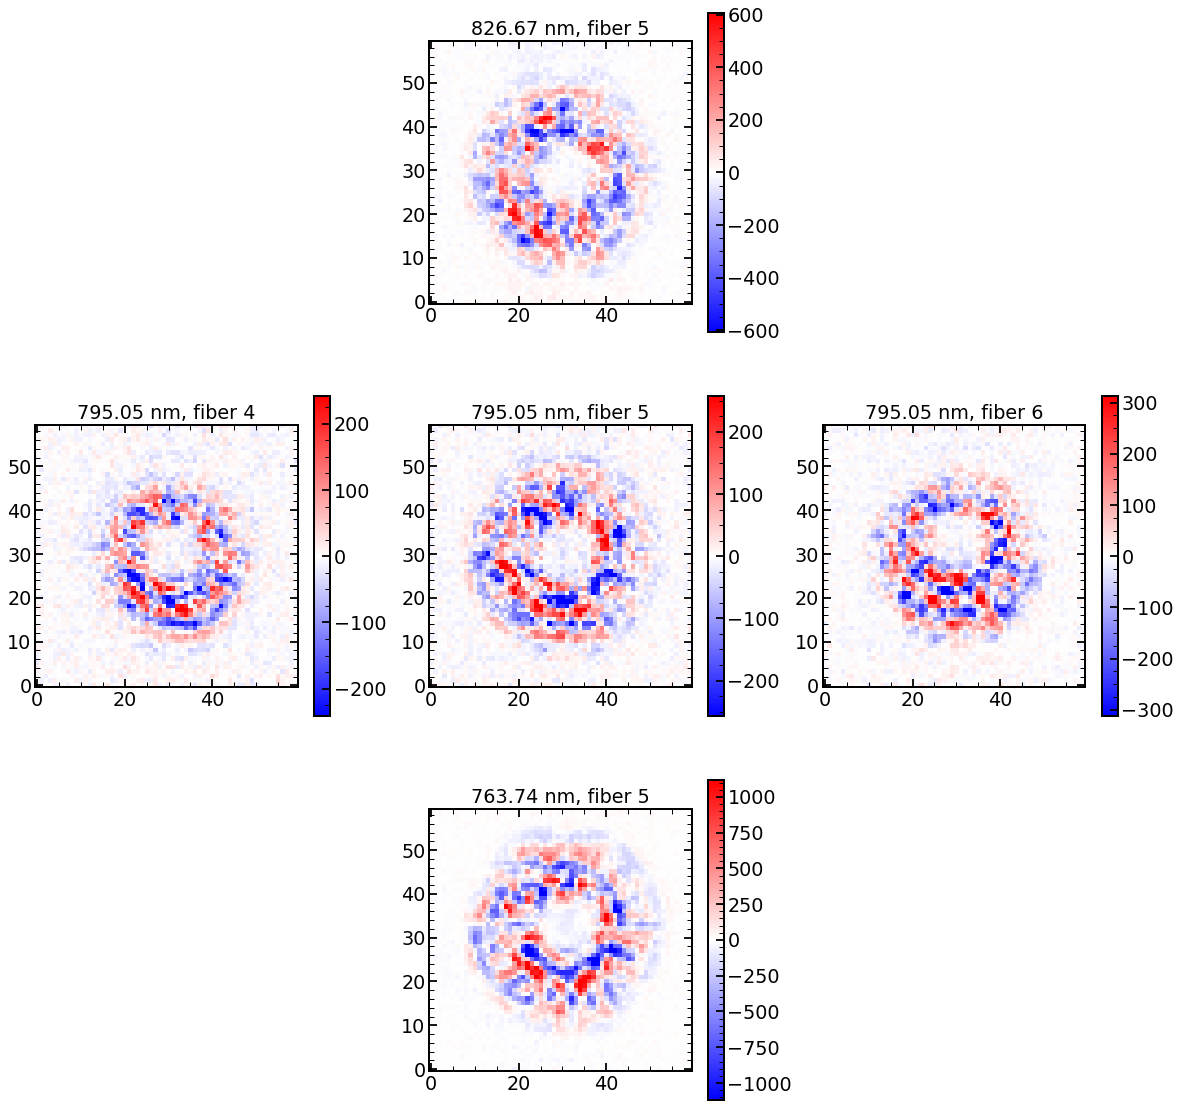

In [96]:
matplotlib.rcParams.update({'font.size':16})
plt.figure(figsize=(20,20))

plt.subplot(332)
plt.imshow(test_image_top-sci_image_top,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_top))/20,vmax=np.max(np.abs(sci_image_top))/20)
plt.title('826.67 nm, fiber 5')
plt.colorbar()

plt.subplot(338)
plt.title('763.74 nm, fiber 5')
plt.imshow(test_image_bottom-sci_image_bottom,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_bottom))/20,vmax=np.max(np.abs(sci_image_bottom))/20)
plt.colorbar()

plt.subplot(334)
plt.title('795.05 nm, fiber 4')
plt.imshow(test_image_left-sci_image_left,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_left))/20,vmax=np.max(np.abs(sci_image_left))/20)
plt.colorbar()

plt.subplot(336)
plt.title('795.05 nm, fiber 6')
plt.imshow(test_image_right-sci_image_right,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_right))/20,vmax=np.max(np.abs(sci_image_right))/20)
plt.colorbar()

plt.subplot(335)
plt.title('795.05 nm, fiber 5')
plt.imshow(test_image_center-sci_image_center,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_center))/20,vmax=np.max(np.abs(sci_image_center))/20)
plt.colorbar()

In [119]:
single_number=78
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_right_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
model = LN_PFS_single(sci_image_right,var_image_right,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_right_int)
test_image_right_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_right=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_right_Dec23_int-sci_image_right)**2/var_image_right))


single_number=54
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_left_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
model = LN_PFS_single(sci_image_left,var_image_left,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_left_int)
test_image_left_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_left=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_left_Dec23_int-sci_image_left)**2/var_image_left))

single_number=65
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_bottom_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
model = LN_PFS_single(sci_image_bottom,var_image_bottom,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_bottom_int)
test_image_bottom_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_bottom=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_bottom_Dec23_int-sci_image_bottom)**2/var_image_bottom))

single_number=67
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_top_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
model = LN_PFS_single(sci_image_top,var_image_top,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_top_int)
test_image_top_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_top=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_top_Dec23_int-sci_image_top)**2/var_image_top))

single_number=66
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()
allparameters_proposal_center_int=results_of_fit_many_interpolation_HgAr['p35'].loc[single_number][:31+11]
model = LN_PFS_single(sci_image_center,var_image_center,dithering=1,save=1,zmax=22)   
res=model(allparameters_proposal_center_int)
test_image_center_Dec23_int=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
pupililluminated_center=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
print(np.mean((test_image_center_Dec23_int-sci_image_center)**2/var_image_center))

(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 5650.422300383334
minimal chi2 reduced is: 3.1344857997489184
zmax: 22
4.0137068849102455
(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 4023.467988989565
minimal chi2 reduced is: 2.230702998833323
zmax: 22
2.9688019340786247
(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 17592.506686583256
minimal chi2 reduced is: 9.768620505030894
zmax: 22
15.363973093466209
(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 8619.856091290847
minimal chi2 reduced is: 4.7839812357013445
zmax: 22
8.35296101307214
(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 5423.629487053347
minimal chi2 reduced is: 3.0084949227239526
zmax: 22
4.002804844303827


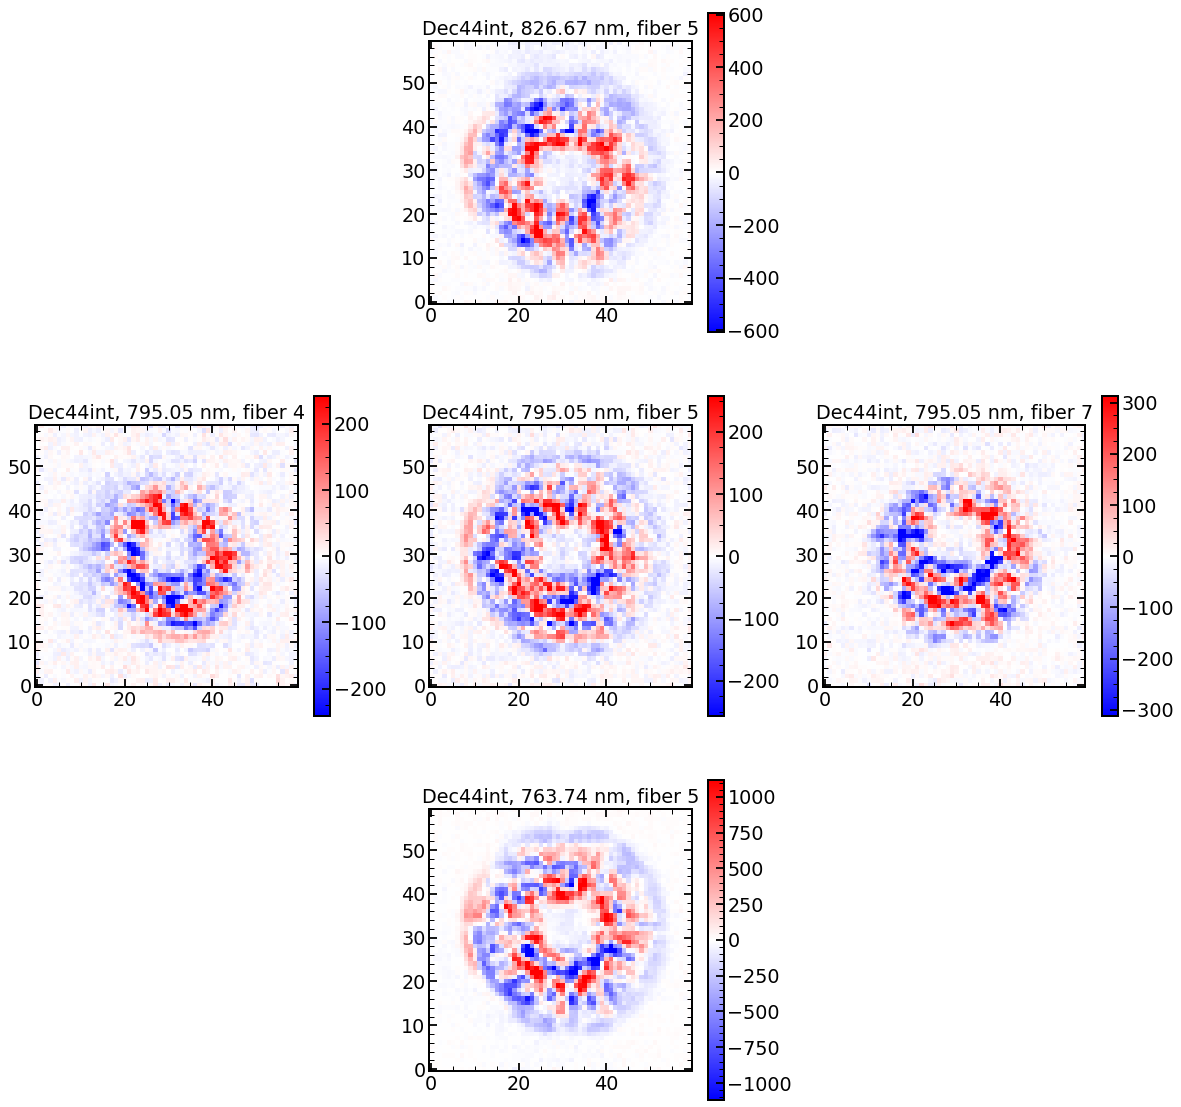

In [120]:
matplotlib.rcParams.update({'font.size':16})
plt.figure(figsize=(20,20))

plt.subplot(332)
plt.imshow(test_image_top_Dec23_int-sci_image_top,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_top))/20,vmax=np.max(np.abs(sci_image_top))/20)
plt.title('Dec44int, 826.67 nm, fiber 5')
plt.colorbar()

plt.subplot(338)
plt.title('Dec44int, 763.74 nm, fiber 5')
plt.imshow(test_image_bottom_Dec23_int-sci_image_bottom,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_bottom))/20,vmax=np.max(np.abs(sci_image_bottom))/20)
plt.colorbar()

plt.subplot(334)
plt.title('Dec44int, 795.05 nm, fiber 4')
plt.imshow(test_image_left_Dec23_int-sci_image_left,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_left))/20,vmax=np.max(np.abs(sci_image_left))/20)
plt.colorbar()

plt.subplot(336)
plt.title('Dec44int, 795.05 nm, fiber 7')
plt.imshow(test_image_right_Dec23_int-sci_image_right,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_right))/20,vmax=np.max(np.abs(sci_image_right))/20)
plt.colorbar()

plt.subplot(335)
plt.title('Dec44int, 795.05 nm, fiber 5')
plt.imshow(test_image_center_Dec23_int-sci_image_center,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image_center))/20,vmax=np.max(np.abs(sci_image_center))/20)
plt.colorbar()

## creating scripts for focus run

In [301]:
#MPI
for single_spot in list_of_HgAr_to_analyze:
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T'+str(45)+'S'+str(single_spot)+'Dec.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=4 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 4:59:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    for obs in [8603,8597,8594,8591,8588,8585,8582,8579,8576]:
        file.write("mpirun python /home/ncaplar/Code/ZernikeSingle_Dec_MPI45_focus.py "+str(obs)+" "+str(single_spot)+" 40 5 HgAr\n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/DecScriptToSubmitScriptsTiger45'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
#for obs in [1,2,3,4]:
#    for single_spot in [35,45,55,75,85,95]:
#        file.write('sbatch /home/ncaplar/Scripts/T'+str(obs)+'S'+str(single_spot)+'Sep_P.sh \n')

for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T'+str(45)+'S'+str(single_spot)+'Dec.sh \n')

file.close()

# Focus

### rename 

In [151]:
#deprecated
# due to error in naming first version of the code

"""
import os
for filename in tqdm(os.listdir("/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Dec45/")):
    if filename.startswith("chainDec42_"):
        os.rename("/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Dec45/"+str(filename),"/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Dec45/"+'chainDec45_'+str(filename[11:]))
    if filename.startswith("likechainDec42_"):
        os.rename("/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Dec45/"+str(filename),"/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Dec45/"+'likechainDec45_'+str(filename[15:]))
"""

100%|██████████| 514/514 [00:00<00:00, 5538.54it/s]


## Look at the results at one point  - focused analysis


In [315]:
date='Dec45'
obs=str(8603)
single_number='32'
image_index=int(single_number)
eps=5
arc='HgAr'


STAMPS_FOLDER="/Users/nevencaplar/Documents/PFS/Data_Nov_14/Stamps_cleaned/"

if arc=="HgAr":
    single_number_focus=8603
elif arc=="Ne":
    single_number_focus=8693    
else:
    print("Not recognized arc-line")

if arc=='HgAr':
    obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])
elif arc=='Ne':
    obs_possibilites=np.array([8552,8555,8558,8561,8564,8567,8570,8573,8603,8600,8606,8609,8612,8615,8618,8621,8624,8627])+90
    
label=['m4','m35','m3','m25','m2','m15','m1','m05','0d','0','p05','p1','p15','p2','p25','p3','p35','p4','0p']
labelInput=label[list(obs_possibilites).index(int(obs))]

if obs==8600:
    print("Not implemented for December 2018 data")
else:
    sci_image =np.load(STAMPS_FOLDER+'sci'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    var_image =np.load(STAMPS_FOLDER+'var'+str(obs)+str(single_number)+str(arc)+'_Stacked.npy')
    sci_image_focus_large =np.load(STAMPS_FOLDER+'sci'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')
    var_image_focus_large =np.load(STAMPS_FOLDER+'var'+str(single_number_focus)+str(single_number)+str(arc)+'_Stacked_large.npy')

if arc=="HgAr":
    finalArc=finalHgAr
elif arc=="Ne":
    finalArc=finalNe    
else:
    print("Not recognized arc-line")    
        
finalArc.loc[int(single_number)]

fiber                     2
xc                     1253
yc                     2622
wavelength         852.4029
close                     1
lamp                   HgAr
xc_effective           1253
old_index                32
old_index_aprox          32
Name: 32, dtype: object

In [316]:
list_of_masks=create_mask(sci_image_focus_large)
diagonal_cross=list_of_masks[3]
res_diagonal_cross_large=create_res_data(sci_image_focus_large,diagonal_cross,custom_cent=True,size_pixel=15)
distances_large=range(len(res_diagonal_cross_large))
last_distance=np.array(distances_large[101:])[np.log10(res_diagonal_cross_large[101:])>0.5][-1]
# if the average is below 0 terminate at that position

where_are_NaNs=np.isnan(np.log10(np.array(res_diagonal_cross_large[101:])))
if np.sum(where_are_NaNs)>0:
    first_NaN_position=np.array(distances_large[101:])[where_are_NaNs][0]
else:
    first_NaN_position=last_distance
last_distance=np.min([first_NaN_position,last_distance]) -1

z=np.polyfit(np.log10(np.array(distances_large[101:last_distance])),np.log10(np.array(res_diagonal_cross_large)[101:last_distance]),1)
deduced_scattering_slope=z[0]-0.05
print("deduced_scattering_slope: "+str(deduced_scattering_slope))

deduced_scattering_slope: -0.9903580873955653


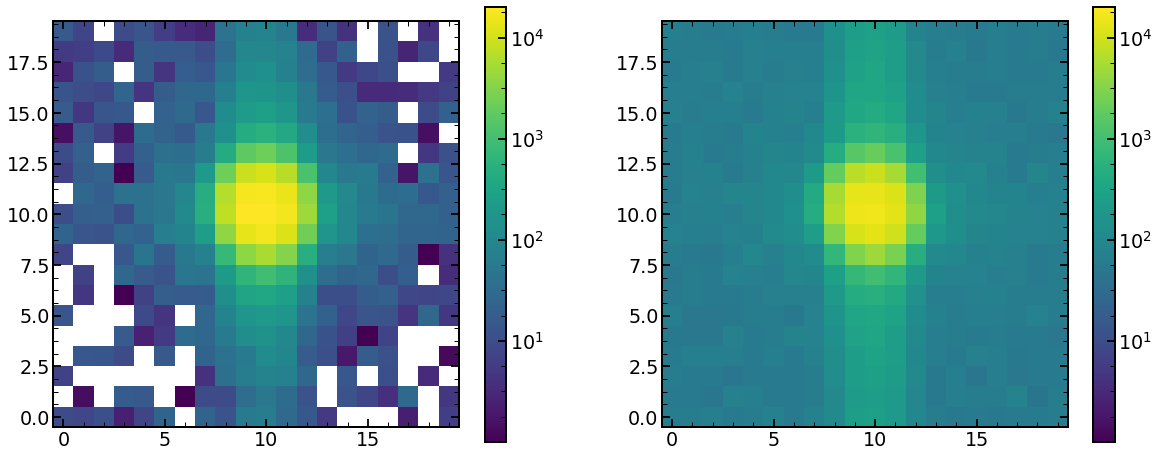

In [317]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(sci_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(122)
plt.imshow(var_image,norm=LogNorm(),origin='lower',vmin=1,vmax=np.max(sci_image))
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5])


In [332]:
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()

minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 452.1463111370924
minimal chi2 reduced is: 2.2252912200831645


In [319]:
if len(minchain)==42:
    columns=columns22
    dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns[0:8])
    print(dfz22)
    dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][8:len(columns)]]),columns=columns[8:])

    dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][8:18]]),columns=columns[8:18])
    print(dfglobal1)

    dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][18:len(columns)]]),columns=columns[18:])
    print(dfglobal2)


         z4        z5        z6        z7        z8        z9       z10  \
0  0.415176 -0.153654 -0.300309 -0.236733  0.121236  0.219111 -0.295922   

        z11  
0 -0.373296  
       z12       z13       z14       z15       z16       z17      z18  \
0 -0.05083  0.038266  0.008766 -0.009764 -0.012553  0.004536 -0.00424   

       z19       z20       z21  
0  0.01309 -0.025697 -0.021203  
        z22   hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0 -0.016476  0.688919   0.082245 -0.081104  0.111078  0.062503      0.03989   

   radiometricEffect  radiometricExponent    x_ilum    ...     frd_sigma  \
0           0.251367             0.643238  0.851355    ...      0.074546   

   frd_lorentz_factor  det_vert  slitHolder_frac_dx  grating_lines  \
0            0.267425   1.01853            0.269008   14786.097783   

   scattering_slope  scattering_amplitude  pixel_effect   fiber_r      flux  
0          1.896692              0.000699          0.35  1.851341  0.998113  

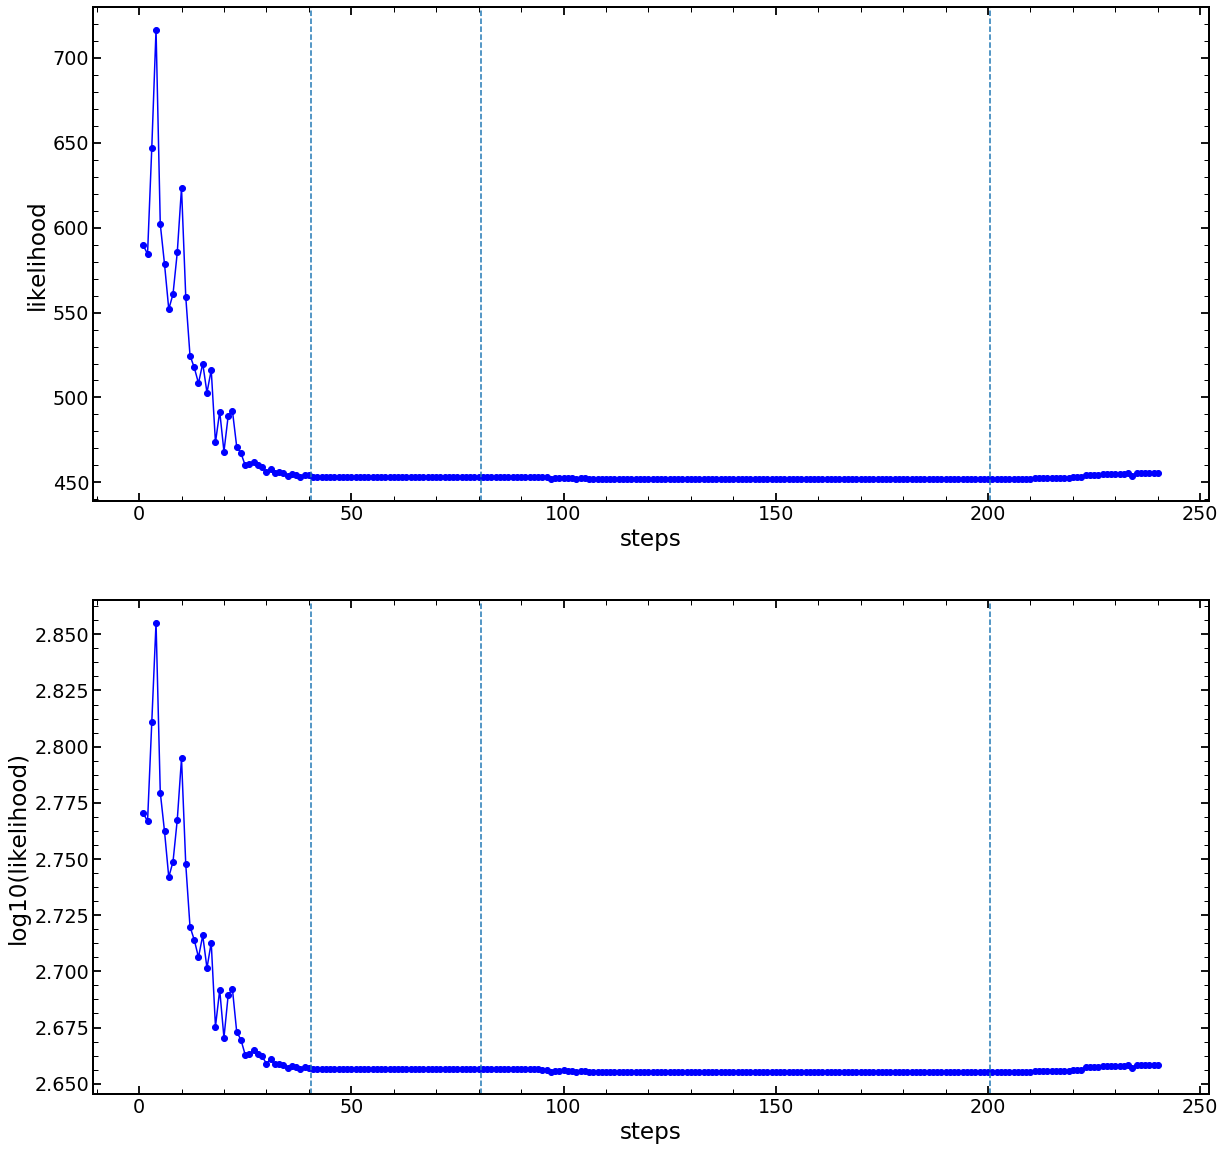

In [320]:
size=40

plt.figure(figsize=(20,20))
plt.subplot(211)
plt.plot(np.linspace(1,len(like_min),len(like_min)),like_min,'blue',ls='-',marker='o')
plt.ylabel('likelihood')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(size*2+0.5,ls='--')
plt.axvline(size*5+0.5,ls='--')
plt.subplot(212)
plt.plot(np.linspace(1,len(like_min),len(like_min)),np.log10(like_min),'blue',ls='-',marker='o')
plt.ylabel('log10(likelihood)')
plt.xlabel('steps')
plt.axvline(size+0.5,ls='--')
plt.axvline(2*size+0.5,ls='--')
plt.axvline(5*size+0.5,ls='--')

In [495]:
if obs=='8600':
    model = LN_PFS_single(sci_image,var_image,dithering=2,save=1)
else:
    model = LN_PFS_single(sci_image,var_image,dithering=1,save=1,zmax=22)   
       
model(minchain)

zmax: 22
[[0.         0.         2.22529124]
 [0.         0.05       2.26423926]
 [0.         0.1        2.32531623]
 [0.         0.15       2.40852217]
 [0.         0.2        2.51385706]
 [0.         0.25       2.64132091]
 [0.         0.3        2.79091372]
 [0.         0.35       2.96263548]
 [0.         0.4        3.1564862 ]
 [0.         0.45       3.37246588]
 [0.05       0.         2.35928116]
 [0.05       0.05       2.39895049]
 [0.05       0.1        2.46074877]
 [0.05       0.15       2.54467601]
 [0.05       0.2        2.65073221]
 [0.05       0.25       2.77891737]
 [0.05       0.3        2.92923148]
 [0.05       0.35       3.10167456]
 [0.05       0.4        3.29624659]
 [0.05       0.45       3.51294757]
 [0.1        0.         2.5262338 ]
 [0.1        0.05       2.56662443]
 [0.1        0.1        2.62914403]
 [0.1        0.15       2.71379257]
 [0.1        0.2        2.82057008]
 [0.1        0.25       2.94947654]
 [0.1        0.3        3.10051197]
 [0.1        0.35  

-412.19628701705017

In [496]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
r_ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')

wf=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf.npy') 
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 
u_manual=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'u_manual.npy')
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')   
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')      

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
optPsf_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled.npy')
optPsf_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_fiber_convolved.npy')

optPsf_downsampled_scattered=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_downsampled_scattered.npy')
res_init=np.load(TESTING_FINAL_IMAGES_FOLDER+'res_init.npy')
res=np.load(TESTING_FINAL_IMAGES_FOLDER+'res.npy')


optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
res_iapetus=optPsf_cut_fiber_convolved_downsampled

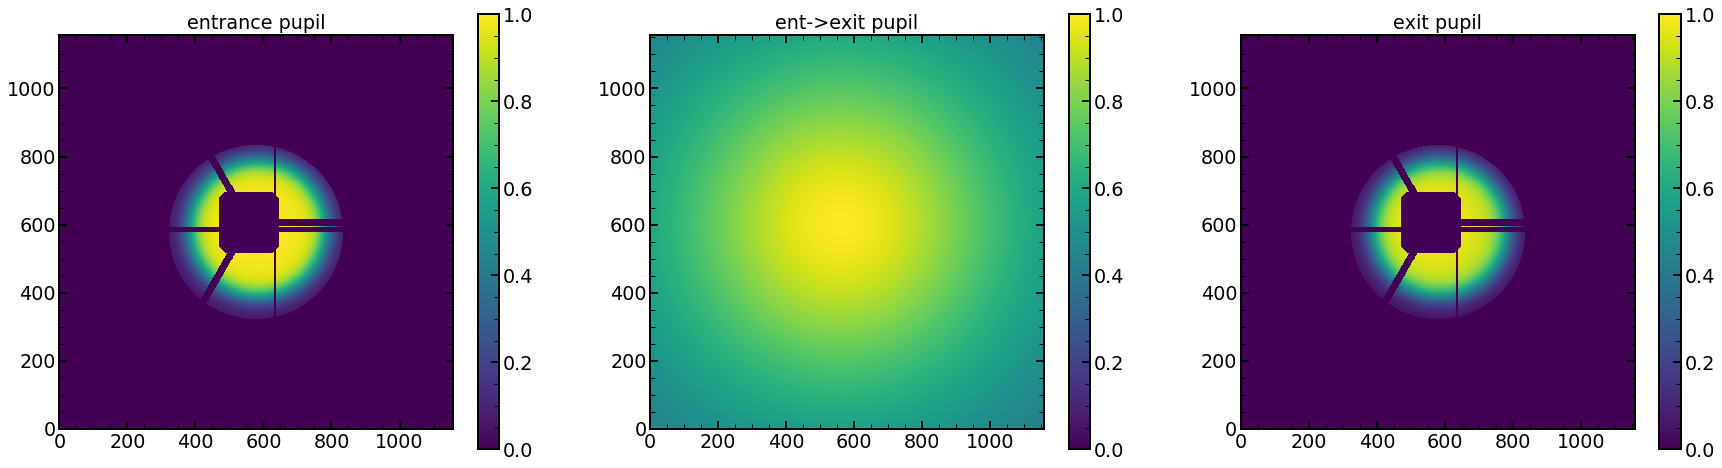

In [497]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

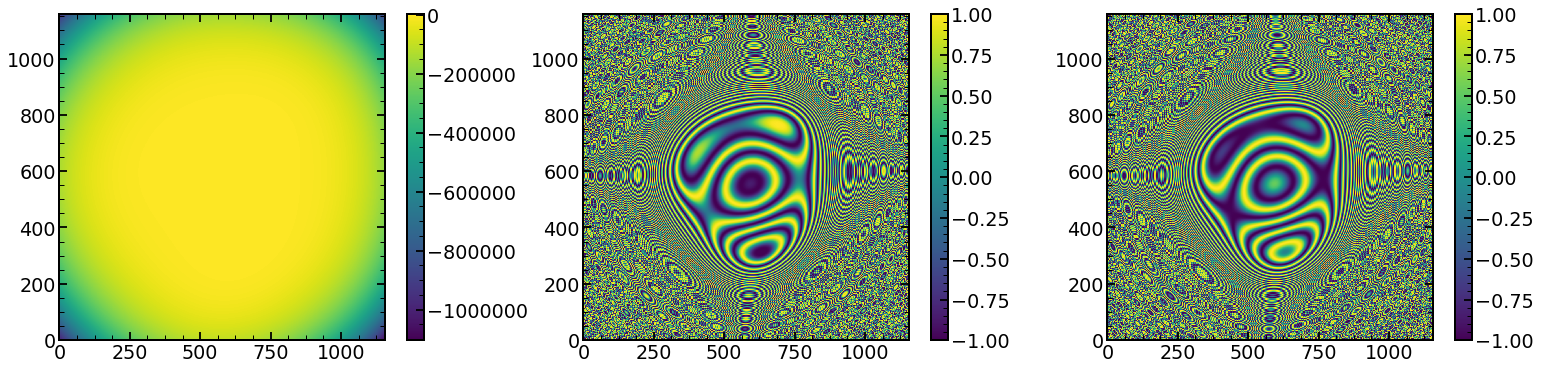

In [498]:
plt.figure(figsize=(36,6))
plt.subplot(141)
plt.imshow(wf_full)
plt.colorbar()

plt.subplot(142)
plt.imshow(np.real(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

plt.subplot(143)
plt.imshow(np.imag(np.exp(2j*np.pi * wf_full/800)))
plt.colorbar()

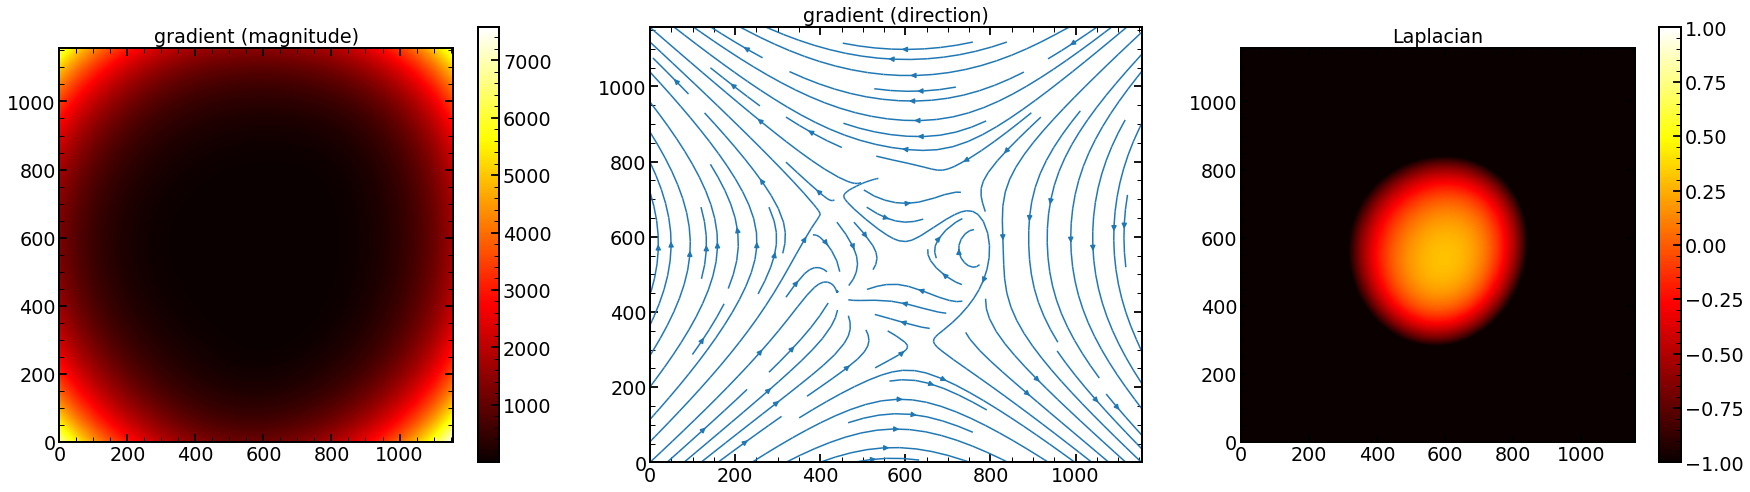

In [499]:
plt.figure(figsize=(30,8))
plt.subplot(131)
vgrad = np.gradient(wf_full)
fulgrad = np.sqrt(vgrad[0]**2 + vgrad[1]**2)
plt.title('gradient (magnitude)')
plt.imshow(fulgrad,cmap=plt.get_cmap('hot'), vmin = np.amin(fulgrad),vmax = np.amax(fulgrad))  
plt.colorbar()
plt.subplot(132)
x, y = range(0, len(wf_full)), range(0,len(wf_full))
xi, yi = np.meshgrid(x, y)
plt.title('gradient (direction)')
plt.streamplot(xi, yi, vgrad[0], vgrad[1])
plt.subplot(133)
laplace_of_wf = scipy.ndimage.filters.laplace(wf_full)
plt.title('Laplacian')
plt.imshow(laplace_of_wf,cmap=plt.get_cmap('hot'), vmin = -1,vmax = 1) 
plt.colorbar()

chi**2 reduced is: 2.0255411215156336
Abs of residual divided by total flux is: 0.0398279829119297
Abs of residual divided by largest value of a flux in the image is: 0.049578502025562673


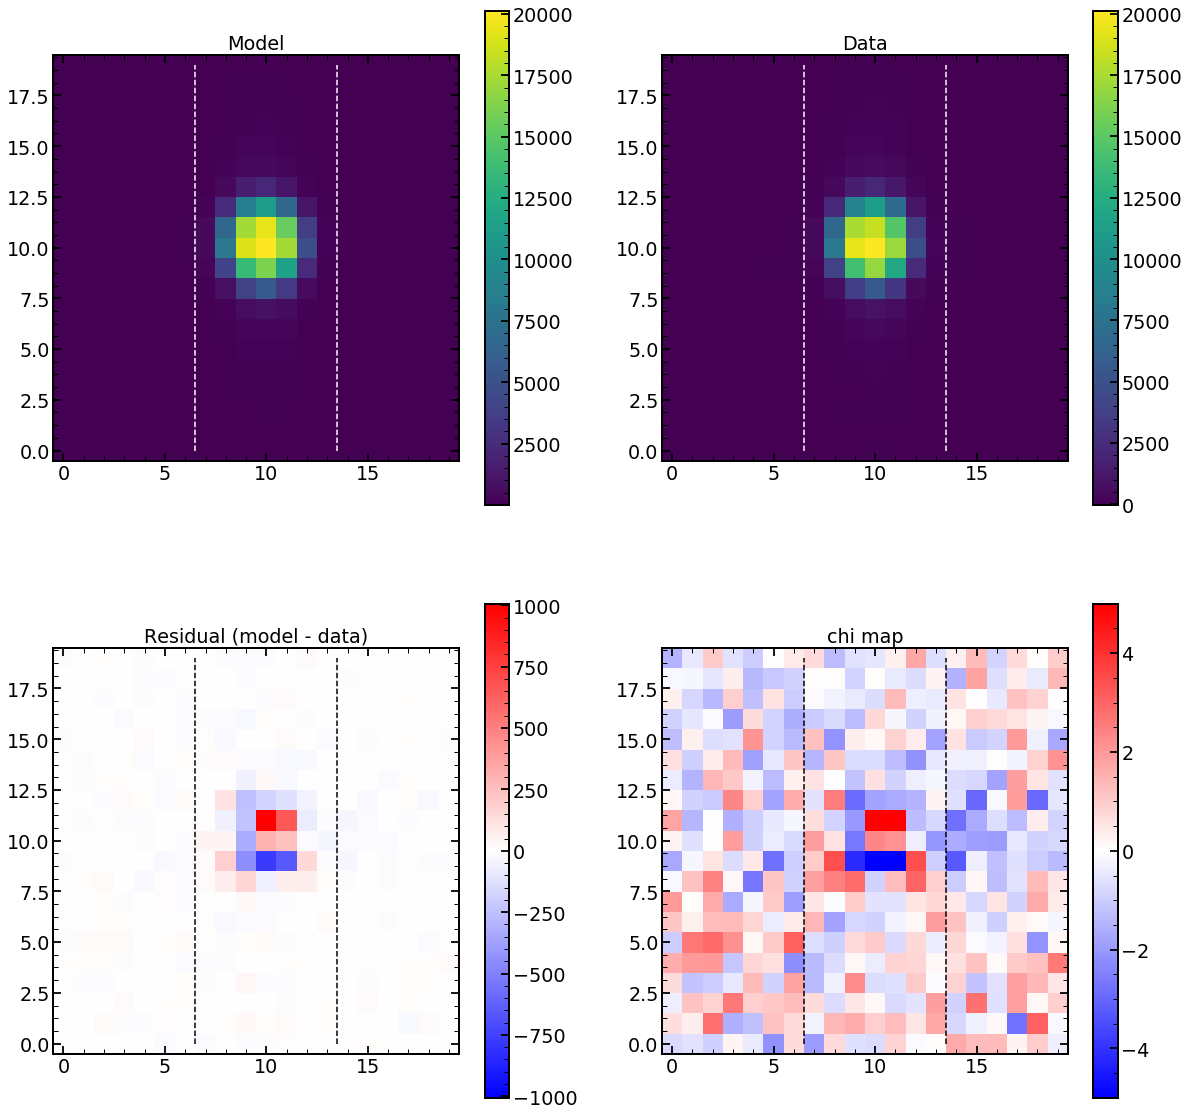

In [500]:
single_analysis.create_basic_comparison_plot()

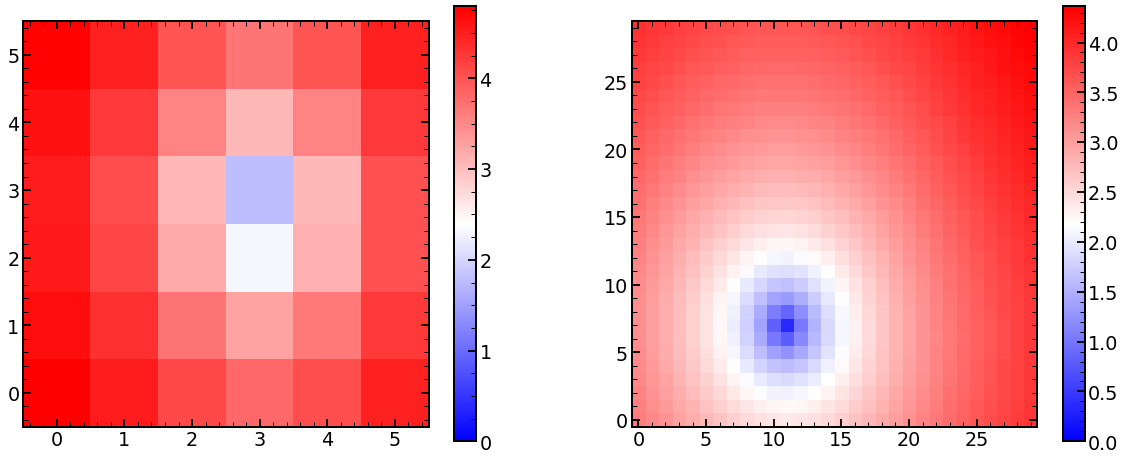

In [352]:
plt.figure(figsize=(20,8))
plt.subplot(121)
x=np.unique(res_init[:,0])
y=np.unique(res_init[:,1])
plt.imshow(np.log10(res_init[:,2].reshape(len(x),len(y))),vmin=0,cmap='bwr')
plt.colorbar()
plt.subplot(122)
x=np.unique(res[:,0])
y=np.unique(res[:,1])
plt.imshow(np.log10(res[:,2].reshape(len(x),len(y))),vmin=0,cmap='bwr')
plt.colorbar()

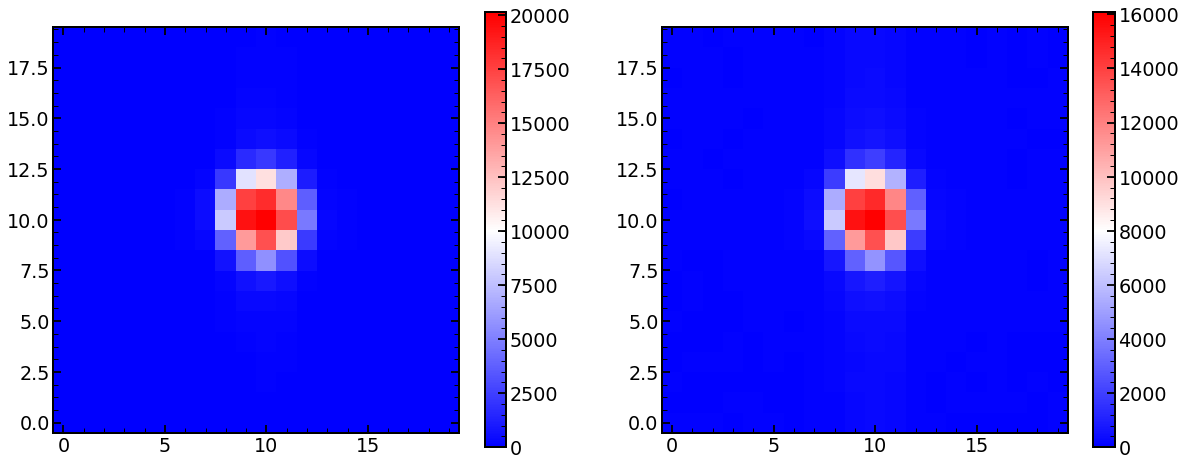

In [387]:
plt.figure(figsize=(20,8))
plt.subplot(121)
x=np.unique(res_init[:,0])
y=np.unique(res_init[:,1])
plt.imshow(sci_image,vmin=0,cmap='bwr')
plt.colorbar()
plt.subplot(122)
x=np.unique(res[:,0])
y=np.unique(res[:,1])
plt.imshow(var_image,vmin=0,cmap='bwr')
plt.colorbar()

In [388]:
oversampling

10

In [437]:
focus_res=[]
list_of_single_realization=[]
resmin=res[res[:,2]==np.min(res[:,2])][0]
for dx in range(-1,2):
    for dy in range(-1,2):
        resmin_x=int(resmin[0])+dx
        resmin_y=int(resmin[1])+dy
        print('resmin_x: '+str(resmin_x))
        print('resmin_y: '+str(resmin_y))
        oversampling=10
        shape_of_sci_image=sci_image.shape[0]
    
        input_img=optPsf_cut_grating_convolved
        input_img_single_realization_before_downsampling=input_img[resmin_y:resmin_y+oversampling*shape_of_sci_image,resmin_x:resmin_x+oversampling*shape_of_sci_image]
        single_realization=resize(input_img_single_realization_before_downsampling,(shape_of_sci_image,shape_of_sci_image))
        list_of_single_realization.append(single_realization)
        multiplicative_factor=np.sum(sci_image)/np.sum(single_realization)
        single_realization_finalImg=1*multiplicative_factor*single_realization
        focus_res.append(single_realization_finalImg)


#plt.figure
#plt.subplot(121)
#plt.imshow(optPsf_cut_grating_convolved,origin='lower')
#plt.subplot(122)
#plt.imshow(single_realization_finalImg,origin='lower')

resmin_x: 35
resmin_y: 31
resmin_x: 35
resmin_y: 32
resmin_x: 35
resmin_y: 33
resmin_x: 36
resmin_y: 31
resmin_x: 36
resmin_y: 32
resmin_x: 36
resmin_y: 33
resmin_x: 37
resmin_y: 31
resmin_x: 37
resmin_y: 32
resmin_x: 37
resmin_y: 33


(200, 200)


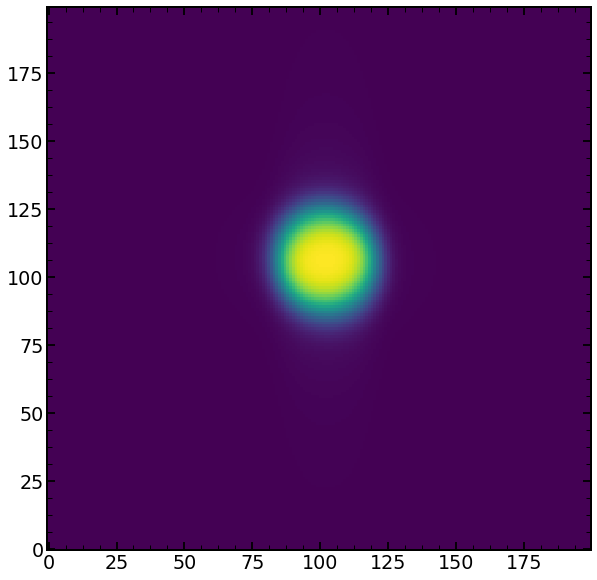

In [438]:
print(input_img_single_realization_before_downsampling.shape)
plt.imshow(input_img_single_realization_before_downsampling)

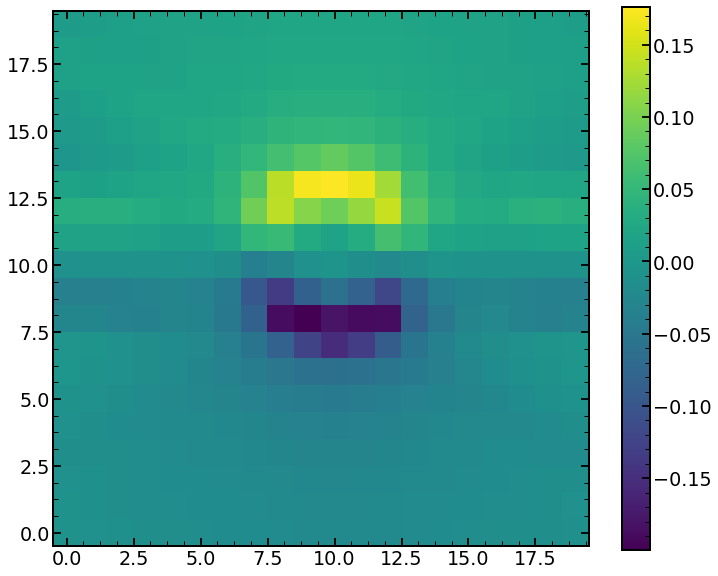

In [439]:
plt.imshow((list_of_single_realization[0]-list_of_single_realization[1])/list_of_single_realization[0])
plt.colorbar()

10.760219502131708
6.630687554241911
6.630687554241911
6.132511816953934
2.2279306354414716
7.229588700689319
14.886163246442507
11.20376210248515
16.607794657347235


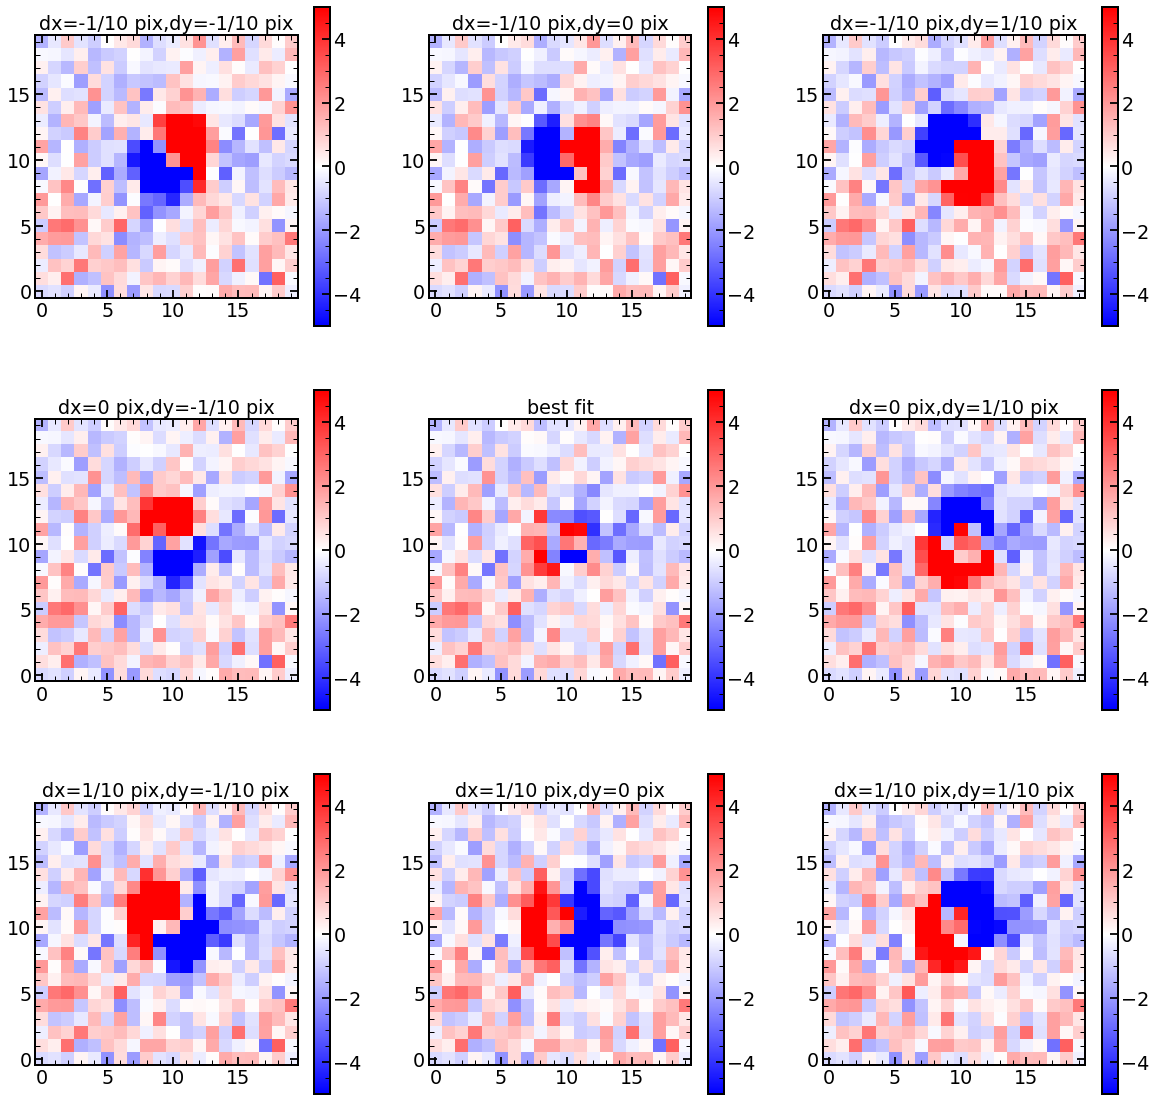

In [440]:
matplotlib.rcParams.update({'font.size':16})
plt.figure(figsize=(20,20))

plt.subplot(331)
plt.imshow((focus_res[0]-sci_image)**1/np.sqrt(var_image),vmax=5,vmin=-5,cmap='bwr',origin='lower')
plt.title('dx=-1/10 pix,dy=-1/10 pix')
print(np.mean((focus_res[0]-sci_image)**2/(var_image)))
plt.colorbar()

plt.subplot(332)
plt.title('763.74 nm, fiber 5')
plt.imshow((focus_res[1]-sci_image)**1/np.sqrt(var_image),vmax=5,vmin=-5,cmap='bwr',origin='lower')
plt.title('dx=-1/10 pix,dy=0 pix')
print(np.mean((focus_res[1]-sci_image)**2/(var_image)))
plt.colorbar()

plt.subplot(333)
plt.title('795.05 nm, fiber 4')
plt.imshow((focus_res[2]-sci_image)**1/np.sqrt(var_image),vmax=5,vmin=-5,cmap='bwr',origin='lower')
plt.title('dx=-1/10 pix,dy=1/10 pix')
print(np.mean((focus_res[1]-sci_image)**2/(var_image)))
plt.colorbar()

plt.subplot(334)
plt.title('795.05 nm, fiber 6')
plt.imshow((focus_res[3]-sci_image)**1/np.sqrt(var_image),vmax=5,vmin=-5,cmap='bwr',origin='lower')
plt.title('dx=0 pix,dy=-1/10 pix')
print(np.mean((focus_res[3]-sci_image)**2/(var_image)))
plt.colorbar()

plt.subplot(335)
plt.title('795.05 nm, fiber 5')
plt.imshow((focus_res[4]-sci_image)**1/np.sqrt(var_image),vmax=5,vmin=-5,cmap='bwr',origin='lower')
plt.title('best fit')
print(np.mean((focus_res[4]-sci_image)**2/(var_image)))
plt.colorbar()

plt.subplot(336)
plt.title('795.05 nm, fiber 5')
plt.imshow((focus_res[5]-sci_image)**1/np.sqrt(var_image),vmax=5,vmin=-5,cmap='bwr',origin='lower')
plt.title('dx=0 pix,dy=1/10 pix')
print(np.mean((focus_res[5]-sci_image)**2/(var_image)))
plt.colorbar()

plt.subplot(337)
plt.title('795.05 nm, fiber 6')
plt.imshow((focus_res[6]-sci_image)**1/np.sqrt(var_image),vmax=5,vmin=-5,cmap='bwr',origin='lower')
plt.colorbar()
plt.title('dx=1/10 pix,dy=-1/10 pix')
print(np.mean((focus_res[6]-sci_image)**2/(var_image)))

plt.subplot(338)
plt.title('795.05 nm, fiber 5')
plt.imshow((focus_res[7]-sci_image)**1/np.sqrt(var_image),vmax=5,vmin=-5,cmap='bwr',origin='lower')
plt.colorbar()
plt.title('dx=1/10 pix,dy=0 pix')
print(np.mean((focus_res[7]-sci_image)**2/(var_image)))

plt.subplot(339)
plt.title('795.05 nm, fiber 5')
plt.imshow((focus_res[8]-sci_image)**1/np.sqrt(var_image),vmax=5,vmin=-5,cmap='bwr',origin='lower')
plt.colorbar()
plt.title('dx=1/10 pix,dy=1/10 pix')
print(np.mean((focus_res[8]-sci_image)**2/(var_image)))

In [468]:
res=[]

for dx in np.linspace(0.00,0.45,10):
    for dy in np.linspace(0.0,0.45,10):
        focus_res_41=dx*focus_res[7]+dy*focus_res[3]+(1-dx-dy)*focus_res[4]
        res.append([-dx,-dy,np.mean((focus_res_41-sci_image)**2/(var_image))])
        print([dx,dy,np.mean((focus_res_41-sci_image)**2/(var_image))])
        
        
for dx in np.linspace(0.00,0.45,10):
    for dy in np.linspace(0.0,0.45,10):
        focus_res_41=dx*focus_res[1]+dy*focus_res[3]+(1-dx-dy)*focus_res[4]
        res.append([-dx,dy,np.mean((focus_res_41-sci_image)**2/(var_image))])
        print([dx,dy,np.mean((focus_res_41-sci_image)**2/(var_image))])

        

        
for dx in np.linspace(0.00,0.45,10):
    for dy in np.linspace(0.0,0.45,10):
        focus_res_41=dx*focus_res[7]+dy*focus_res[5]+(1-dx-dy)*focus_res[4]
        res.append([dx,-dy,np.mean((focus_res_41-sci_image)**2/(var_image))])
        print([dx,dy,np.mean((focus_res_41-sci_image)**2/(var_image))])
        
                
for dx in np.linspace(0.00,0.45,10):
    for dy in np.linspace(0.0,0.45,10):
        focus_res_41=dx*focus_res[1]+dy*focus_res[5]+(1-dx-dy)*focus_res[4]
        res.append([dx,dy,np.mean((focus_res_41-sci_image)**2/(var_image))])
        print([dx,dy,np.mean((focus_res_41-sci_image)**2/(var_image))])

[0.0, 0.0, 2.2279306354414716]
[0.0, 0.05, 2.2131158786812257]
[0.0, 0.1, 2.220410997272124]
[0.0, 0.15000000000000002, 2.249815991214169]
[0.0, 0.2, 2.301330860507353]
[0.0, 0.25, 2.3749556051516847]
[0.0, 0.30000000000000004, 2.4706902251471603]
[0.0, 0.35000000000000003, 2.5885347204937785]
[0.0, 0.4, 2.7284890911915407]
[0.0, 0.45, 2.890553337240449]
[0.05, 0.0, 2.362391148345185]
[0.05, 0.05, 2.346912448247566]
[0.05, 0.1, 2.3535436235010883]
[0.05, 0.15000000000000002, 2.382284674105754]
[0.05, 0.2, 2.433135600061568]
[0.05, 0.25, 2.506096401368524]
[0.05, 0.30000000000000004, 2.6011670780266223]
[0.05, 0.35000000000000003, 2.718347630035866]
[0.05, 0.4, 2.857638057396256]
[0.05, 0.45, 3.0190383601077877]
[0.1, 0.0, 2.529939141296107]
[0.1, 0.05, 2.513796497861112]
[0.1, 0.1, 2.5197637297772593]
[0.1, 0.15000000000000002, 2.5478408370445527]
[0.1, 0.2, 2.5980278196629882]
[0.1, 0.25, 2.6703246776325704]
[0.1, 0.30000000000000004, 2.764731410953292]
[0.1, 0.35000000000000003, 2.88

2.0273866466330785


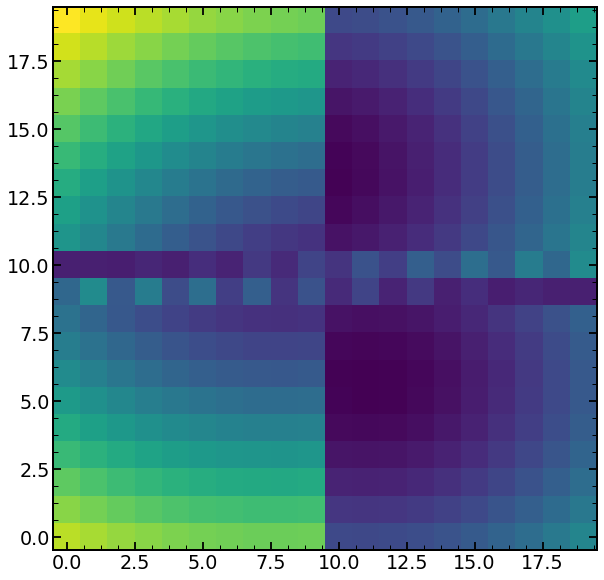

In [475]:
res=np.array(sorted(res,key=lambda x: (x[0],x[1])))
res=np.array(res)
print(np.min(res[:,2]))

plt.imshow(np.log(res[:,2].reshape(20,20)))

In [477]:
itemindex = np.where(array_of_min[:,2]==np.min(array_of_min[:,2])[0])

NameError: name 'array_of_min' is not defined

In [473]:
res[:,0].reshape(20,20)

array([[-0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45,
        -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45, -0.45,
        -0.45, -0.45],
       [-0.4 , -0.4 , -0.4 , -0.4 , -0.4 , -0.4 , -0.4 , -0.4 , -0.4 ,
        -0.4 , -0.4 , -0.4 , -0.4 , -0.4 , -0.4 , -0.4 , -0.4 , -0.4 ,
        -0.4 , -0.4 ],
       [-0.35, -0.35, -0.35, -0.35, -0.35, -0.35, -0.35, -0.35, -0.35,
        -0.35, -0.35, -0.35, -0.35, -0.35, -0.35, -0.35, -0.35, -0.35,
        -0.35, -0.35],
       [-0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 ,
        -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 , -0.3 ,
        -0.3 , -0.3 ],
       [-0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25,
        -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25, -0.25,
        -0.25, -0.25],
       [-0.2 , -0.2 , -0.2 , -0.2 , -0.2 , -0.2 , -0.2 , -0.2 , -0.2 ,
        -0.2 , -0.2 , -0.2 , -0.2 , -0.2 , -0.2 , -0.2 , -0.2 , -0.2 ,
        -0.2 , -0.2 ],
       [-0

In [ ]:
focus_res[4]

In [ ]:
focus_res[6]

In [ ]:
focus_res[8]

In [412]:
resmin_x=int(resmin[0])
resmin_y=int(resmin[1])
print('resmin_x: '+str(resmin_x))
print('resmin_y: '+str(resmin_y))
oversampling=10
shape_of_sci_image=sci_image.shape[0]

input_img=optPsf_cut_grating_convolved
input_img_single_realization_before_downsampling=input_img[resmin_y:resmin_y+oversampling*shape_of_sci_image,resmin_x:resmin_x+oversampling*shape_of_sci_image]
single_realization=resize(input_img_single_realization_before_downsampling,(shape_of_sci_image,shape_of_sci_image))
multiplicative_factor=np.sum(sci_image)/np.sum(single_realization)
single_realization_finalImg=1*multiplicative_factor*single_realization

resmin_x=int(resmin[0])
resmin_y=int(resmin[1])+1
print('resmin_x: '+str(resmin_x))
print('resmin_y: '+str(resmin_y))
oversampling=10
shape_of_sci_image=sci_image.shape[0]

input_img=optPsf_cut_grating_convolved
input_img_single_realization_before_downsampling_offset1=input_img[resmin_y:resmin_y+oversampling*shape_of_sci_image,resmin_x:resmin_x+oversampling*shape_of_sci_image]
single_realization_offset1=resize(input_img_single_realization_before_downsampling_offset1,(shape_of_sci_image,shape_of_sci_image))
multiplicative_factor=np.sum(sci_image)/np.sum(single_realization_offset1)
single_realization_finalImg_offset1=1*multiplicative_factor*single_realization_offset1

resmin_x: 36
resmin_y: 32
resmin_x: 36
resmin_y: 33


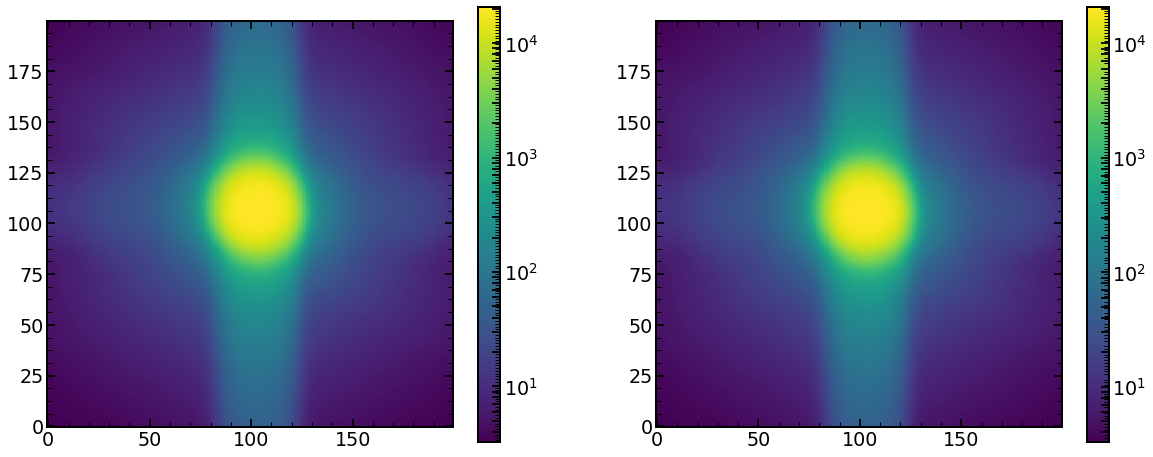

In [413]:
input_img_single_realization_before_downsampling_normalized=input_img_single_realization_before_downsampling*(100*np.sum(sci_image)/np.sum(input_img_single_realization_before_downsampling))
input_img_single_realization_before_downsampling_normalized_offset1=input_img_single_realization_before_downsampling_offset1*(100*np.sum(sci_image)/np.sum(input_img_single_realization_before_downsampling_offset1))

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(input_img_single_realization_before_downsampling_normalized,norm=LogNorm(),origin='lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(input_img_single_realization_before_downsampling_normalized_offset1,norm=LogNorm(),origin='lower')
plt.colorbar()

3.6564826765756084
[ 3.48218663  3.65648268  3.8484      4.13441789  4.49901622  4.90914242
  5.3938728   6.56326562 20.41309128 48.00055529 55.27409033 41.87396921
 13.79933108  5.82674404  5.18546784  4.73220161  4.34315085  4.02791208
  3.79230244  3.57073612]


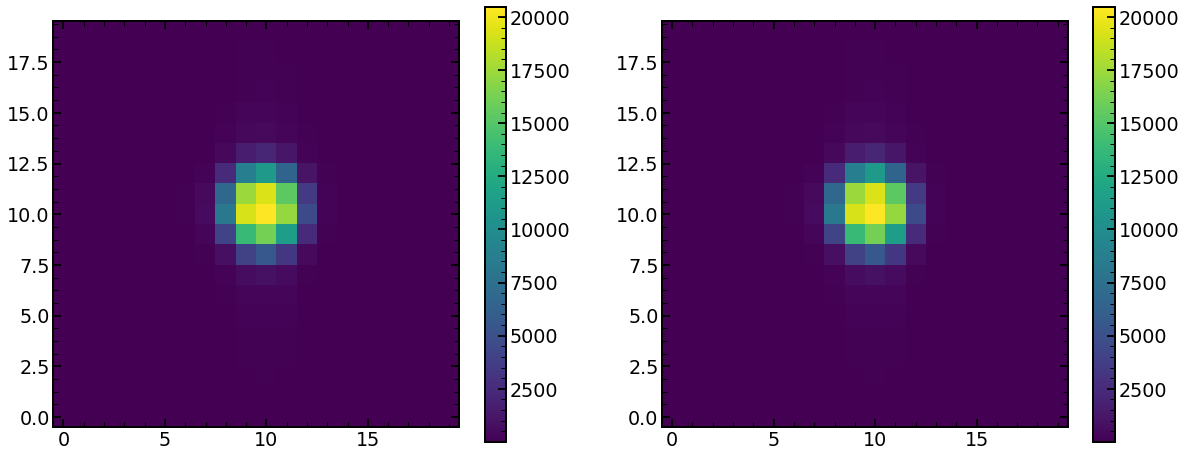

In [409]:
print(np.mean(input_img_single_realization_before_downsampling_normalized[0:10,10:20]))
print(resize(input_img_single_realization_before_downsampling_normalized,(20,20))[0])

manual_downsampling=[]
for x_index in range(20):
    for y_index in range(20):
        manual_downsampling.append(np.mean(input_img_single_realization_before_downsampling_normalized[x_index*10:(x_index+1)*10,y_index*10:(y_index+1)*10]))

manual_downsampling=np.array(manual_downsampling)
manual_downsampling=manual_downsampling.reshape(20,20)
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(resize(input_img_single_realization_before_downsampling_normalized,(20,20)))
plt.colorbar()
plt.subplot(122)
plt.imshow(manual_downsampling)
plt.colorbar()


In [410]:
# no difference between function resize and manual downsampling
resize(input_img_single_realization_before_downsampling_normalized,(20,20))-manual_downsampling

array([[ 0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-0.,  0., -0.,  0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,
         0.,  0.,  0.,  0.,  0., -0.,  0.],
       [ 0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,
        -0.,  0.,  0.,  0.,  0.,  0., -0.],
       [ 0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  

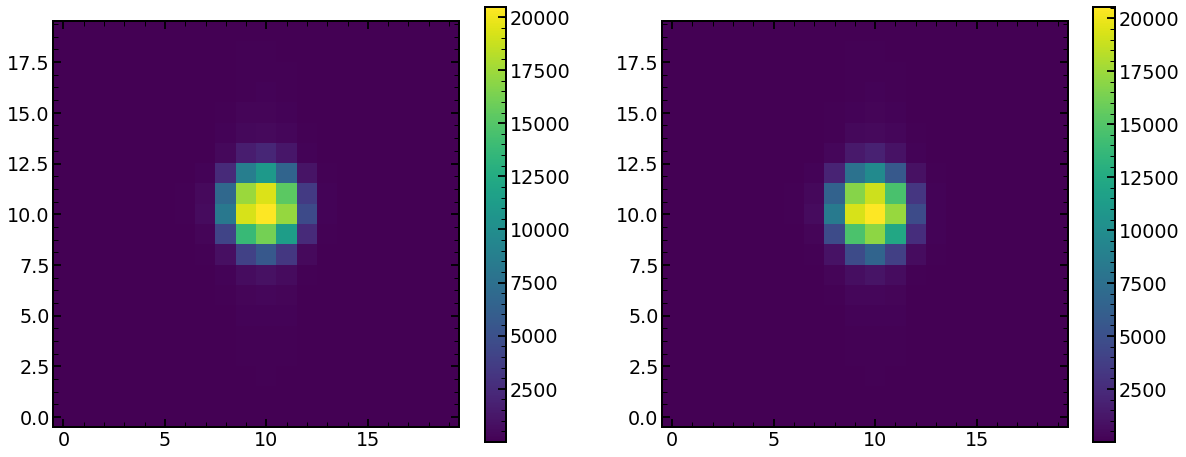

In [415]:
input_img_single_realization_before_downsampling_normalized_resized=resize(input_img_single_realization_before_downsampling_normalized,(20,20))
input_img_single_realization_before_downsampling_normalized_resized_offset1=resize(input_img_single_realization_before_downsampling_normalized_offset1,(20,20))

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(resize(input_img_single_realization_before_downsampling_normalized,(20,20)))
plt.colorbar()
plt.subplot(122)
plt.imshow(resize(input_img_single_realization_before_downsampling_normalized_offset1,(20,20)))
plt.colorbar()


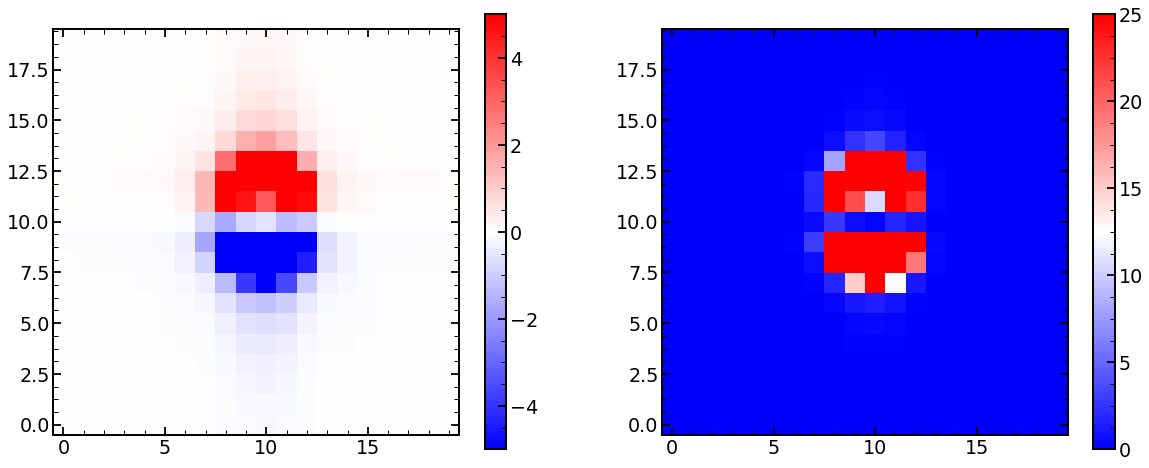

In [429]:
chi_map=(input_img_single_realization_before_downsampling_normalized_resized-input_img_single_realization_before_downsampling_normalized_resized_offset1)/np.sqrt(0.9*(input_img_single_realization_before_downsampling_normalized_resized+40))
chi2_map=(input_img_single_realization_before_downsampling_normalized_resized-input_img_single_realization_before_downsampling_normalized_resized_offset1)**2/(0.9*(input_img_single_realization_before_downsampling_normalized_resized+40))
np.mean(chi2_map)
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(chi_map,cmap='bwr',vmin=-5,vmax=5)
plt.colorbar()
plt.subplot(122)
plt.imshow(chi2_map,cmap='bwr',vmin=0,vmax=5**2)
plt.colorbar()

In [422]:
np.mean((input_img_single_realization_before_downsampling_normalized_resized-input_img_single_realization_before_downsampling_normalized_resized_offset1)**2/input_img_single_realization_before_downsampling_normalized_resized)

3.7406847845702713

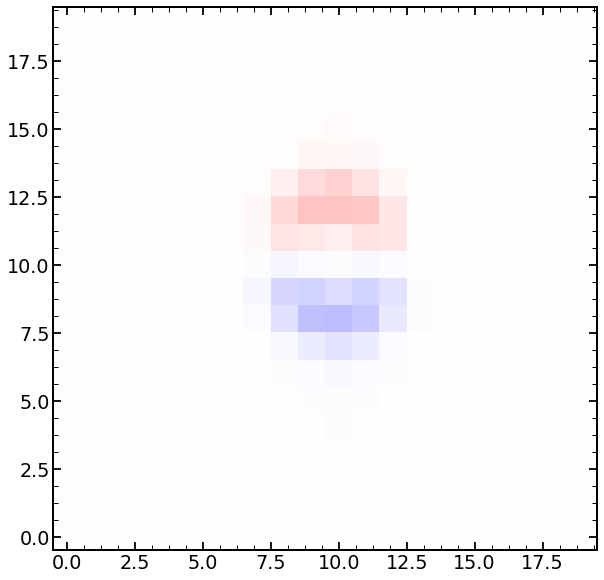

In [436]:
simple_int=(1.8*input_img_single_realization_before_downsampling_normalized_resized+0.2*input_img_single_realization_before_downsampling_normalized_resized_offset1)/2
chi_map_simple_int=(input_img_single_realization_before_downsampling_normalized_resized-simple_int)/np.sqrt(0.9*(input_img_single_realization_before_downsampling_normalized_resized+40))

plt.imshow(chi_map_simple_int,cmap='bwr',vmin=-5,vmax=5)

# coorelations, again

## global ones - probably too small area covered with emcee

In [122]:
obs=8624
single_number=66
single_analysis=Zernike_Analysis(date,obs,single_number,eps,arc)
chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains()
minchain,like_min=single_analysis.create_likelihood()

(number of walkers, number of steps, number of parameters): (252, 40, 42)
minimal likelihood is: 5423.629487053347
minimal chi2 reduced is: 3.0084949227239526


In [123]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

def find_min(arr):
    res=[]
    for i in range(len(arr)):
        res.append(arr[i][abs(arr[i][:,2])==np.min(abs(arr[i][:,2]))])
        
    return res
  
from scipy.optimize import curve_fit

def lin_fit_1D(x,a,b,c):
    return a * x +b*x**2+c    
   
def lin_fit_1D(x,a,b,c):
    return a * x +b*x**2+c     
    
#find_min(test_array_sorted_by_0_split_sorted_by_1_split)
# AS you vary first variable, how does the second one change
# split your chain a function of first variable in bins
# find best value for second variable
# create 1D result
# fit some sort of function

fits=[]
for p1 in tqdm(range(42)):
    for p2 in range(42):
        # remove duplicates
        test_array=np.unique(np.transpose(np.array([chain0_Emcee3[:,:,p1].ravel(),chain0_Emcee3[:,:,p2].ravel(),likechain0_Emcee3.ravel()])),axis=0)
        # sort according to the first variable
        test_array_sorted_by_0=test_array[np.argsort(test_array[:, 0])]
        # split according to the first variable
        test_array_sorted_by_0_split=np.array(list(split(test_array_sorted_by_0,100)))
        """
        # old function which splits furhter - I do not think I want that actually 
        res=[]
        for j in range(len(test_array_sorted_by_0_split)):
            test_array_sorted_by_0_split_sorted_by_1_split=np.array(list(split(test_array_sorted_by_0_split[j][np.argsort(test_array_sorted_by_0_split[j][:, 1])],10)))
            res.append(find_min(test_array_sorted_by_0_split_sorted_by_1_split))

        res=np.array(np.split(np.array(res).ravel(),len(np.array(res).ravel())/3))
        res[:,2]=res[:,2]/np.max(res[:,2])
        """

        res=[]
        for j in range(len(test_array_sorted_by_0_split)):
            min_values_for_this_split=test_array_sorted_by_0_split[j][np.abs(test_array_sorted_by_0_split[j][:,2])==np.min(np.abs(test_array_sorted_by_0_split[j][:,2]))][0]
            res.append(min_values_for_this_split)

        res=np.array(np.split(np.array(res).ravel(),len(np.array(res).ravel())/3))
        res[:,2]=res[:,2]/np.max(res[:,2])

        popt, pcov = curve_fit(lin_fit_1D, xdata=res[:,0].astype(float), ydata=res[:,1].astype(float),p0=[0,0,0])
        res_1st_iteration=lin_fit_1D(res[:,0].astype(float),*popt)
        residuals_1st_iteration=res[:,1].astype(float)-res_1st_iteration
        std_res=(residuals_1st_iteration)/np.std(residuals_1st_iteration)
        y_values_for_second=res[:,1][np.abs(std_res)<3]
        x_values_for_second=res[:,0][np.abs(std_res)<3]
        popt, pcov = curve_fit(lin_fit_1D, xdata=x_values_for_second, ydata=y_values_for_second,p0=[0,0,0])
        fits.append([p1,p2,popt[0],popt[1],popt[2]])
        res_2nd_iteration=lin_fit_1D(res[:,0].astype(float),*popt)


  2%|▏         | 1/42 [00:00<00:18,  2.27it/s]/Users/nevencaplar/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 42/42 [00:14<00:00,  2.85it/s]


In [125]:
        p1=0
        p2=22
        test_array=np.unique(np.transpose(np.array([chain0_Emcee3[:,:,p1].ravel(),chain0_Emcee3[:,:,p2].ravel(),likechain0_Emcee3.ravel()])),axis=0)
        # sort according to the first variable
        test_array_sorted_by_0=test_array[np.argsort(test_array[:, 0])]
        # split according to the first variable
        test_array_sorted_by_0_split=np.array(list(split(test_array_sorted_by_0,100)))
        """
        # old function which splits furhter - I do not think I want that actually 
        res=[]
        for j in range(len(test_array_sorted_by_0_split)):
            test_array_sorted_by_0_split_sorted_by_1_split=np.array(list(split(test_array_sorted_by_0_split[j][np.argsort(test_array_sorted_by_0_split[j][:, 1])],10)))
            res.append(find_min(test_array_sorted_by_0_split_sorted_by_1_split))

        res=np.array(np.split(np.array(res).ravel(),len(np.array(res).ravel())/3))
        res[:,2]=res[:,2]/np.max(res[:,2])
        """

        res=[]
        for j in range(len(test_array_sorted_by_0_split)):
            min_values_for_this_split=test_array_sorted_by_0_split[j][np.abs(test_array_sorted_by_0_split[j][:,2])==np.min(np.abs(test_array_sorted_by_0_split[j][:,2]))][0]
            res.append(min_values_for_this_split)

        res=np.array(np.split(np.array(res).ravel(),len(np.array(res).ravel())/3))
        res[:,2]=res[:,2]/np.max(res[:,2])

        popt, pcov = curve_fit(lin_fit_1D, xdata=res[:,0].astype(float), ydata=res[:,1].astype(float),p0=[0,0,0])
        res_1st_iteration=lin_fit_1D(res[:,0].astype(float),*popt)
        residuals_1st_iteration=res[:,1].astype(float)-res_1st_iteration
        std_res=(residuals_1st_iteration)/np.std(residuals_1st_iteration)
        y_values_for_second=res[:,1][np.abs(std_res)<3]
        x_values_for_second=res[:,0][np.abs(std_res)<3]
        popt, pcov = curve_fit(lin_fit_1D, xdata=x_values_for_second, ydata=y_values_for_second,p0=[0,0,0])
        #fits.append([p1,p2,popt[0],popt[1],popt[2]])
        res_2nd_iteration=lin_fit_1D(res[:,0].astype(float),*popt)


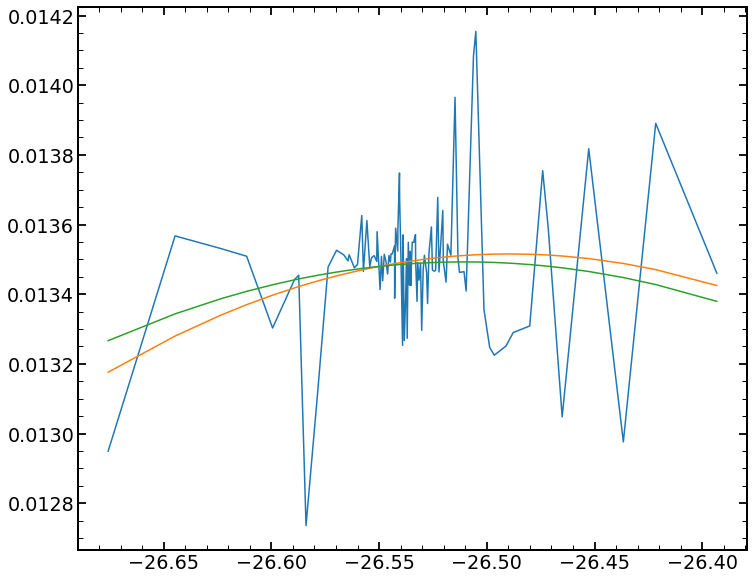

In [127]:
plt.plot(res[:,0],res[:,1])
plt.plot(res[:,0],res_1st_iteration)
plt.plot(res[:,0],res_2nd_iteration)

## How to move into focus